# Machine Learning Project
## Mbusu-Team

### **House Prices Dataset**

### **Data Understanding**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sb
from scipy.stats import entropy
import math
import sys
from itertools import groupby
import re
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_integer_dtype
plt.style.use('ggplot')


hue_order = ["HIGH","MEDIUM","LOW"]
color = ["#BF4E30","#2E86AB","#E7A012"]
palette = {
    'LOW': color[0],
    'MEDIUM': color[1],
    'HIGH': color[2],
}
TARGET_FEATURE = 'SalePrice'
TARGET_FEATURE_CONTI = 'salePriceNum'
TARGET_FEATURE_VALUES = ['LOW', 'MEDIUM', 'HIGH']

#### Utils

###### INFORMATION GAIN FUNTION 

In [2]:
def IG(df, target, attribute):

    df_sub = []

    for value in df[attribute].unique():
        df_sub.append( df[df[attribute] == value] )
        
    counts = df[target].value_counts()
    probs = counts / len(df)
    e = -np.sum(probs * np.log2(probs))

    information_gain = e 
    for df_s in df_sub:
        counts = df_s[target].value_counts()
        probs = counts / len(df_s)
        e_s = -np.sum(probs * np.log2(probs))
        information_gain -= len(df_s) / len(df) * e_s

    return information_gain


###### Mean

In [3]:
def mean_attribute(df, attribute):
    mean_low = df[ ( df["SalePrice"] == 'LOW' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_medium = df[ ( df["SalePrice"] == 'MEDIUM' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_high = df[ ( df["SalePrice"] == 'HIGH' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    return (mean_low, mean_medium, mean_high)



###### Set means

In [4]:
def set_means(df,attribute):
    mean_values = mean_attribute(df,attribute)

    for ind , e  in df.iterrows():
        if e[attribute] == "NA":
            if(e["SalePrice"] == "LOW"):
                df.at[ind, attribute] = mean_values[0]
            elif e["SalePrice"] == "MEDIUM":
                df.at[ind, attribute] = mean_values[1]
            else:
                df.at[ind, attribute] = mean_values[2]


    df[attribute] = df[attribute].astype("int")


###### aggregate categories if below threshold

In [5]:
def aggregate(df, new_name, threshold, attribute):
    values_count= df[attribute].value_counts()
    for i in values_count.keys():
        if values_count[i] <= threshold:
            df[attribute] = df[attribute].replace([i], new_name)
    return df

###### Plot frequencies and percentages for numerical attributes

In [6]:
def frequencies_and_percentages_numeric(df, target, attribute, bin, rotation=0, figsize=(15,5),display=False):
    fig, ax = plt.subplots(1,2, figsize=figsize)
    df1 = df.copy()
    df1[attribute] = pd.qcut(df1[attribute], q=bin)
    regexp_1 = re.compile(r".(\-?\d+)\.?\d*, ?(\-?\d+)\.?\d*.")
    for i in df1[attribute].unique():
        re_match = regexp_1.match(str(i))
        if re_match is not None:
            val = [re_match[1], re_match[2]]
            for j in range(0, len(val)):
                    if val[j] == "-0":
                         val[j] = "0"
            df1[attribute] = df1[attribute].replace(i, str(val[0])+" - "+str(val[1]))
    dfp = df1[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df1[target].unique()), axis='index'))
    if display:
        display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color)
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=rotation, horizontalalignment='right')

###### Plot frequencies and percentages

In [7]:
def frequencies_and_percentages(df, target, attribute, figsize=(15,5), rotation=0, display=False):
    fig, ax = plt.subplots(1,2, figsize=figsize)

    dfp = df[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df[target].unique()), axis='index'))
    if display:
        display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color)
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=rotation, horizontalalignment='right')

###### Category analysis

In [8]:
def category_common_analysis(data, x, target ,palette, histplot = True, percentages=True, count = None, display=True, figsize=(15,5), rotation = 0):
    if histplot:
        plt.figure(figsize = figsize)
        sb.histplot(x = data[x], multiple='stack', hue = target,  data = data, hue_order = hue_order, palette = palette, alpha=1)
    if percentages:
        frequencies_and_percentages(data, target, x,figsize=figsize,rotation=rotation)
    if display:
        if count is None:
            print(data[x].value_counts())
        else :
            print(data[x].value_counts()[count])

###### Histplot

In [9]:

def histplot(df,target, attribute, bins = 200 , figsize=(15,5), xticks_rot=0, xlim = None, multiple = 'layer', alpha = 0.5):
    plt.figure(figsize = figsize)
    sb.histplot(x = df[attribute], hue = target, data = df, kde=True , hue_order = hue_order, palette = palette, multiple= multiple , 
                bins = bins ,alpha = alpha , common_bins= True)
    plt.xticks(rotation=xticks_rot)
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()

###### indepence_test_categoric

In [10]:

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            if pos % 3 == 0: add_line(ax, pos*scale, ypos - .052)
            pos += rpos
        add_line(ax, pos*scale , ypos - .052)
        ypos -= .05

def barplot_diffvalues(dataset, feature_name):
    df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(dataset)
    dataset.pivot_table(index = [feature_name, TARGET_FEATURE], columns=['__Type']).plot(kind='bar', ax=ax, width=.7)
    
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title('Expected/Observed Frequencies')
    ax.set_xlabel(f'{feature_name}/{TARGET_FEATURE}', labelpad=40)
    ax.set_ylabel(f'{TARGET_FEATURE}')
    plt.legend(['Expected', 'Observed'])
    label_group_bar_table(ax, df)

    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    plt.show()

def stattest_quali(df, feature_name: str, target = TARGET_FEATURE, fig_width=15, fig_height=3, typeplot = 'heatmap', silent: bool=False, cramer: bool=False):
    #
    # chi-square test and expected frequencies matrix
    #
    crosstab = pd.crosstab(df[feature_name], df[target])
    chi_square_args = crosstab.values
    _, p_value, _, _ = stats.chi2_contingency(chi_square_args)
 
    #
    # Cramer's V
    #
    cramer_crosstab = crosstab.values
    X2 = stats.chi2_contingency(cramer_crosstab, correction=False)[0]
    N = np.sum(cramer_crosstab)
    minimum_dimension = min(cramer_crosstab.shape)-1
    corr_cramer = np.sqrt((X2/N) / minimum_dimension)

    expf_crosstab = pd.DataFrame(crosstab)
    for idx in expf_crosstab.index:
        for col in expf_crosstab.columns:
            expf_crosstab.at[idx, col] = crosstab.loc[idx].values.sum() * crosstab[col].values.sum() / crosstab.values.sum()

    if not silent:
        #
        # observed/expected frequencies heatmaps
        #
        fig_width = min(fig_width, 1.5 * len(df[feature_name].unique()))
        fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_height * 2))
        sb.heatmap(crosstab.T, ax=ax[0], annot=True, cmap='coolwarm', fmt='.2f')
        sb.heatmap(expf_crosstab.T, ax=ax[1], annot=True, cmap='coolwarm', fmt='.2f')
        ax[0].set_title('Observed Frequencies')    
        ax[1].set_title('Expected Frequencies')
        fig.tight_layout()
        plt.show()

        if(typeplot == 'heatmap'):
            
            #
            # frequencies difference heatmap
            #
            obsexp_diff_df = crosstab - expf_crosstab
            fig = plt.figure(figsize=(fig_width, fig_height))
            plt.title("Frequency Differences (Observed - Expected)")
            sb.heatmap(obsexp_diff_df.T, annot=True, cmap='vlag', fmt='.2f')
        
        elif typeplot == 'barplot':
            #
            # observed/expected frequencies barplot
            #
            value_vars_x = [val + '_x' for val in df[target].unique().tolist()]
            value_vars_y = [val + '_y' for val in df[target].unique().tolist()]
            value_vars_xy = value_vars_x + value_vars_y
            obs_exp_df = pd.merge(crosstab, expf_crosstab, on=[feature_name]).reset_index()
            obs_exp_df = pd.melt(obs_exp_df, id_vars=[feature_name], value_vars=value_vars_xy)
            obs_exp_df['__Type'] = obs_exp_df[target]

            for val in value_vars_x: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__OBS'
            for val in value_vars_y: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__EXP'

            for price in df[target].unique().tolist():
                for obs_exp in ['x', 'y']:
                    obs_exp_df.loc[obs_exp_df[target] == price + '_' + obs_exp, target] = price[0]

            barplot_diffvalues(obs_exp_df, feature_name)

    #
    # chi-square test outcome
    #
    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    if not silent:
        print("Chi-square Test - Outcome")
        print("P-Value:", p_value, p_value_info)
        print("Cramer's V - Outcome")
        print("Coeff:", corr_cramer)
    if cramer:
        return p_value, p_value_info, corr_cramer
    return p_value, p_value_info

###### indepence_test_numeric

In [11]:
def stattest_quanti(df, feature_name: str, target = TARGET_FEATURE ,low_limit=0, upper_limit=100, silent = False, cramer: bool = False):
 
    #
    # Cramer's V
    #
    if cramer:
        df_copy2 = df.copy(deep=True)
        df_copy2[feature_name] = pd.qcut(df_copy2[feature_name], q=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], duplicates='drop')
        _, _, corr_cramer = stattest_quali(df_copy2, feature_name=feature_name, target=target, cramer=True, silent=True)
        
    #
    # plot means w.r.t. target categories
    #
    df_conti_origin = df[[feature_name, target, TARGET_FEATURE_CONTI]] if ( target == TARGET_FEATURE) else None
    df_categ_origin = df[[feature_name, target]]
    target_feature_values = df[target].unique().tolist()
    df = df_categ_origin.groupby(target)
    mean_df = df.mean().reset_index().rename(columns={feature_name: feature_name + ' (AVG)'})

    if not silent: 
        num = 3
        if df_conti_origin is None:
            num = 2
        _, ax = plt.subplots(1, num, figsize=(20, 5))

        mean_df.plot(kind='bar', x=target, ax=ax[0])
        for container in ax[0].containers:
            ax[0].bar_label(container, fmt='%.1f')
        ax[0].set_ylim(low_limit, upper_limit)
        ax[0].tick_params(labelrotation=0)
        sb.histplot(x=feature_name, hue=target, data=df_categ_origin, kde=True, ax=ax[1])
        for tval in target_feature_values:
            ax[1].axvline(x=df_categ_origin[df_categ_origin[target] == tval][feature_name].mean(), color='gray', ls='--', lw=1.5)
        
        if df_conti_origin is not None : sb.regplot(x=feature_name, y=TARGET_FEATURE_CONTI, data=df_conti_origin, line_kws={"color": "darkred"}, ax=ax[2])
        
    #
    # perform ANOVA test
    #
    anova_args = tuple(df[feature_name].apply(list).reset_index()[feature_name])
    f_statistic, p_value = stats.f_oneway(*anova_args)

    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    if not silent:
        print("ANOVA Test - Outcome")
        print("P-Value:", p_value, p_value_info)
        if cramer:
            print("Cramer's V - Outcome")
            print("Coeff:", corr_cramer)
    if cramer:
        return p_value, p_value_info, corr_cramer
    return p_value, p_value_info

###### Numeric Numeric Correlation

In [12]:
def correlation(df, n1, n2, silent = False):

    
    corr, p_values = stats.pearsonr(df[n1], df[n2])
    
    if not silent:
        sb.regplot(x=n1, y=n2, data=df, line_kws={"color": "darkred"})
        print(corr, p_values)

    return (corr, p_values)

###### Categoric Ordinal Plots & Stattest

In [13]:
def categoric_ordinal_plot(df, attr, test_typeplot='heatmap'):

    attr_values = df[attr].unique().tolist()
    df[attr] = df[attr].astype('object')
    for val in attr_values: df.loc[df[attr] == val, attr] = attr + '_' + str(val)
    df[attr] = df[attr].astype('category')

    frequencies_and_percentages(df, TARGET_FEATURE, attr)
    stattest_quali(df, attr, typeplot=test_typeplot)
    print(IG(df, TARGET_FEATURE, attr))

###### Understanding 

In [14]:
def understand(dataf: pd.DataFrame, feature_name: str, dtype: str='category', \
               predconf_max: float=1.0, predconf_min: float=0.33, showplots=True, na = 'NA', bins = 50, \
               low_limit = 0, upper_limit = 100 , xlim = None, rotation = 0):
    data_feature = dataf[feature_name]
    data_target = dataf[TARGET_FEATURE]
    report = ''
    report += "Understanding %s:" % feature_name + "\n"
    
    #
    # count missing values
    #
    miss_values = data_feature.isna().sum()
    miss_values += dataf[data_feature == na ].index.size
    report += "\tMissing values: " + str(miss_values) + "\n"

    data_feature = data_feature.astype(dtype)

    if dtype == 'category' or dtype == 'object':

        if dtype == 'object':
            attr_values = data_feature.unique().tolist()
            data_feature = data_feature.astype('object')
            for ind in range(len(dataf)): data_feature[ind] = feature_name + '_' + str(data_feature[ind])
            data_feature = data_feature.astype('category')
            dataf[feature_name] = data_feature

        if showplots: 
            frequencies_and_percentages(dataf, TARGET_FEATURE, feature_name, rotation= rotation)
        #
        # perform the independence test
        #
        p_value, p_value_info = stattest_quali(dataf, feature_name, typeplot='heatmap' if showplots else'none', silent=not showplots)
        report += "\tIndependence Test: " + '{:.2e}'.format(p_value) + p_value_info + "\n"

        #
        # compute the IG
        #
        ig = IG(dataf, TARGET_FEATURE, feature_name)
        report += "\tInformation Gain: " + "%.2f" % ig + "\n"

        crosstab = pd.crosstab(data_feature, data_target)
        to_predict_map = {}
        no_predict_values = []
        for cat_val in crosstab.T:
            no_predict_values.append(cat_val)
        predconf = predconf_max

        while predconf > predconf_min and len(no_predict_values) > 0:
            new_no_predict_values = []

            for cat_val in no_predict_values:
                to_predict = []
                for target_val in TARGET_FEATURE_VALUES:
                    if crosstab.at[cat_val, target_val] / crosstab.loc[cat_val].values.sum() >= predconf:
                        to_predict.append(target_val)
                        to_predict.append(predconf)
                        break
                
                if len(to_predict) > 0:
                    new_to_predict_map = to_predict_map.copy()
                    added = False
                    to_delete = []
                    for k in to_predict_map.keys():
                        if to_predict_map[k] == to_predict:
                            new_to_predict_map[k + '+' + cat_val] = to_predict
                            added = True
                            to_delete.append(k)
                    if not added:
                        new_to_predict_map[cat_val] = to_predict
                    for k in to_delete:
                        del new_to_predict_map[k]
                    to_predict_map = new_to_predict_map
                else:
                    new_no_predict_values.append(cat_val)
            
            no_predict_values = new_no_predict_values
            predconf -= 0.05
        
        report += "\tWhen the %s is:" % feature_name + "\n"
        for cat_vals in to_predict_map.keys():
            if to_predict_map[cat_vals][1] == 1.0:
                report += "\t\t• %s, then the sale price is %s" % (cat_vals, to_predict_map[cat_vals][0])
            else:
                report += "\t\t• %s, then the sale price is %.0f%% likely to be %s" % \
                    (cat_vals, to_predict_map[cat_vals][1]*100, to_predict_map[cat_vals][0])
            
            cat_vals_freq = 0.0
            for cval in cat_vals.split('+'):
                cat_vals_freq += len(dataf[data_feature == cval]) / len(data_feature)
            report += " (%.2f%% of the times)" % (cat_vals_freq*100) + "\n"

        if len(no_predict_values) > 0:
            report += "\t\t• %s cannot predict the sale price" % '+'.join(no_predict_values) + "\n"
        report += "\n"

    elif dtype == 'int':
        if showplots: 
            histplot(df=dataf, target=TARGET_FEATURE, attribute=feature_name, bins= bins, xlim = xlim)
        p_value, p_value_info = stattest_quanti(df=dataf, feature_name=feature_name, target=TARGET_FEATURE,low_limit=low_limit, upper_limit=upper_limit, silent=True)
        report += "\tIndependence Test: " + '{:.2e}'.format(p_value) + p_value_info + "\n"
        corr, p_value_corr = correlation(df=dataf, n1= feature_name, n2= TARGET_FEATURE_CONTI, silent=True)
        report += "\tCorrelation Index: %.2f" % corr + "\n"
        report += "\tCorrelation p_value: " + '{:.2e}'.format(p_value_corr) + "\n"

    print(report)

###### Undestanding all

In [15]:
def understanding_all(df):
    features = df.columns
    repos = []
    for f in features:
        if df[f].dtype == 'object':
            repo, ig, p_value = understand(df, f, 'category')
            repos.append((ig, p_value, repo))
    repos.sort(reverse=True)
    for r in repos:
        print(r[2])

###### Total Square Fit

In [16]:
def total_square_feet(dataf: pd.DataFrame):
    total_sf = []
    for ind, e in dataf.iterrows():
        totalsf = e['TotalBsmtSF']
        if e["GarageType"] != 'Basment': 
            totalsf += e['GarageArea']
        # totalsf += e['1stFlrSF']
        # totalsf += e['2ndFlrSF']
        totalsf += e['GrLivArea']
        total_sf.append(totalsf)
    
    return total_sf


###### Understand correlation all

In [17]:
def decide_clique(graph: list[list[int]] , set_nodes : list[int] ):

    for i in set_nodes:
        for j in set_nodes:
            if i != j and graph[i][j] == 0:
                return False
    
    return True

def decide_maximal_clique(graph: list[list] , set_nodes : list[int]):
    
    if not decide_clique(graph=graph, set_nodes=set_nodes):
        return False
    
    for i in range(len(graph)):
        if i not in set_nodes:
            b = True
            for j in set_nodes:
                if graph[i][j] == 0:
                    b = False
            if b :
                return False
    
    return True


def function_maximal_cliques(graph: list[list], n: int) -> list[list[int]]:
    
    if(len(graph) < n or n <= 0):
        return None 

    res = []
    
    maximal_clique = [ i for i in range(n)]

    i = n - 1
    while( maximal_clique[0] < len(graph) - n + 1):

        if i == n - 1 and decide_maximal_clique(graph=graph, set_nodes=maximal_clique):
             res.append(maximal_clique.copy())
        
        maximal_clique[i] += 1
        if maximal_clique[i] < (len(graph) - n + 1 + i):
            # Can increment all counters up to n - 1
            for j in range(i+1,n):
                maximal_clique[j] = maximal_clique[j-1] + 1
            i = n - 1 
        else:
            i -= 1
            
        
    return res
        

def function_maximal_cliques_all(graph: list[list]) -> list[list[int]]:
    
    n = len(graph)

    res = []
    while n > 0 :
        resi = function_maximal_cliques(graph=graph, n=n)

        n -= 1
        if(resi != []):
            res.append(resi)

    return res
def understand_correlation_all(dataf : pd.DataFrame, selected: list, threshold = 0.5):
    
    correlation_scores = {}


    graph = [ [ 0 for _ in range(len(selected)) ] for _ in range(len(selected))  ]

    for i in range(len(selected)):
        for j in range(i+1, len(selected)):
            corr = 0
            bcategoryi = is_categorical_dtype(dataf[selected[i]].dtype) or dataf[selected[i]].dtype == 'object'
            bcategoryj = is_categorical_dtype(dataf[selected[j]].dtype) or dataf[selected[j]].dtype == 'object'
            binti = is_integer_dtype(dataf[selected[i]].dtype)
            bintj = is_integer_dtype(dataf[selected[j]].dtype)
            if (bcategoryi or bcategoryj) and \
                (binti  or bintj  ):
                if bcategoryi:
                    _, _, corr  = stattest_quanti(dataf,feature_name=selected[j], target=selected[i], silent=True, cramer=True )
                else:
                    _, _, corr  = stattest_quanti(dataf,feature_name=selected[i], target=selected[j], silent=True, cramer=True )
            elif bcategoryi and bcategoryj:
                _, _, corr  = stattest_quali(dataf,feature_name=selected[j], target=selected[i], silent=True, cramer=True )
            elif binti and bintj: 
                corr, _  = correlation(dataf, n1 = selected[i], n2 = selected[j], silent=True)
            else:
                if not bcategoryi and  not binti:
                    print("ERROR -> "+selected[i]+ " type -> "+ str(dataf[selected[i]].dtype))
                if not bcategoryj and not bintj:
                    print("ERROR -> "+selected[j]+ " type -> "+ str(dataf[selected[j]].dtype))
            
            corr = abs(corr)
            if  corr >= threshold:
                graph[i][j] = 1
                graph[j][i] = 1
            correlation_scores[selected[i] + "<->" + selected[j]] = corr

    correlation_scores
    correlation_scores = sorted(correlation_scores.items(), key= lambda x: x[1])
    correlation_scores.reverse()
    n = 100
    for i in range(0, n):
        print("Pair "+ str(i)+" : "+ str(correlation_scores[i][0]) + " -> " + str(correlation_scores[i][1]))


    # MAX CLIQUE
    res = function_maximal_cliques_all(graph=graph)
    for n in res:
        size = len(n[0])
        print("Maimal cliques of size: " + str(size))
        for clique in n:
            print("{", end="")
            for i in clique:
                print(SELECTED[i] + " ", end="")
            print("}")

            

#### Read data

In [18]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', keep_default_na = False, low_memory= False )
df["salePriceNum"] = df.SalePrice.rename("salePriceNum")
df["SalePrice"] = pd.cut(df["salePriceNum"], bins = [0,150000,300000 - 1 ,int(sys.maxsize)], labels=["LOW","MEDIUM","HIGH"])
df_copy = df.copy(deep=True)

In [19]:
df.shape

(1460, 82)

In [20]:
df.describe()

Id   MSSubClass        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000    56.897260   10516.828082     6.099315     5.575342   
std     421.610009    42.300571    9981.264932     1.382997     1.112799   
min       1.000000    20.000000    1300.000000     1.000000     1.000000   
25%     365.750000    20.000000    7553.500000     5.000000     5.000000   
50%     730.500000    50.000000    9478.500000     6.000000     5.000000   
75%    1095.250000    70.000000   11601.500000     7.000000     6.000000   
max    1460.000000   190.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   443.639726    46.549315   567.240411  ...   
std      30.202904     20.645407   456.098091   161.319273   441.866955  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000   223.000000  ...   
50%    1973.000000   1994.000000   383.500000     0.000000   477.500000  ...   
75%    2000.000000   2004.000000   712.250000     0.000000   808.000000  ...   
max    2010.000000   2010.000000  5644.000000  1474.000000  2336.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold   salePriceNum  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 35 columns]

#### View Data

In [21]:
df.head()

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   
1   2          20       RL          80     9600   Pave    NA      Reg   
2   3          60       RL          68    11250   Pave    NA      IR1   
3   4          70       RL          60     9550   Pave    NA      IR1   
4   5          60       RL          84    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
0         Lvl    AllPub  ...     NA    NA          NA       0      2   2008   
1         Lvl    AllPub  ...     NA    NA          NA       0      5   2007   
2         Lvl    AllPub  ...     NA    NA          NA       0      9   2008   
3         Lvl    AllPub  ...     NA    NA          NA       0      2   2006   
4         Lvl    AllPub  ...     NA    NA          NA       0     12   2008   

  SaleType  SaleCondition  SalePrice  salePriceNum  
0       WD         Normal     MEDIUM        208500  
1       WD         Normal     MEDIUM        181500  
2       WD         Normal     MEDIUM        223500  
3       WD        Abnorml        LOW        140000  
4       WD         Normal     MEDIUM        250000  

[5 rows x 82 columns]

#### Info data

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   object  
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

#### Classes

In [23]:
df.SalePrice.unique()

['MEDIUM', 'LOW', 'HIGH']
Categories (3, object): ['LOW' < 'MEDIUM' < 'HIGH']

MEDIUM    726
LOW       619
HIGH      115
Name: SalePrice, dtype: int64

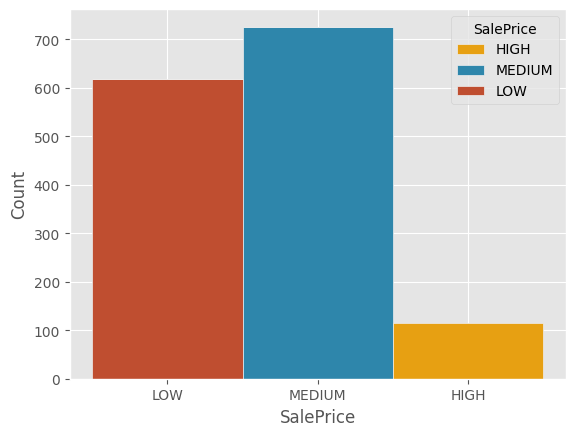

In [24]:
sb.histplot(x = 'SalePrice', multiple='stack', hue = "SalePrice",  data = df, hue_order = hue_order, palette = palette, alpha=1)
df["SalePrice"].value_counts()

#### Undestanding the effect of the attributes

##### ID

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.00000000e+00, 1.99931507e+00, 2.99863014e+00, ...,
        1.45800137e+03, 1.45900068e+03, 1.46000000e+03]),
 <BarContainer object of 1460 artists>)

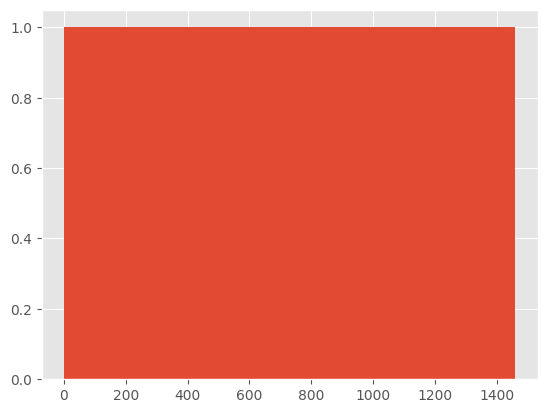

In [25]:
plt.hist(df["Id"], bins= len(df))

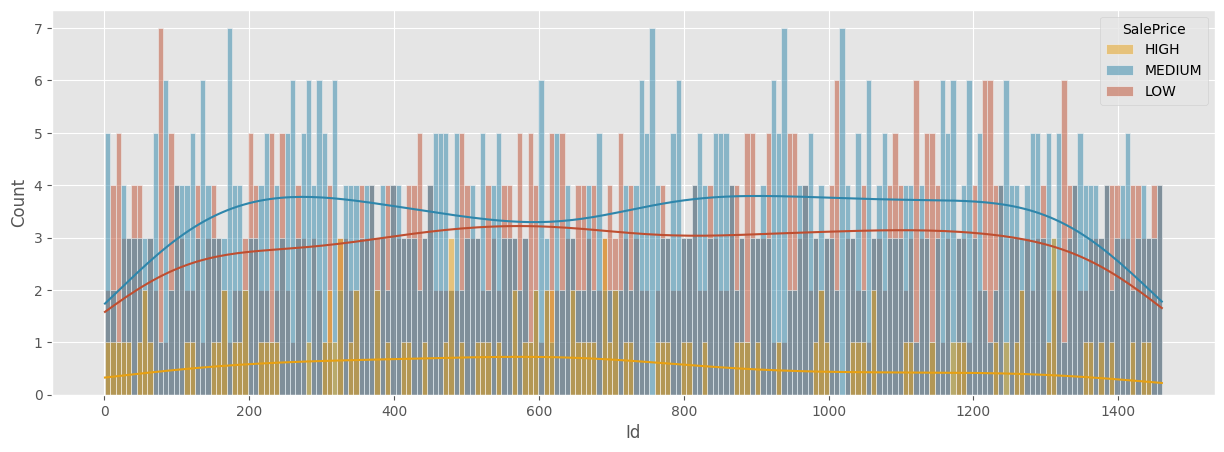

In [26]:
histplot(df,'SalePrice',"Id")

In [27]:
print("Max Entropy ( Log n ) -> " + str(math.log(len(df), 2)))

counts = df['Id'].value_counts()
probs = counts / len(df)
e = -np.sum(probs * np.log2(probs))
print("Entropy -> "+ str(e))

Max Entropy ( Log n ) -> 10.51175265376738
Entropy -> 10.511752653767381


##### MSSubClass

In [28]:
df_copy["MSSubClass"] = df_copy["MSSubClass"].astype("category")

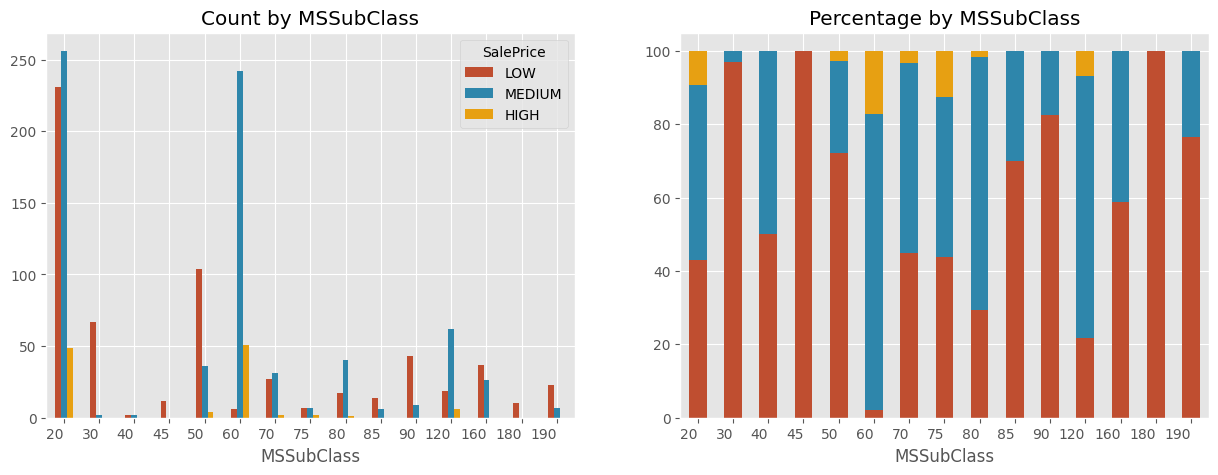

In [29]:
frequencies_and_percentages(df_copy, 'SalePrice', 'MSSubClass')

In [30]:
IG(df,"SalePrice","MSSubClass")

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.28611883641757957

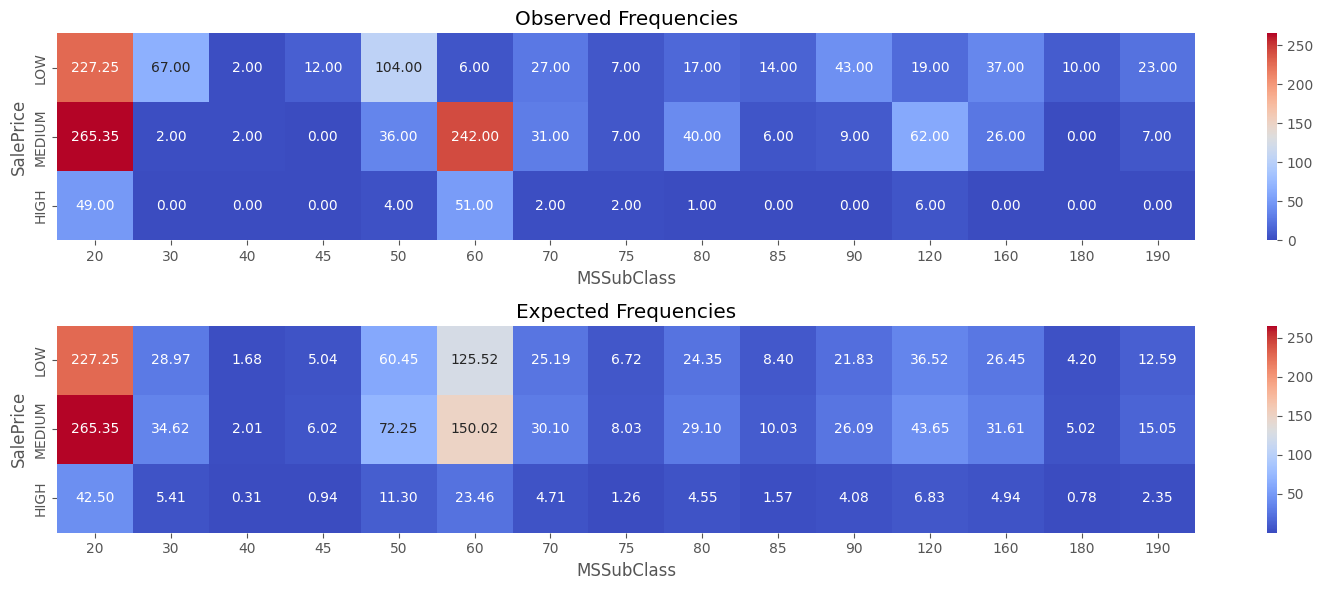

Chi-square Test - Outcome
P-Value: 1.122234664911419e-81 [<0.05]
Cramer's V - Outcome
Coeff: 0.4010822438878207


(1.122234664911419e-81, '[<0.05]')

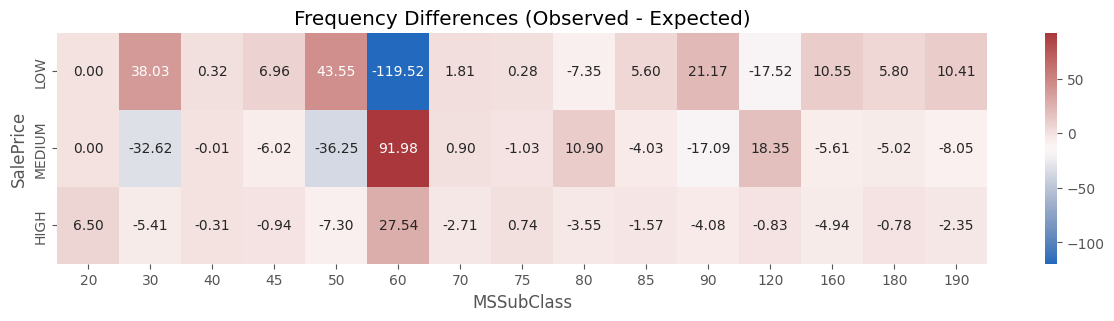

In [31]:
# Indepence test

stattest_quali(df, 'MSSubClass')

##### MSZoning

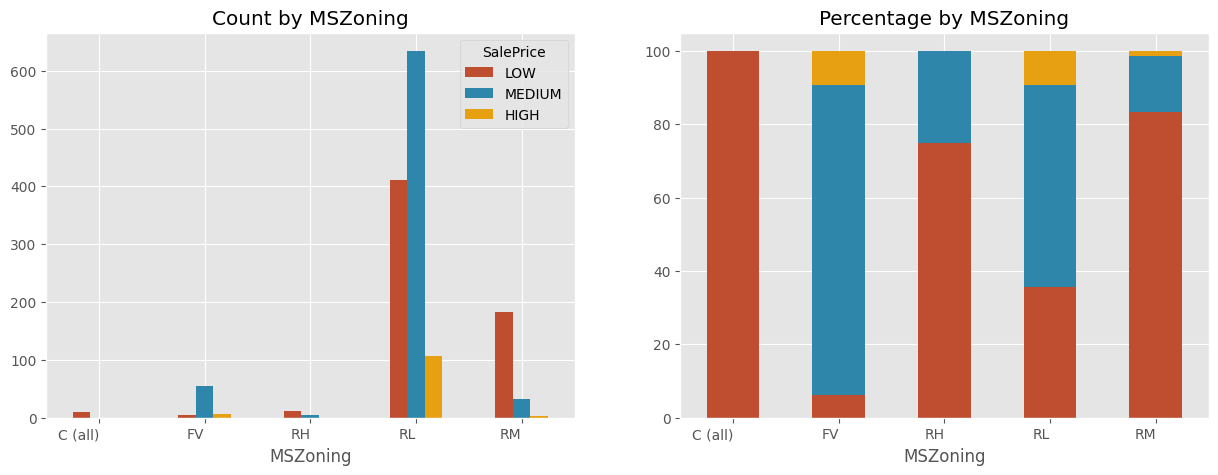

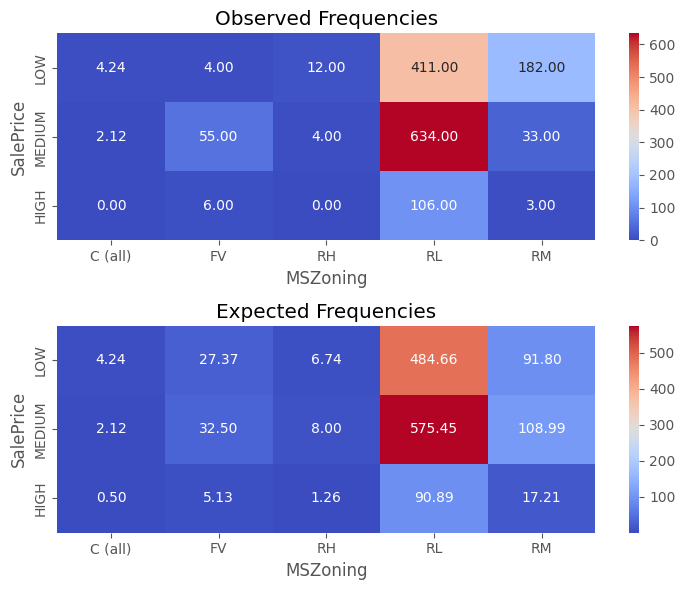

Chi-square Test - Outcome
P-Value: 4.034588700502159e-45 [<0.05]
Cramer's V - Outcome
Coeff: 0.28026704153692883
Understanding MSZoning:
	Missing values: 0
	Independence Test: 4.03e-45[<0.05]
	Information Gain: 0.12
	When the MSZoning is:
		• C (all), then the sale price is LOW (0.68% of the times)
		• FV, then the sale price is 80% likely to be MEDIUM (4.45% of the times)
		• RM, then the sale price is 80% likely to be LOW (14.93% of the times)
		• RH, then the sale price is 75% likely to be LOW (1.10% of the times)
		• RL, then the sale price is 55% likely to be MEDIUM (78.84% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


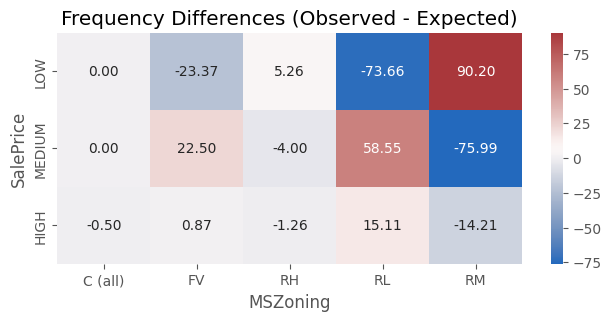

In [32]:
understand(dataf=df_copy, feature_name='MSZoning')   

##### LotFrontage

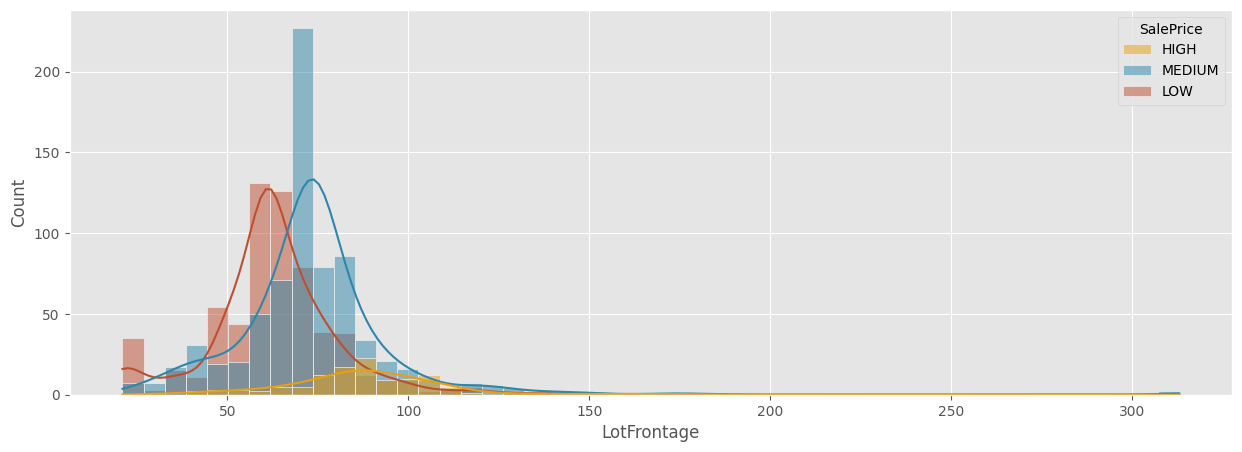

In [33]:
set_means(df_copy,'LotFrontage')
histplot(df_copy,'SalePrice',"LotFrontage", multiple='layer', bins=50, alpha=0.5)


##### LotArea

Understanding LotArea:
	Missing values: 0
	Independence Test: 2.90e-18[<0.05]
	Correlation Index: 0.26
	Correlation p_value: 1.12e-24



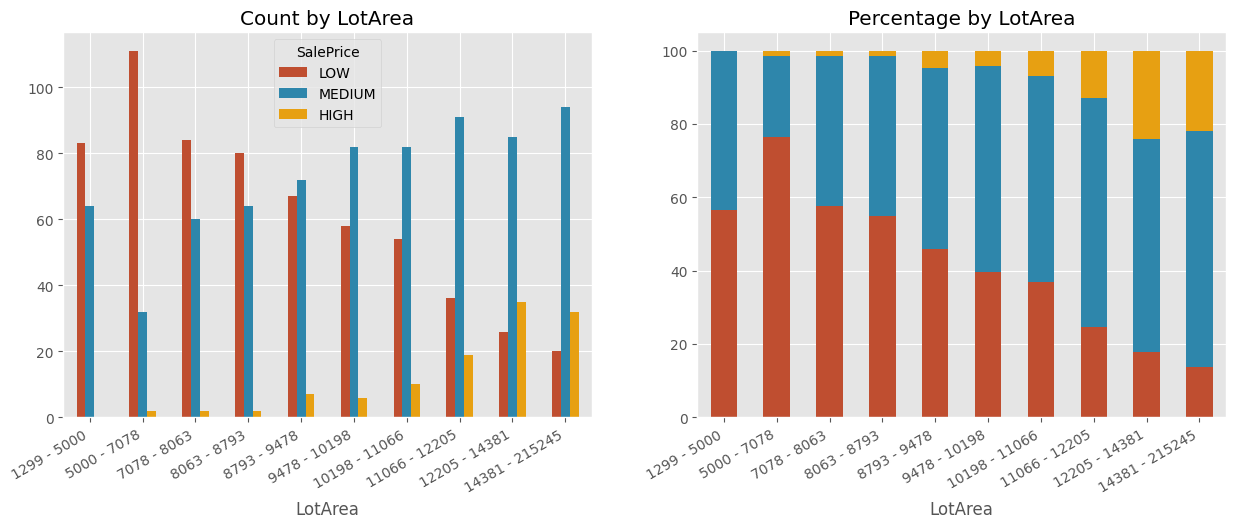

In [34]:
# As we can see from the graphs, the l the lot area the higher the price of the house.
# We think that it is useful to split the values of the attribute into bins.
frequencies_and_percentages_numeric(df, 'SalePrice', 'LotArea', rotation=30, bin = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
understand(dataf=df_copy, feature_name='LotArea', dtype='int',showplots=False, upper_limit=20000)

##### Street

Pave    1454
Grvl       6
Name: Street, dtype: int64


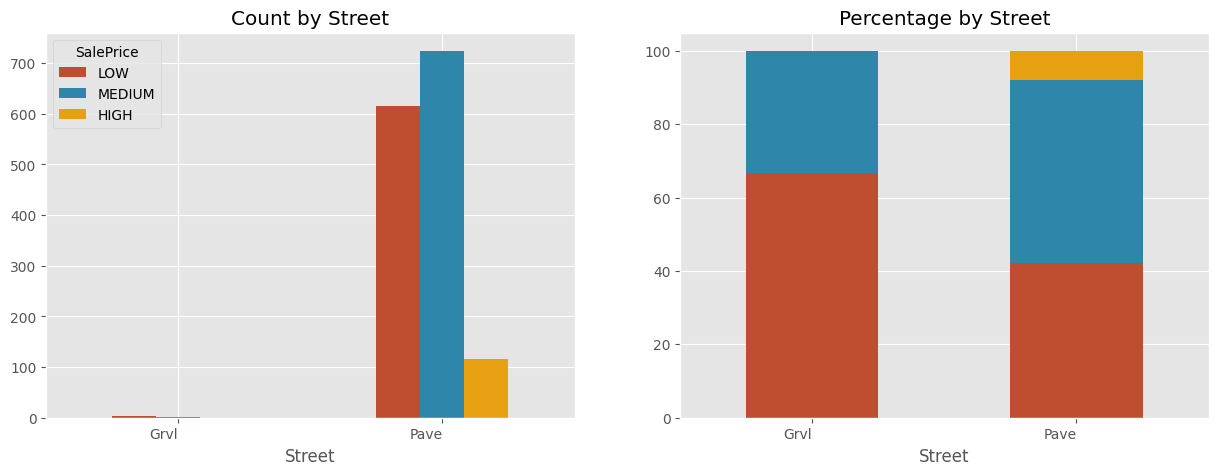

In [35]:
#Given that the training is strongly unbalanced
df_copy['Street'] = df['Street'].astype('category')
category_common_analysis(data=df_copy, x='Street',target='SalePrice',histplot=False, palette=palette)

##### Alley

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64


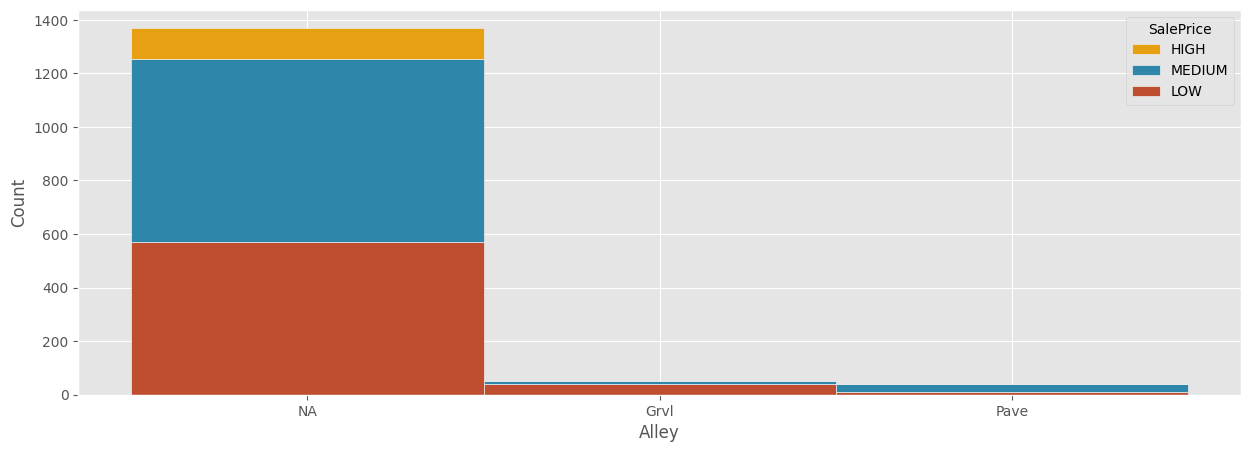

In [36]:
category_common_analysis(data=df, x='Alley',target='SalePrice',percentages=False, palette=palette)

##### LotShape

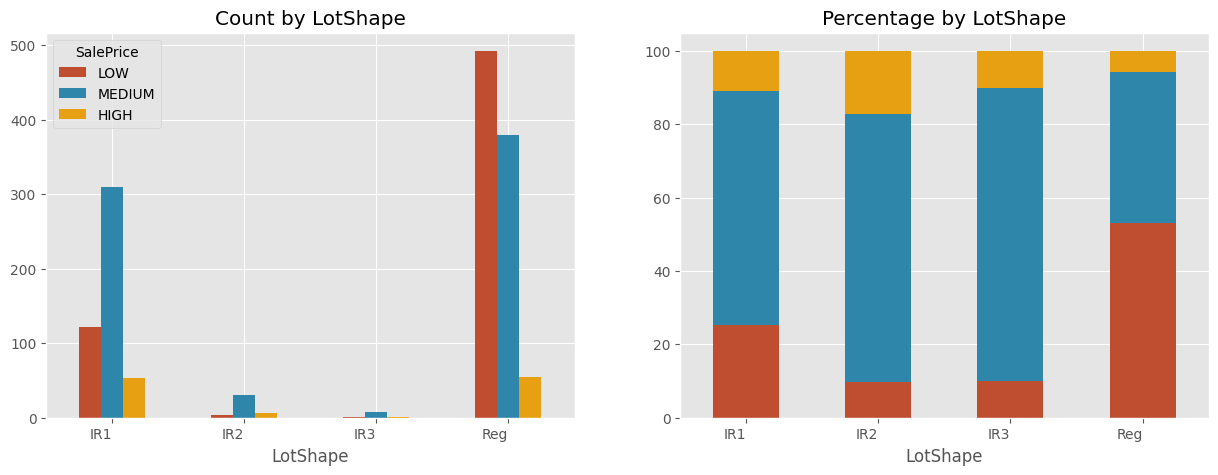

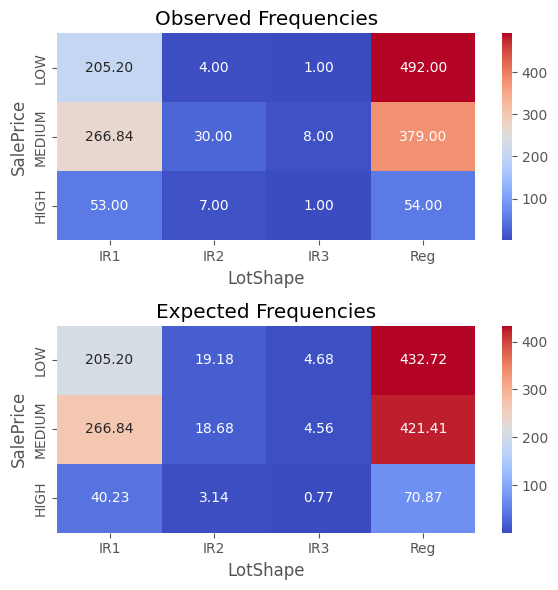

Chi-square Test - Outcome
P-Value: 5.252128283563737e-25 [<0.05]
Cramer's V - Outcome
Coeff: 0.20862876181781315
Understanding LotShape:
	Missing values: 0
	Independence Test: 5.25e-25[<0.05]
	Information Gain: 0.07
	When the LotShape is:
		• IR3, then the sale price is 80% likely to be MEDIUM (0.68% of the times)
		• IR2, then the sale price is 70% likely to be MEDIUM (2.81% of the times)
		• IR1, then the sale price is 60% likely to be MEDIUM (33.15% of the times)
		• Reg, then the sale price is 50% likely to be LOW (63.36% of the times)




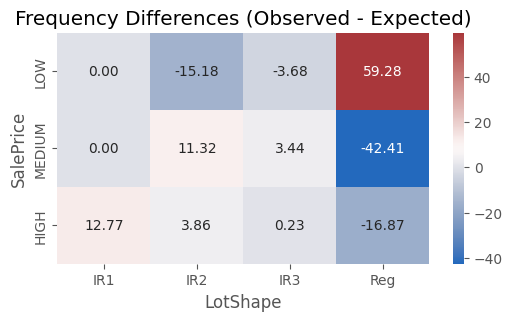

In [37]:

# to be verified with chi-squared test
# IR2 and IR3 can be aggregated in a new category
#we can see that in proportion R1 and Reg can be significantly different
understand(dataf=df_copy,feature_name='LotShape')

##### LandContour

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


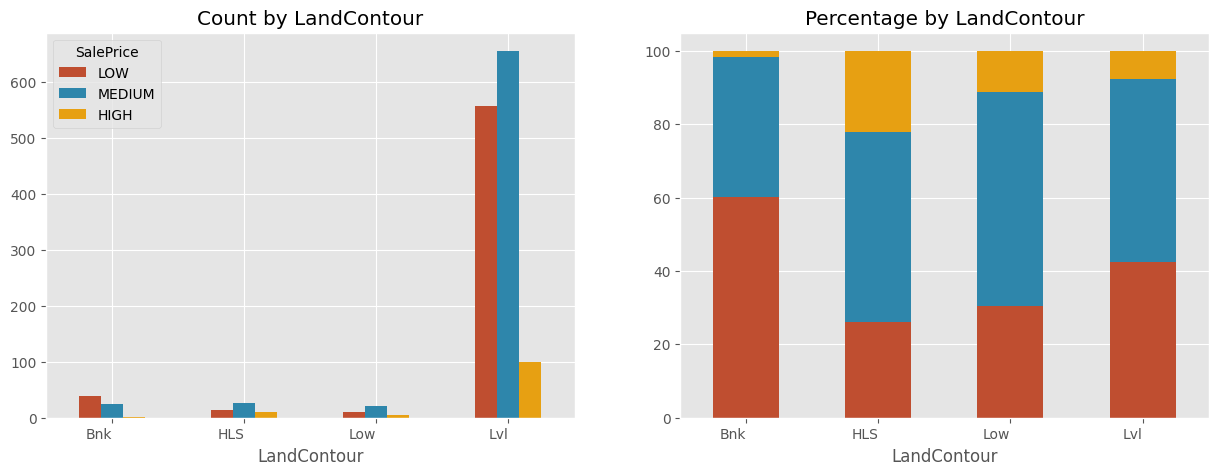

In [38]:
# maybe not enough values for a good model, we do not know if they are significant
category_common_analysis(data=df, x='LandContour',target='SalePrice', palette=palette, histplot=False)

##### Utilities

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


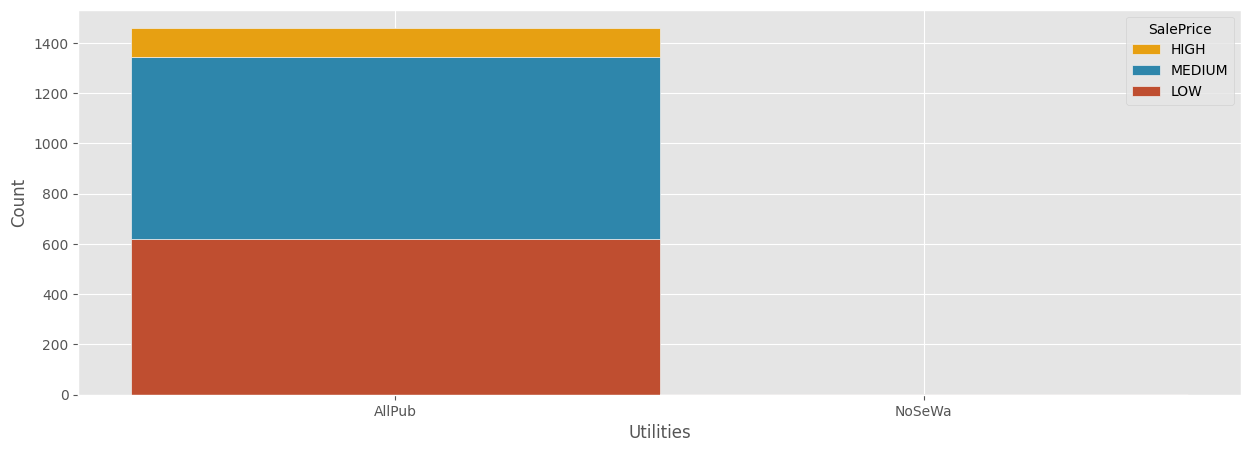

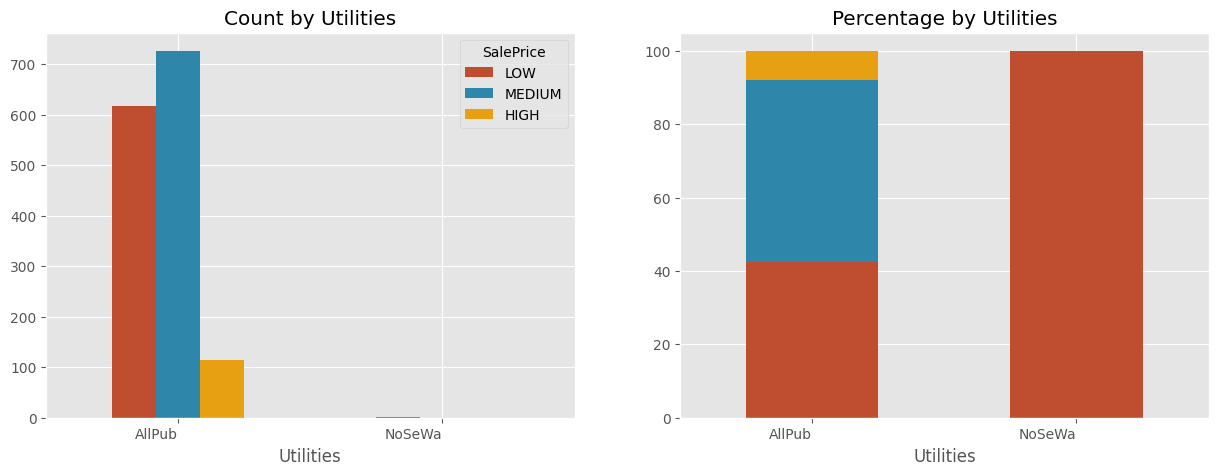

In [39]:
# All the houses (except one) have all the utilies
#Although it is considered to be a useful element, we cannot use this attribute.
category_common_analysis(data=df, x='Utilities',target='SalePrice', palette=palette)

##### LotConfig

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


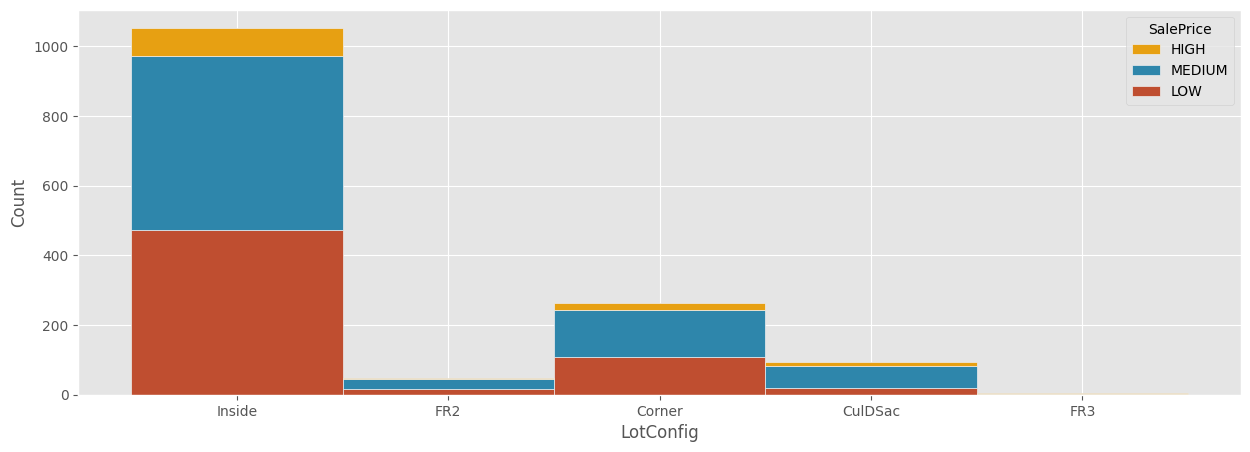

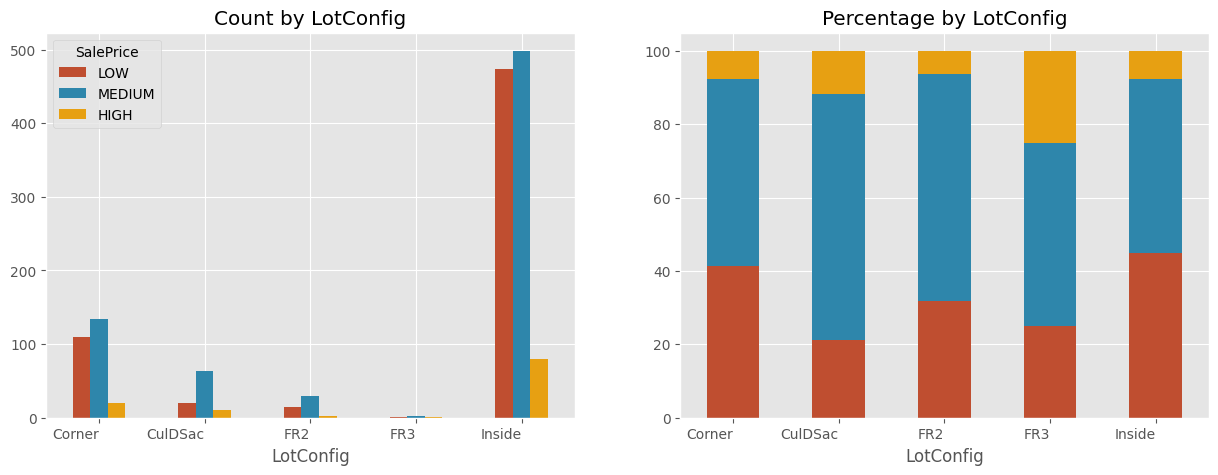

In [40]:
#it can be seen that for some values there are not enough sample, however it seems that the other attributes have a similar distribution
#The attribute can be removed since it would not be useful to the model

category_common_analysis(data=df, x='LotConfig',target='SalePrice', palette=palette)

##### LandSlope

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


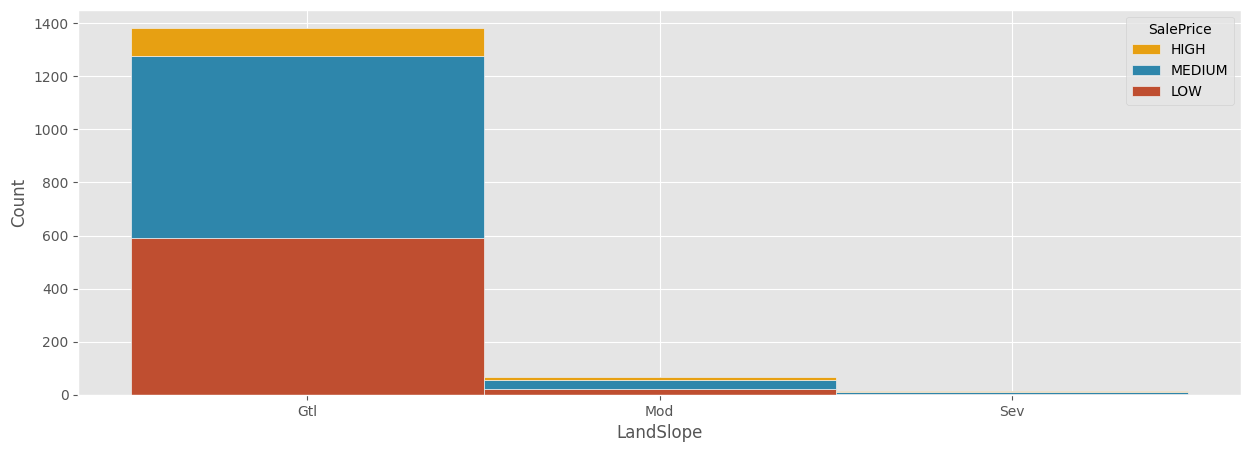

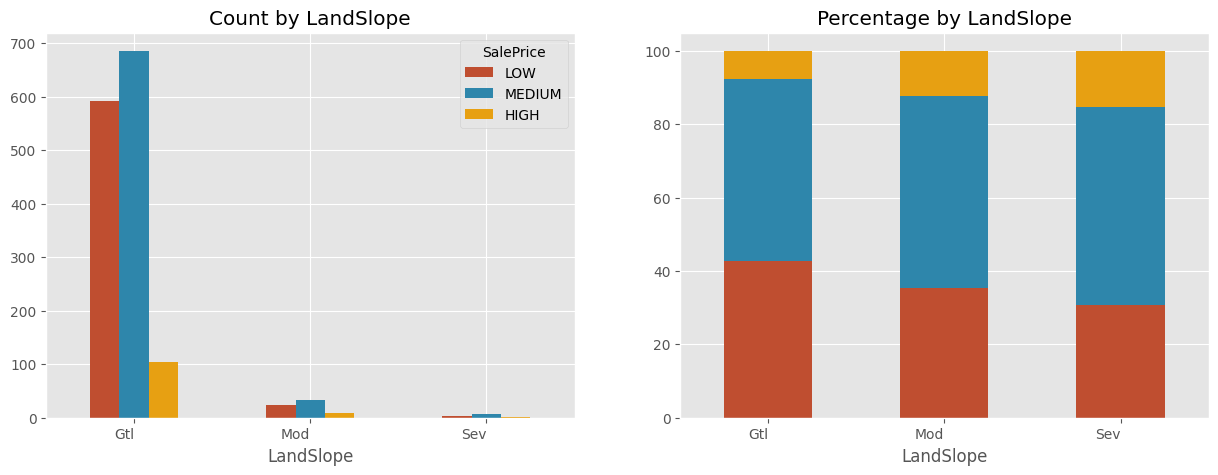

In [41]:
#la pendenza del terreno non dovrebbe influenzare il livello della proprietà
#Troppi pochi campioni
category_common_analysis(data=df, x='LandSlope',target='SalePrice', palette=palette)

##### Neighborhood

Null values: 0
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
Other       72
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Name: Neighborhood, dtype: int64
Understanding Neighborhood:
	Missing values: 0
	Independence Test: 4.65e-182[<0.05]
	Information Gain: 0.46
	When the Neighborhood is:
		• IDOTRR, then the sale price is 90% likely to be LOW (2.53% of the times)
		• Gilbert+NWAmes, then the sale price is 90% likely to be MEDIUM (10.41% of the times)
		• BrkSide+Edwards+OldTown, then the sale price is 80% likely to be LOW (18.56% of the times)
		• ClearCr+Somerst, then the sale price is 80% likely to be MEDIUM (7.81% of the times)
		• Sawyer, then the sale price is 75% likely to be LOW (5.07% of the times)
		• Timber, then the sale price is 75% likely to be MEDIUM (2.60% of the times)
		• CollgC

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


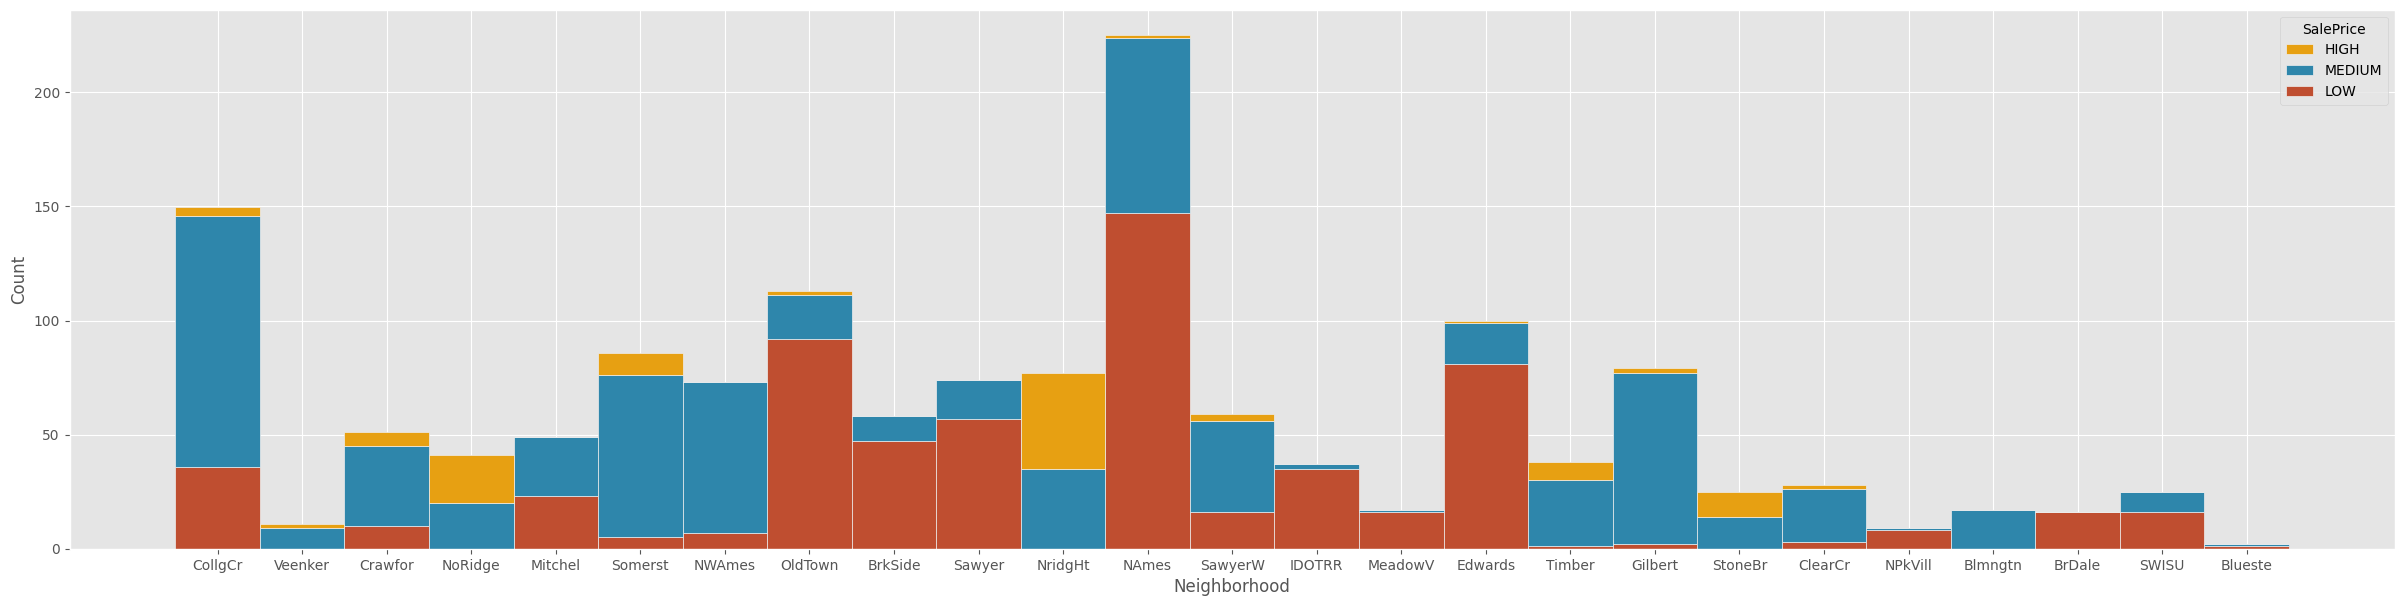

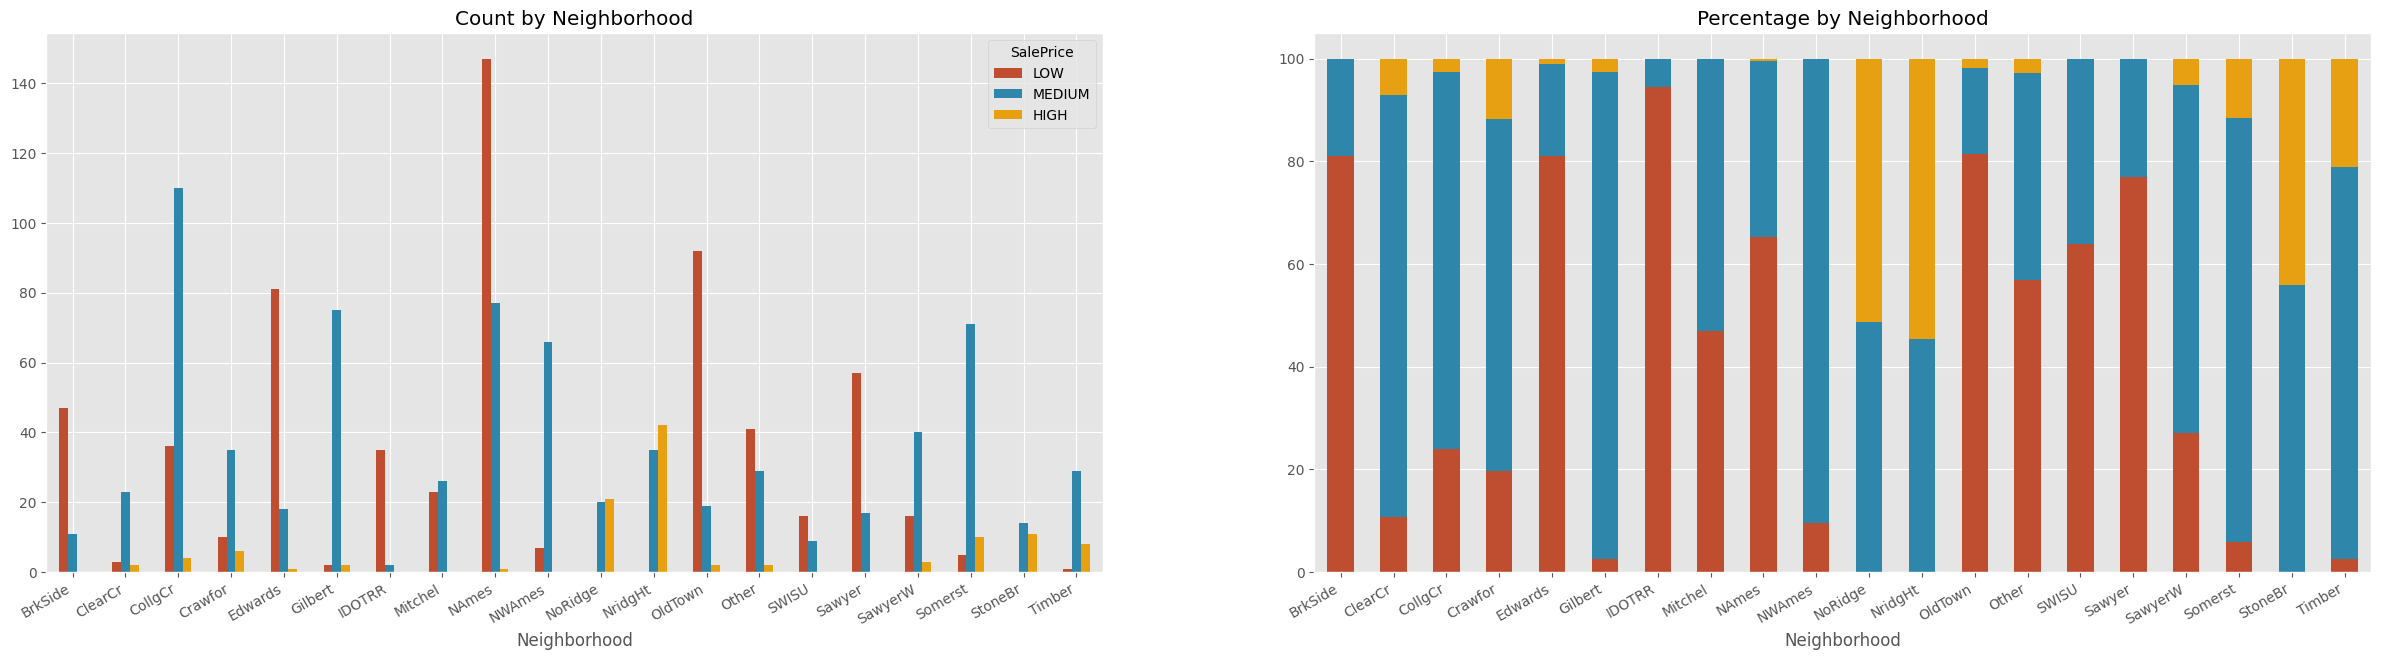

In [42]:
print(f"Null values: {df['Neighborhood'].isna().sum()}")
plt.figure(figsize = (30,7))
df_copy

sb.histplot(x = df['Neighborhood'], multiple='stack', hue = df.SalePrice,  data = df['Neighborhood'], hue_order = hue_order, palette = palette, alpha=1)
df_copy = aggregate(df = df_copy, attribute='Neighborhood', new_name="Other", threshold=20)
category_common_analysis(data=df_copy, x='Neighborhood',target='SalePrice', rotation=30, palette=palette, figsize=(30,7), histplot=False)
understand(dataf=df_copy, feature_name='Neighborhood',showplots=False)

##### Condition1

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64


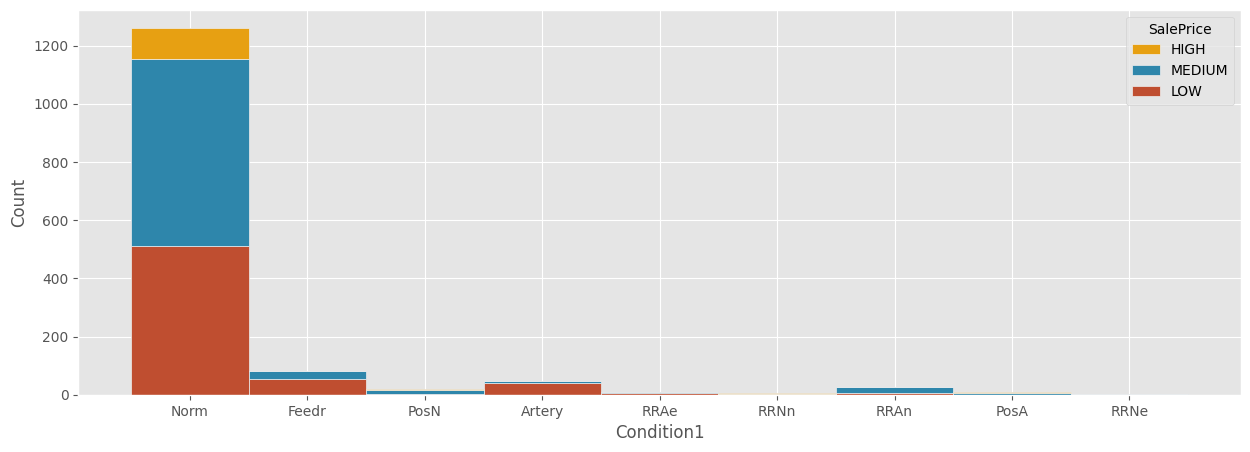

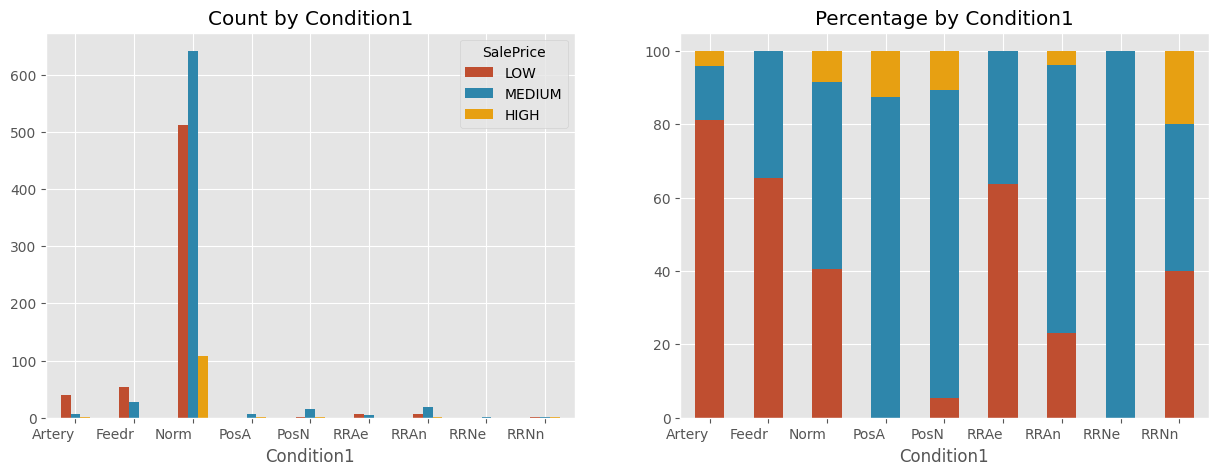

In [43]:
#The values for this attribute are strongly unbalanced among the categories inside the training set.
#As we can see from the barplot with percentages there is not a marked trend.
category_common_analysis(data=df, x='Condition1',target='SalePrice', palette=palette)

##### Condition2

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


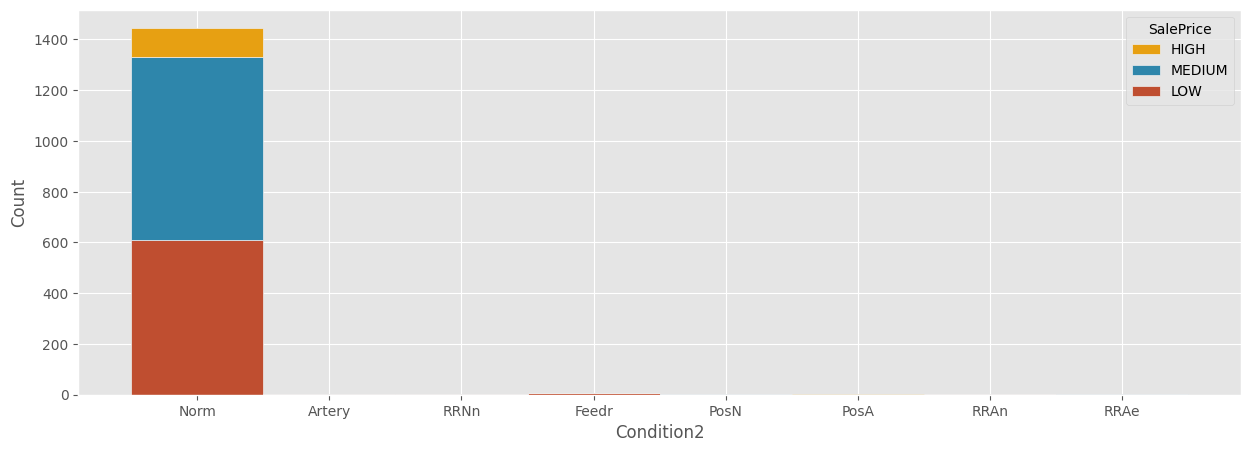

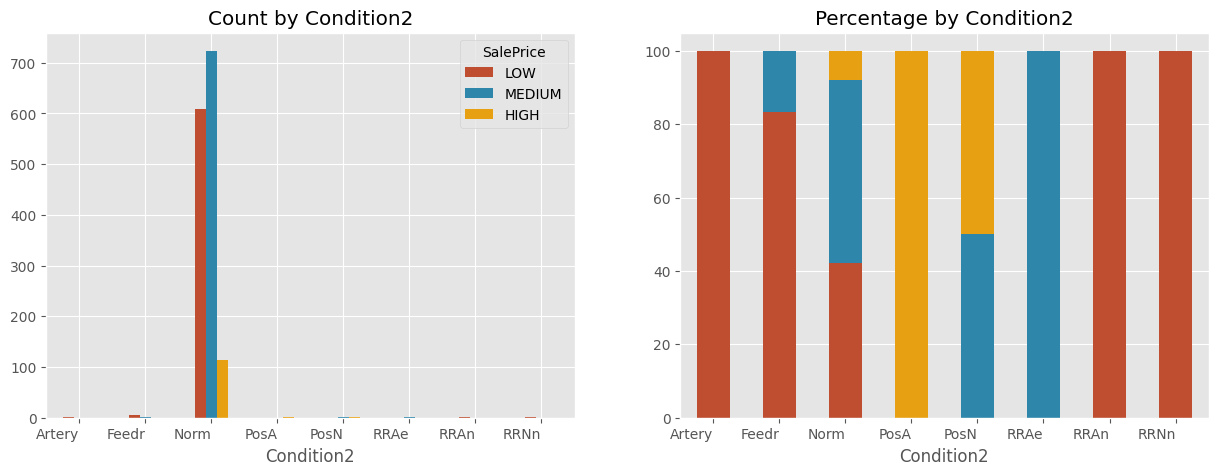

In [44]:
# Same reasoning as for Condition1
category_common_analysis(data=df, x='Condition2',target='SalePrice', palette=palette)

##### BldgType

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


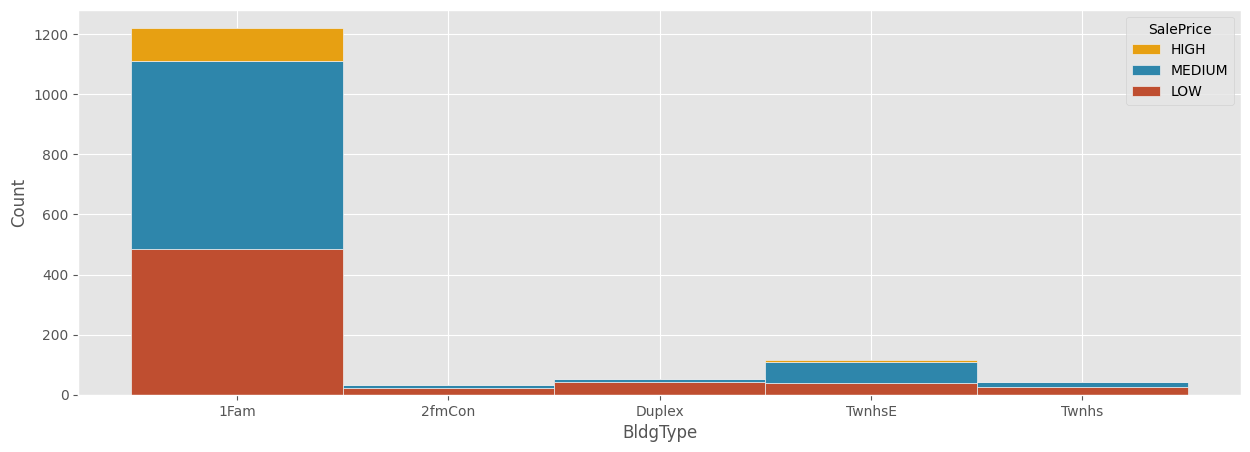

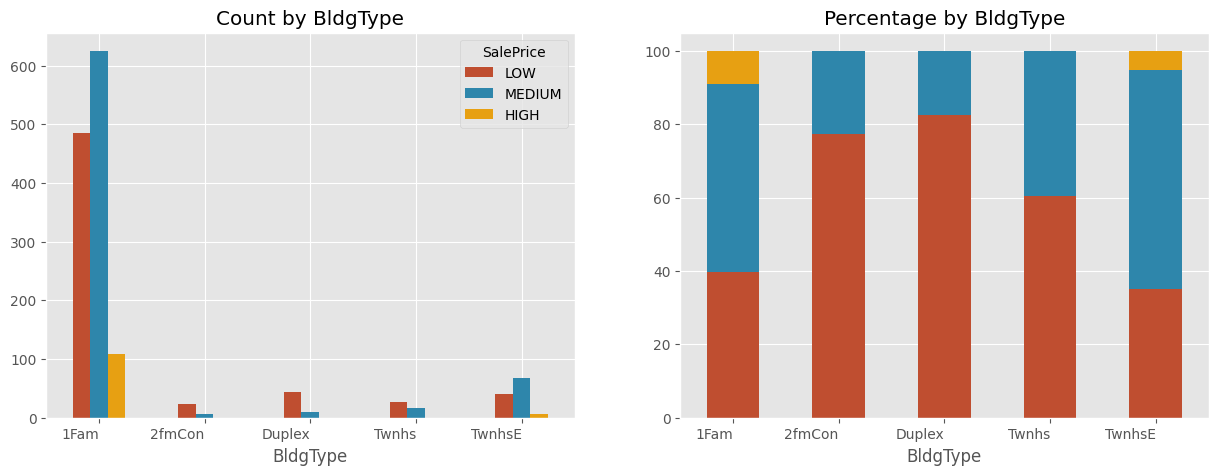

In [45]:
category_common_analysis(data=df, x='BldgType',target='SalePrice', palette=palette)

##### HouseStyle

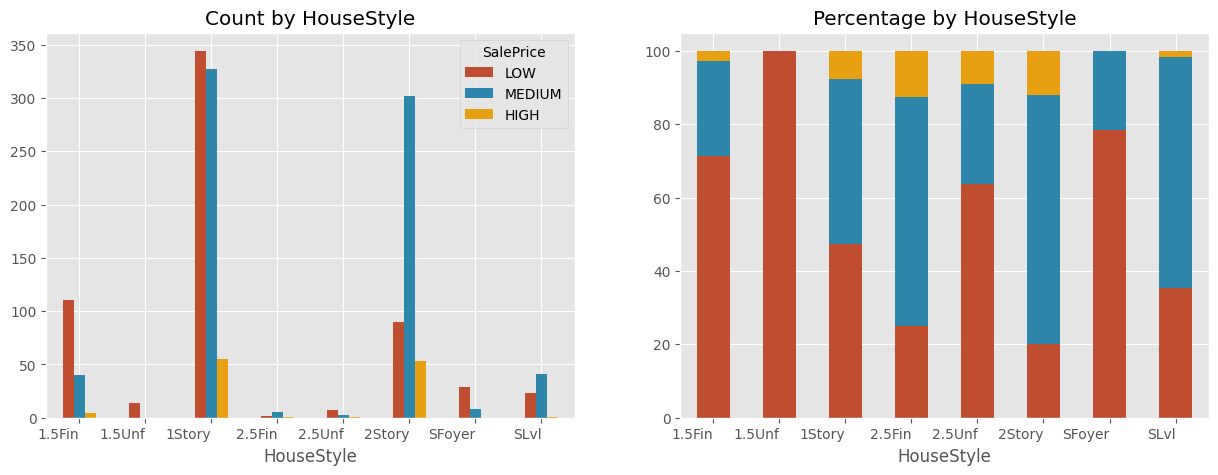

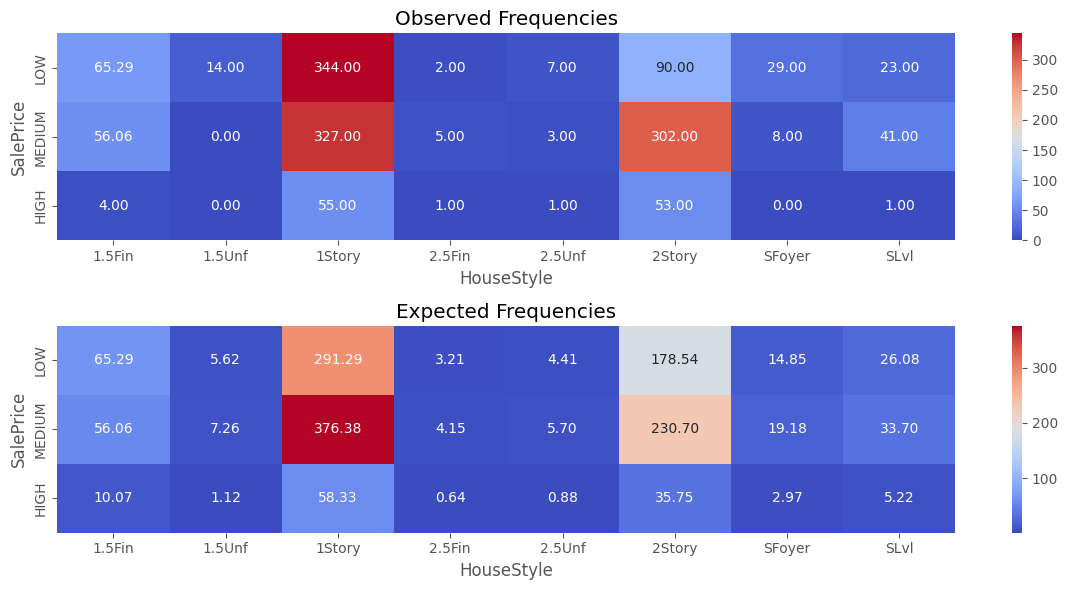

Chi-square Test - Outcome
P-Value: 5.042764923498675e-35 [<0.05]
Cramer's V - Outcome
Coeff: 0.26183088220958667
Understanding HouseStyle:
	Missing values: 0
	Independence Test: 5.04e-35[<0.05]
	Information Gain: 0.11
	When the HouseStyle is:
		• 1.5Unf, then the sale price is LOW (0.96% of the times)
		• SFoyer, then the sale price is 75% likely to be LOW (2.53% of the times)
		• 1.5Fin, then the sale price is 70% likely to be LOW (10.55% of the times)
		• 2Story, then the sale price is 65% likely to be MEDIUM (30.48% of the times)
		• 2.5Unf, then the sale price is 60% likely to be LOW (0.75% of the times)
		• 2.5Fin+SLvl, then the sale price is 60% likely to be MEDIUM (5.00% of the times)
		• 1Story, then the sale price is 45% likely to be LOW (49.73% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


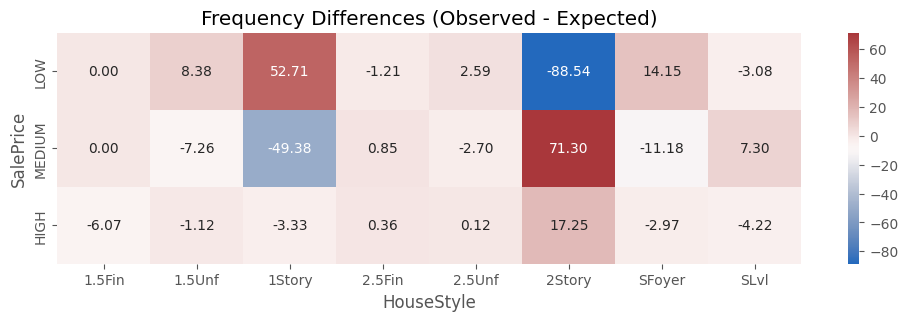

In [46]:
#As we can see from the plots here there is a significant correlation between the style of the house and the price.
#In particular, as the number of floors increases the SalePrice also increases
# category_common_analysis(data=df, x='HouseStyle',target='SalePrice', palette=palette, figsize=(30,7))
understand(dataf=df_copy, feature_name='HouseStyle')

##### OverallQual

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


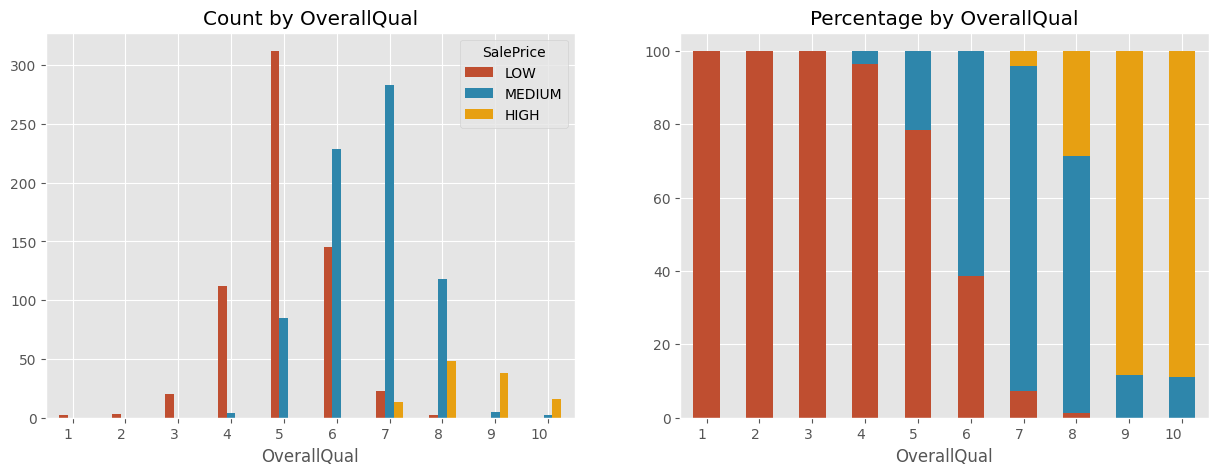

In [47]:
#In this case the trend is evident: the higher the overall quality of the house the higher the sale price
print(df['OverallQual'].value_counts())
frequencies_and_percentages(df, 'SalePrice', 'OverallQual')

##### OverallCond

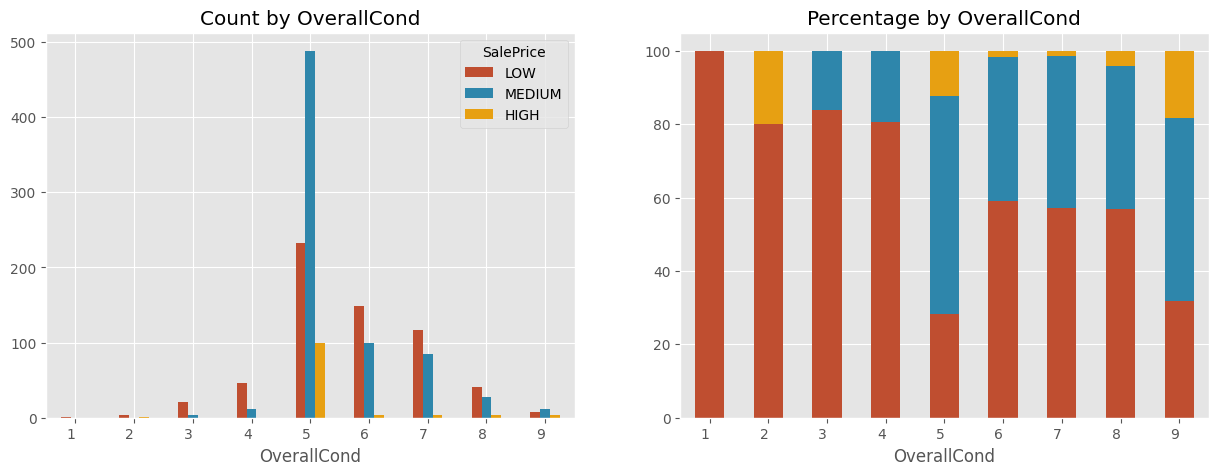

In [48]:
#In this case the trend is not so marked and probably is conditioned by the fact that
#of the houses are spread across only three of the nine possible values for this attribute
frequencies_and_percentages(df, 'SalePrice', 'OverallCond')

##### YearBuilt

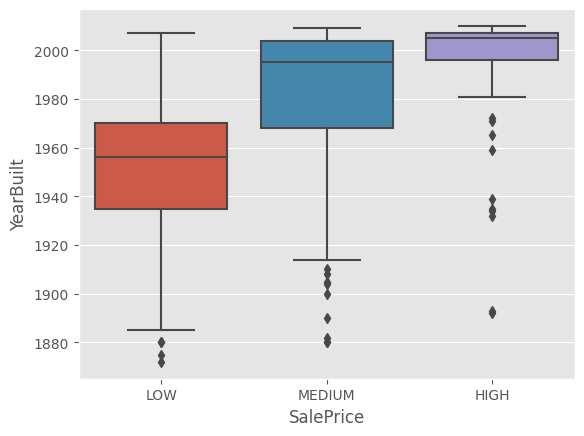

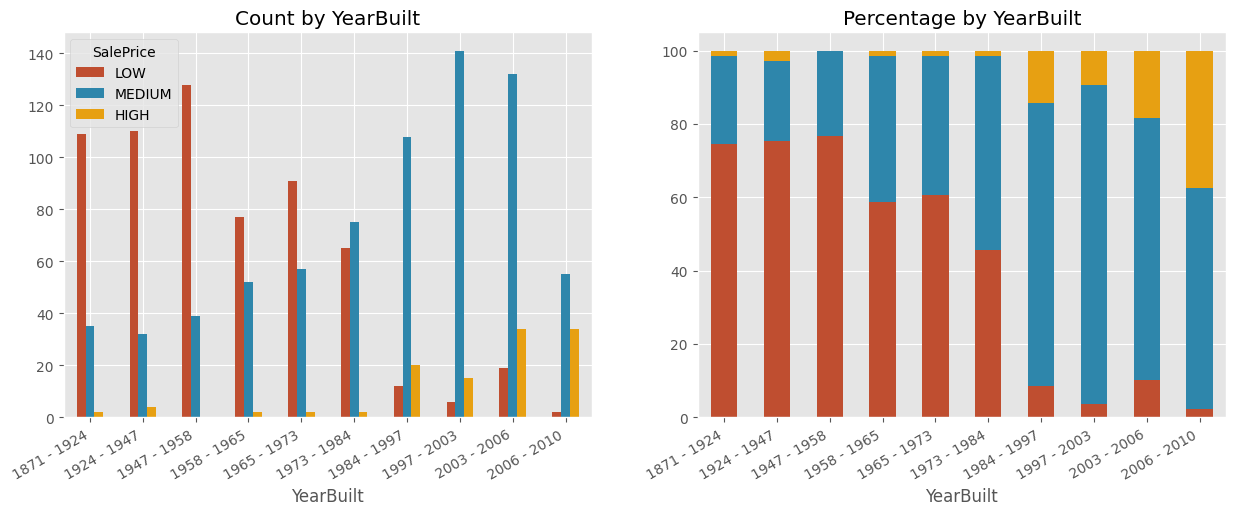

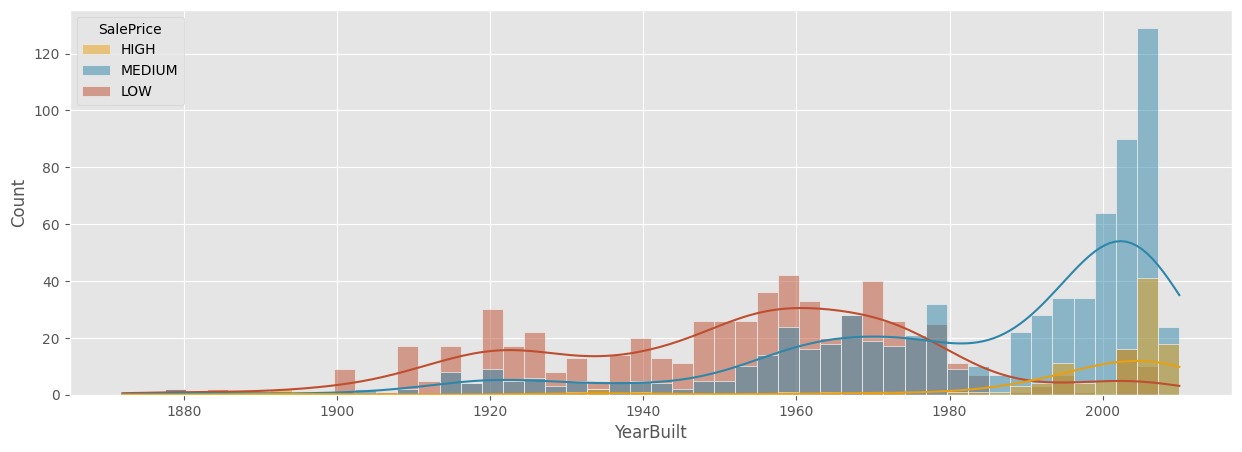

Understanding YearBuilt:
	Missing values: 0
	Independence Test: 3.64e-118[<0.05]
	Correlation Index: 0.52
	Correlation p_value: 2.99e-103



In [49]:
#As we can see, the older the house the lower the associated SalePrice.
#Moreover, for this attribute we do not have higly skewed or non uniform distribution like we had for several other attributes
sb.boxplot(data=df, y="YearBuilt", x="SalePrice")
frequencies_and_percentages_numeric(df, 'SalePrice', 'YearBuilt', rotation=30, bin=10)
understand(dataf=df_copy, feature_name='YearBuilt', dtype='int', low_limit=1900, upper_limit=2023)

##### YearRemodAdd

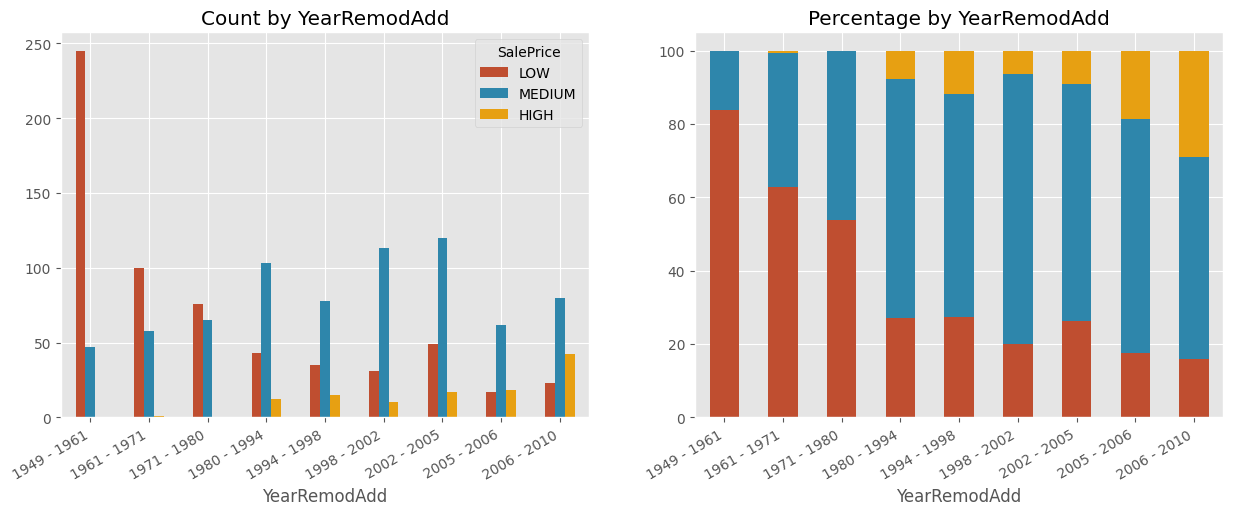

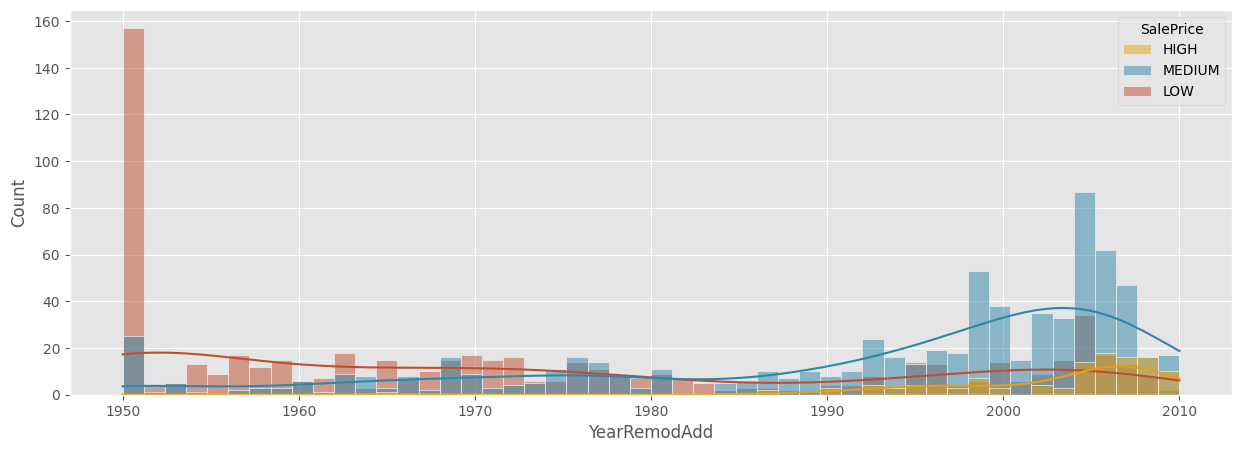

Understanding YearRemodAdd:
	Missing values: 0
	Independence Test: 1.79e-103[<0.05]
	Correlation Index: 0.51
	Correlation p_value: 3.16e-96



In [50]:

frequencies_and_percentages_numeric(df, 'SalePrice', 'YearRemodAdd', rotation=30, bin = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
understand(dataf=df_copy, feature_name='YearRemodAdd', dtype='int', low_limit=1900, upper_limit=2023)

##### RoofStyle

Gable    1141
Hip       286
Other      33
Name: RoofStyle, dtype: int64
Understanding RoofStyle:
	Missing values: 0
	Independence Test: 7.76e-17[<0.05]
	Information Gain: 0.04
	When the RoofStyle is:
		• Shed, then the sale price is MEDIUM (0.14% of the times)
		• Mansard, then the sale price is 70% likely to be MEDIUM (0.48% of the times)
		• Flat, then the sale price is 65% likely to be MEDIUM (0.89% of the times)
		• Gable, then the sale price is 50% likely to be MEDIUM (78.15% of the times)
		• Gambrel, then the sale price is 50% likely to be LOW (0.75% of the times)
		• Hip, then the sale price is 40% likely to be MEDIUM (19.59% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


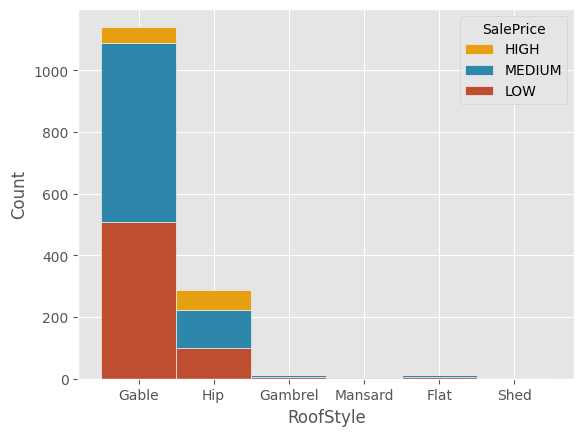

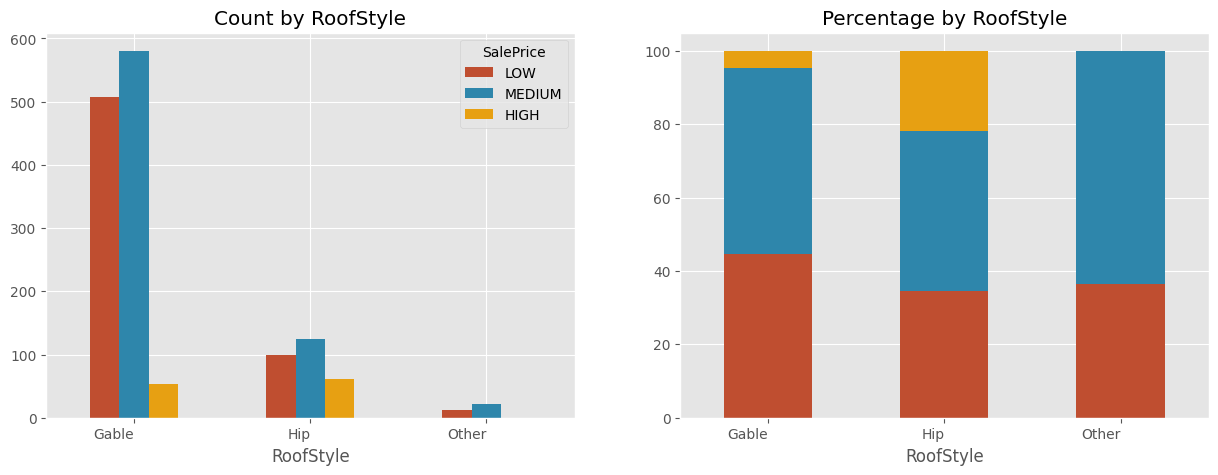

In [51]:
sb.histplot(x = df['RoofStyle'], multiple='stack', hue = df.SalePrice,  data = df['RoofStyle'], hue_order = hue_order, palette = palette, alpha=1)
category_common_analysis(data=aggregate(df = df.copy(), attribute='RoofStyle', new_name="Other", threshold=20), x='RoofStyle', histplot=False,target='SalePrice', palette=palette)
understand(dataf=df_copy, feature_name='RoofStyle', dtype='category', showplots=False)

##### RoofMatl

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64
Understanding RoofMatl:
	Missing values: 0
	Independence Test: 1.93e-02[<0.05]
	Information Gain: 0.01
	When the RoofMatl is:
		• Roll, then the sale price is LOW (0.07% of the times)
		• ClyTile+Membran+Metal+WdShake, then the sale price is MEDIUM (0.55% of the times)
		• Tar&Grv, then the sale price is 60% likely to be MEDIUM (0.75% of the times)
		• WdShngl, then the sale price is 50% likely to be MEDIUM (0.41% of the times)
		• CompShg, then the sale price is 45% likely to be MEDIUM (98.22% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


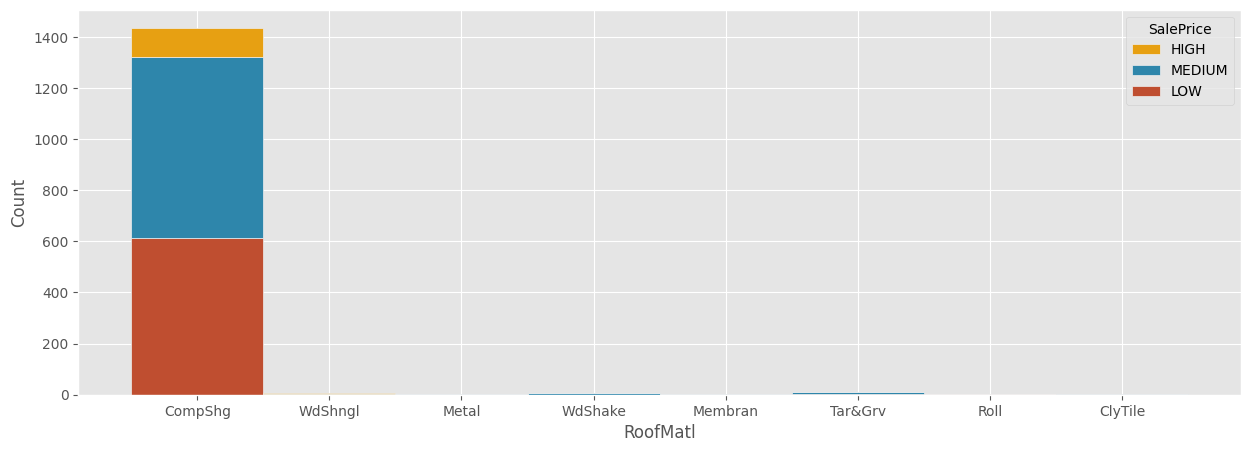

In [52]:
# Not useful
category_common_analysis(data=df, x='RoofMatl',target='SalePrice', percentages=False, palette=palette)
understand(dataf=df_copy, feature_name='RoofMatl', dtype='category', showplots=False)

##### Exterior1st & Exterior2nd

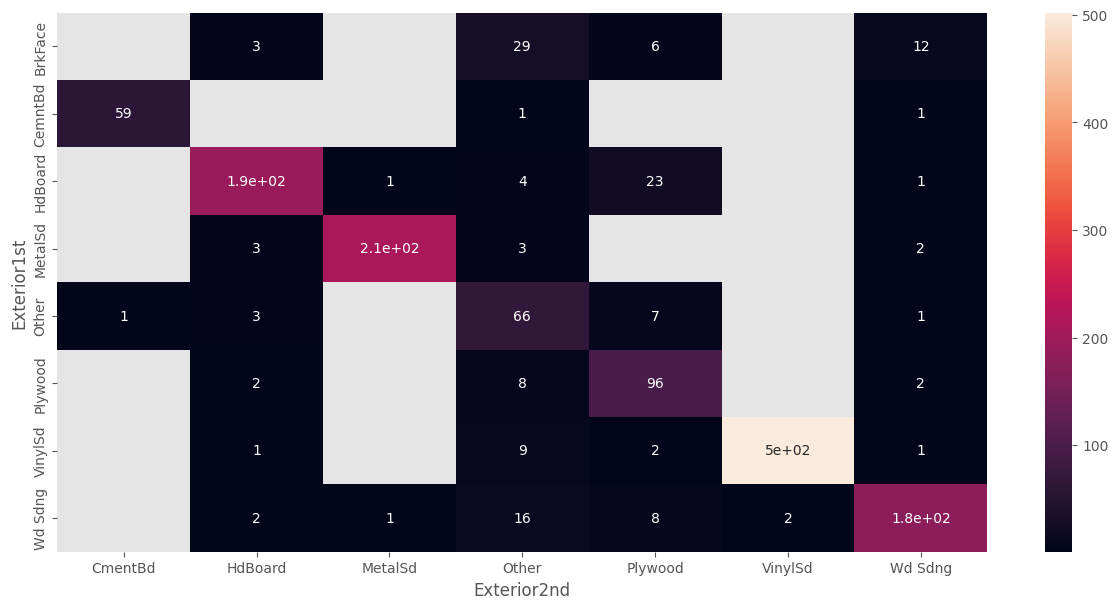

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
Other       78
CemntBd     61
BrkFace     50
Name: Exterior1st, dtype: int64
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
Other      136
CmentBd     60
Name: Exterior2nd, dtype: int64


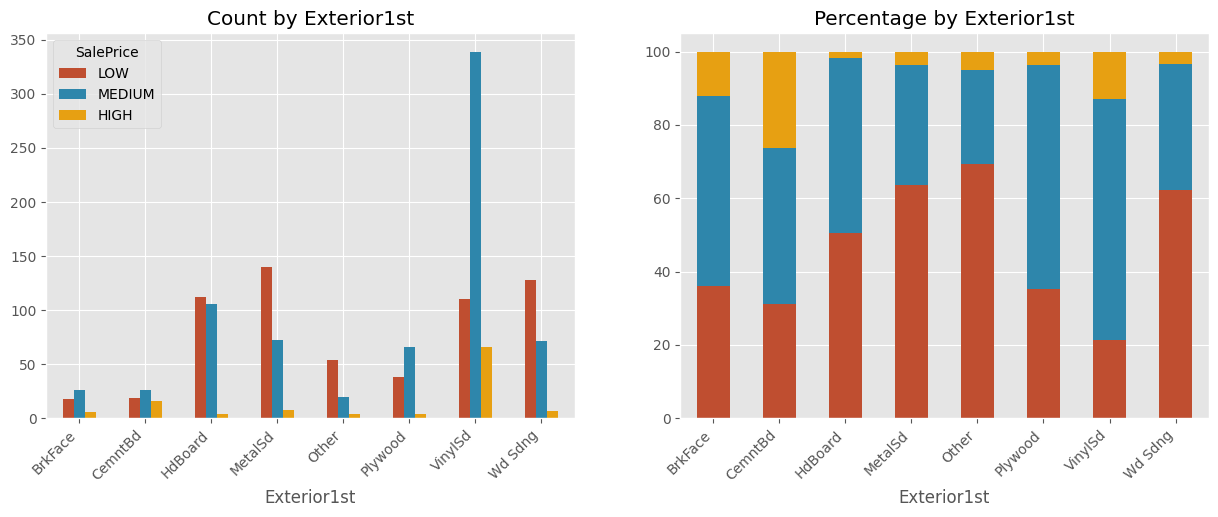

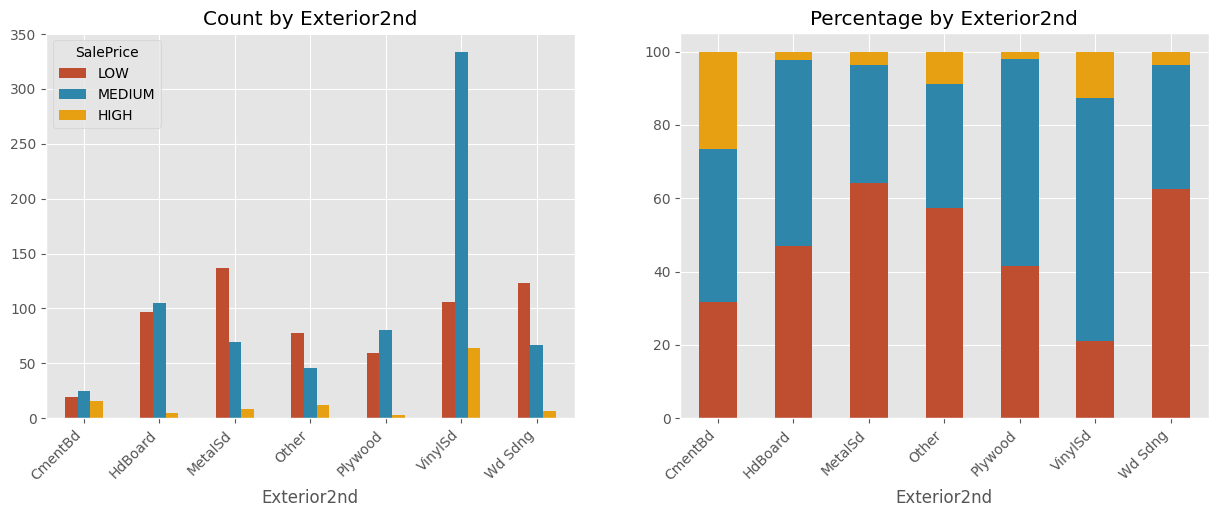

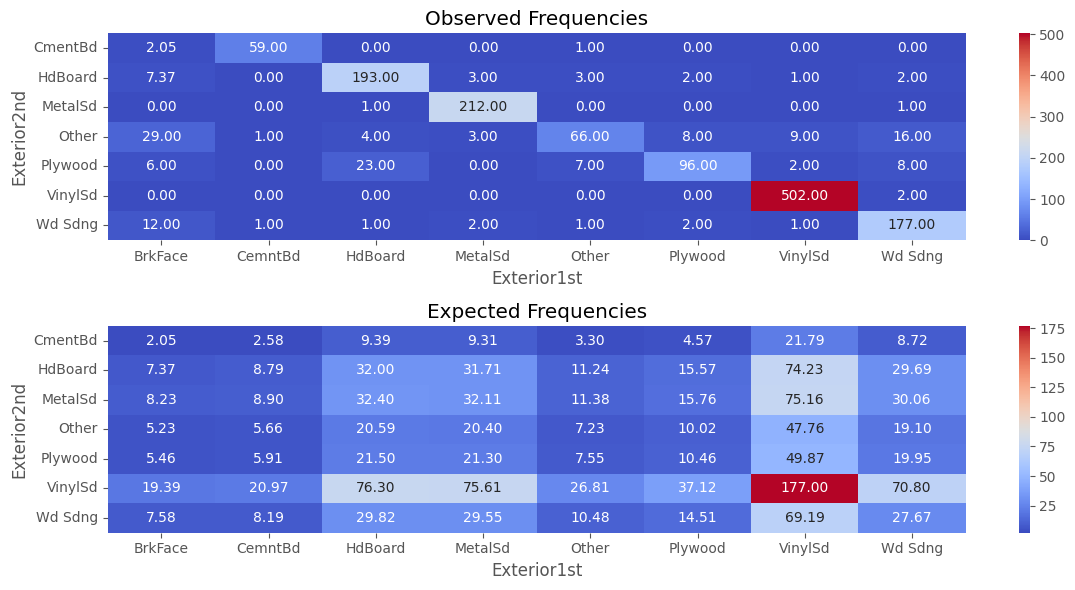

Chi-square Test - Outcome
P-Value: 0.0 [<0.05]
Cramer's V - Outcome
Coeff: 0.8808924627000861


(0.0, '[<0.05]')

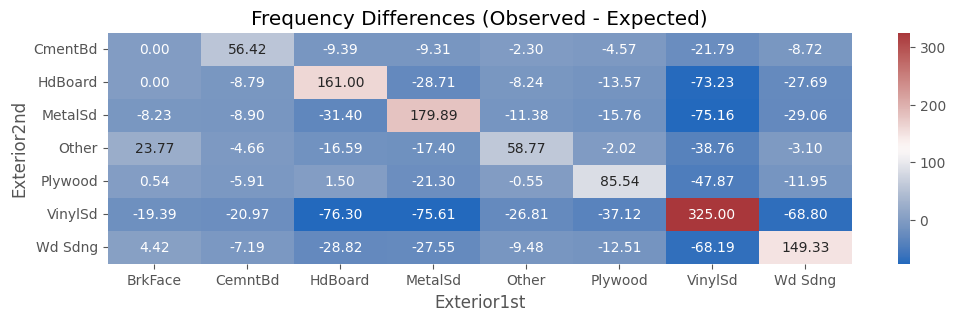

In [53]:
# sb.histplot(x = df["Exterior1st"], multiple='stack', hue = 'SalePrice',  data = df, hue_order = hue_order, palette = palette, alpha=1, ax=ax[0])
# sb.histplot(x = df["Exterior2nd"], multiple='stack', hue = 'SalePrice',  data = df, hue_order = hue_order, palette = palette, alpha=1, ax=ax[1])
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
# ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

#Basically they are too similar to each other
df_copy = aggregate(df_copy, new_name="Other", threshold=40, attribute="Exterior1st")
df_copy = aggregate(df=df_copy , new_name="Other", threshold=40, attribute="Exterior2nd")
plt.figure(figsize = (15,7))
df_heatmap =  df_copy[['Exterior1st','Exterior2nd']].pivot_table(index='Exterior1st',columns='Exterior2nd',aggfunc=len)
sb.heatmap(df_heatmap,annot=True)
plt.show()
category_common_analysis(data=df_copy, x='Exterior1st',target='SalePrice', histplot=False, palette=palette,rotation=45, figsize=(15, 5))
category_common_analysis(data=df_copy, x='Exterior2nd',target='SalePrice', histplot=False, palette=palette,rotation=45, figsize=(15, 5))
stattest_quali(df=df_copy, target='Exterior2nd', feature_name='Exterior1st')

##### MasVnrType

None       864
BrkFace    445
Stone      128
BrkCmn      15
NA           8
Name: MasVnrType, dtype: int64


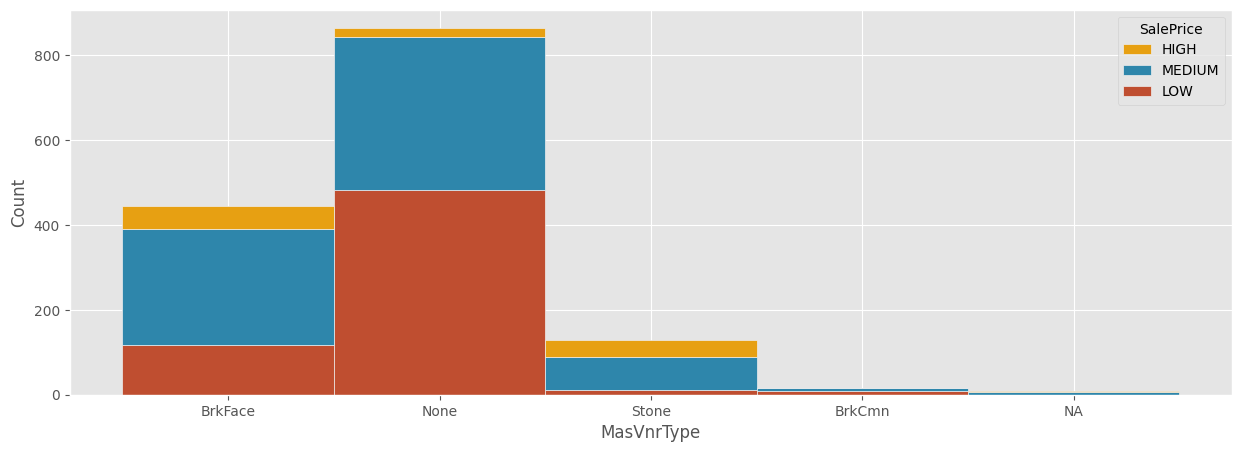

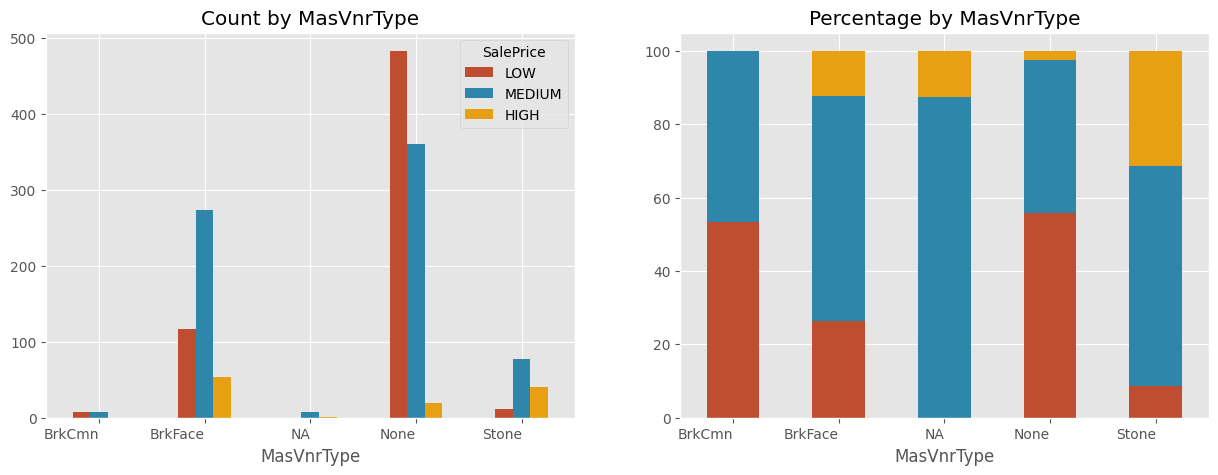

In [54]:
# Na are only 8 elements and they correspond to unknown
# Stone and None are significant respectively to High and Low
#We suggest to change the 8 elements with None, since they are very few
category_common_analysis(data=df, x='MasVnrType',target='SalePrice', percentages=True, palette=palette)

##### MasVnrArea

        Id MasVnrArea MasVnrType
234    235         NA         NA
529    530         NA         NA
650    651         NA         NA
936    937         NA         NA
973    974         NA         NA
977    978         NA         NA
1243  1244         NA         NA
1278  1279         NA         NA
Empty DataFrame
Columns: [Id, MasVnrArea, MasVnrType]
Index: []
Empty DataFrame
Columns: [Id, MasVnrArea, MasVnrType]
Index: []


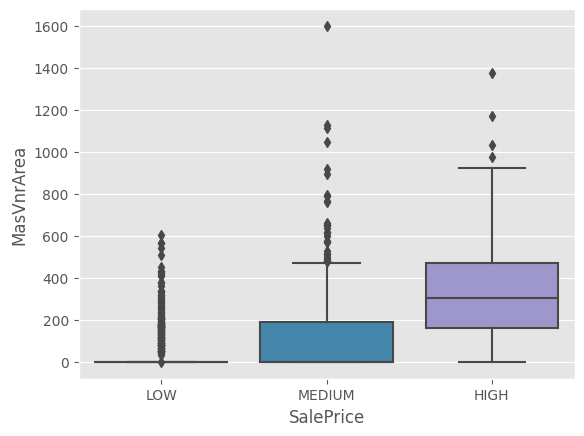

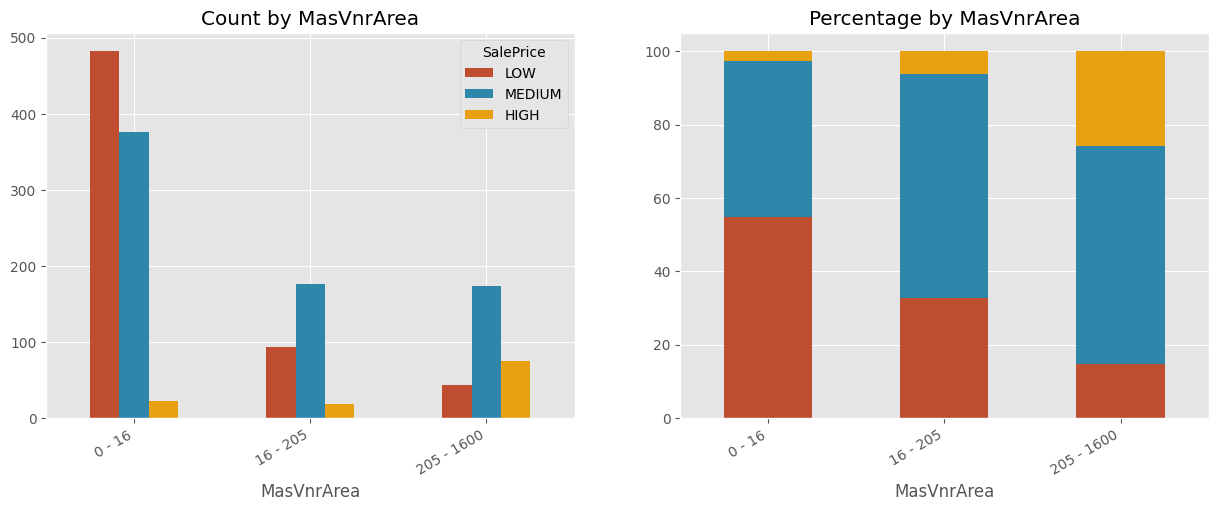

In [55]:
#The 8 NA values of MasVnrType have no Mas, then also this is Na, we can insert 0 (without changing the original data frame)
#by default in order to understand better the data
#We thing that the interaction between MasVnrType and MasVnrArea could be relevant
#We change the type to numeric
print(df_copy[df_copy["MasVnrArea"]  == "NA"][["Id","MasVnrArea","MasVnrType"]])
for i,e in df_copy.iterrows():
    if e["MasVnrArea"]=="NA":
        df_copy.at[i, "MasVnrArea"] = 0
print(df_copy[df_copy["MasVnrArea"]  == "NA"][["Id","MasVnrArea","MasVnrType"]])
df_copy["MasVnrArea"] = df_copy["MasVnrArea"].astype("int64")
print(df_copy[df_copy["MasVnrArea"]  < 0][["Id","MasVnrArea","MasVnrType"]])
sb.boxplot(data=df_copy, y="MasVnrArea", x="SalePrice")
frequencies_and_percentages_numeric(df_copy, 'SalePrice', 'MasVnrArea', rotation=30, bin=[0, 0.6, 0.8, 1])


##### ExterQual & ExterCond

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64
Understanding ExterQual:
	Missing values: 0
	Independence Test: 4.53e-164[<0.05]
	Information Gain: 0.34
	When the ExterQual is:
		• Fa, then the sale price is 90% likely to be LOW (0.96% of the times)
		• Ex, then the sale price is 75% likely to be HIGH (3.56% of the times)
		• Gd, then the sale price is 75% likely to be MEDIUM (33.42% of the times)
		• TA, then the sale price is 60% likely to be LOW (62.05% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


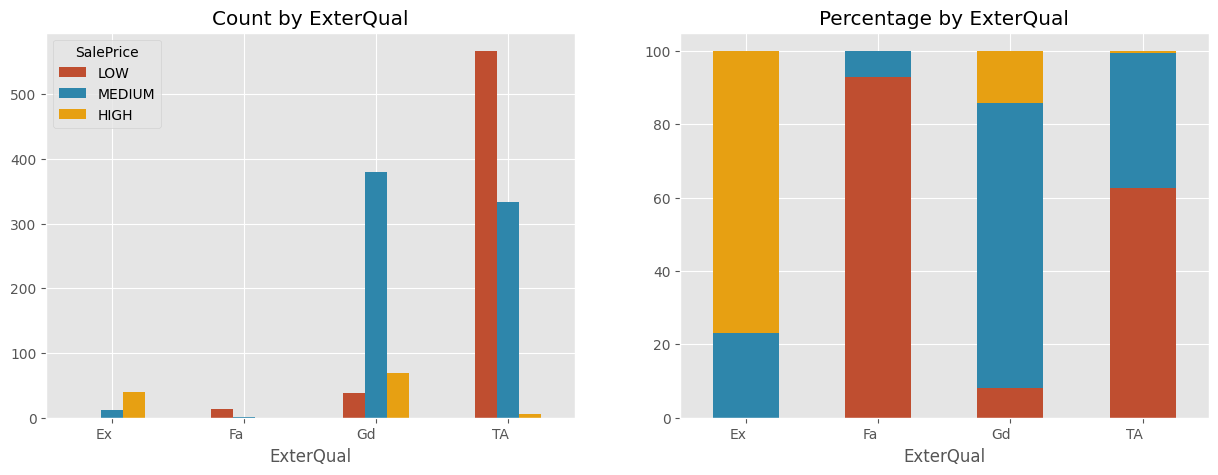

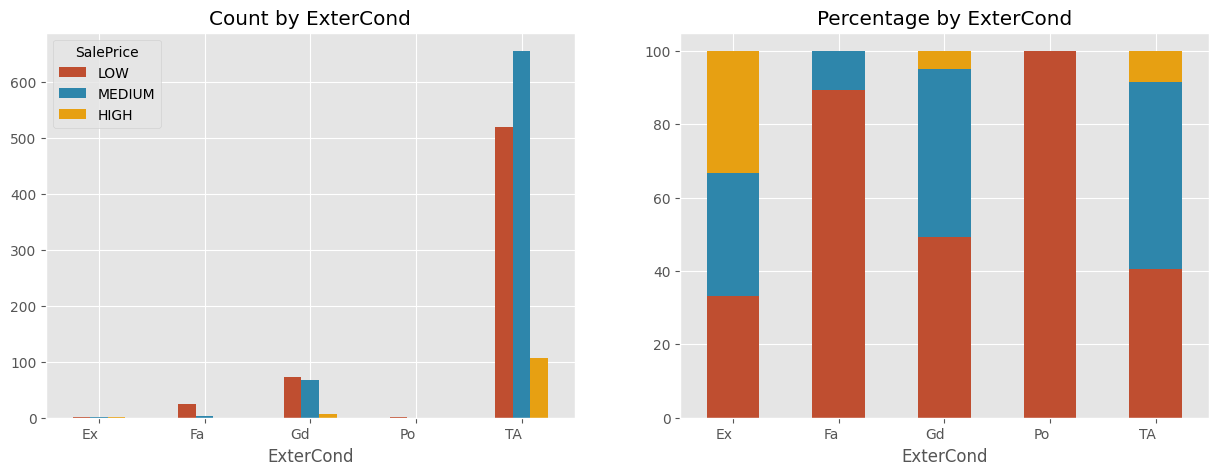

In [56]:
category_common_analysis(data=df, x='ExterQual',target='SalePrice', histplot=False, palette=palette)
category_common_analysis(data=df, x='ExterCond',target='SalePrice', histplot=False, palette=palette)
understand(dataf=df_copy, feature_name='ExterQual', showplots=False)

##### Foundation

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64
Understanding Foundation:
	Missing values: 0
	Independence Test: 2.20e-81[<0.05]
	Information Gain: 0.22
	When the Foundation is:
		• Slab, then the sale price is 90% likely to be LOW (1.64% of the times)
		• BrkTil, then the sale price is 70% likely to be LOW (10.00% of the times)
		• Stone, then the sale price is 65% likely to be LOW (0.41% of the times)
		• PConc+Wood, then the sale price is 65% likely to be MEDIUM (44.52% of the times)
		• CBlock, then the sale price is 60% likely to be LOW (43.42% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


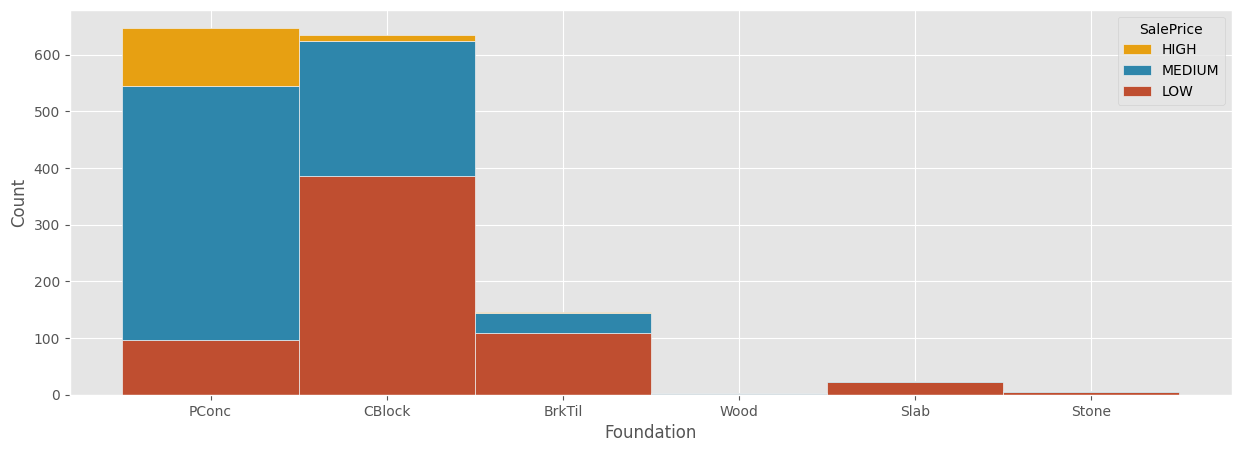

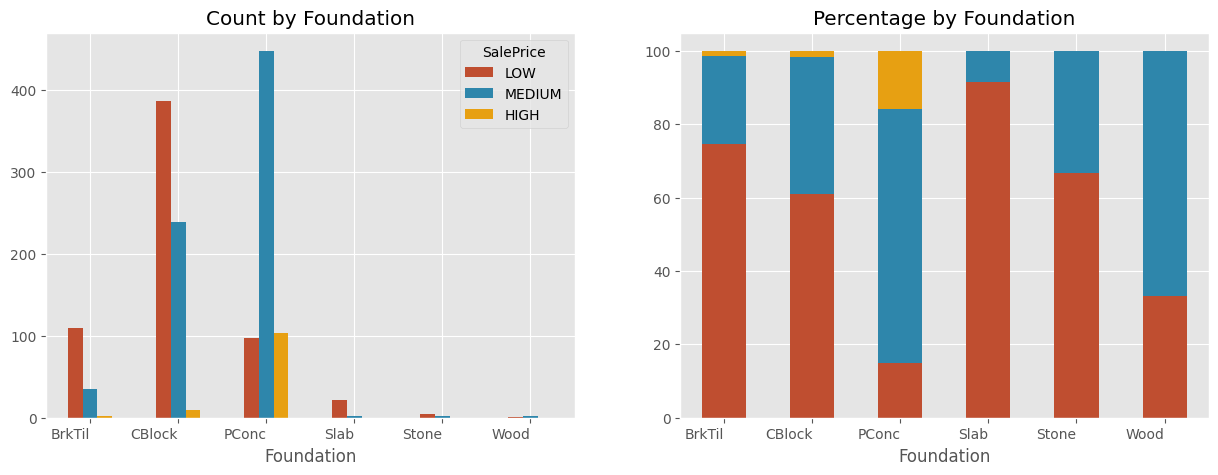

In [57]:
#insert other for wood, slab and stone
category_common_analysis(data=df, x='Foundation',target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='Foundation', showplots=False)

##### BsmtQual

TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64
Understanding BsmtQual:
	Missing values: 37
	Independence Test: 1.70e-200[<0.05]
	Information Gain: 0.38
	When the BsmtQual is:
		• NA, then the sale price is 90% likely to be LOW (2.53% of the times)
		• Fa, then the sale price is 85% likely to be LOW (2.40% of the times)
		• Gd, then the sale price is 75% likely to be MEDIUM (42.33% of the times)
		• TA, then the sale price is 65% likely to be LOW (44.45% of the times)
		• Ex, then the sale price is 60% likely to be HIGH (8.29% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


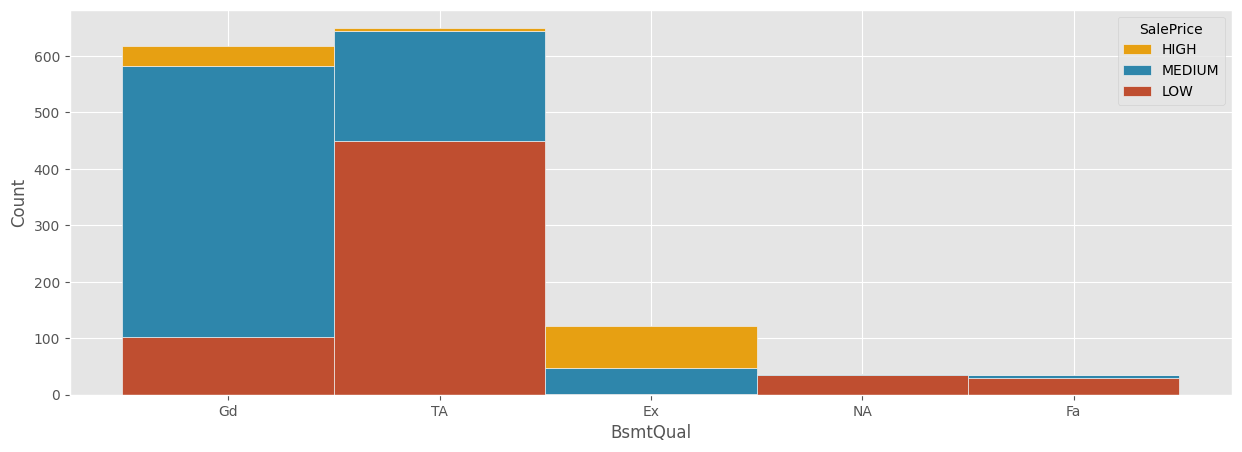

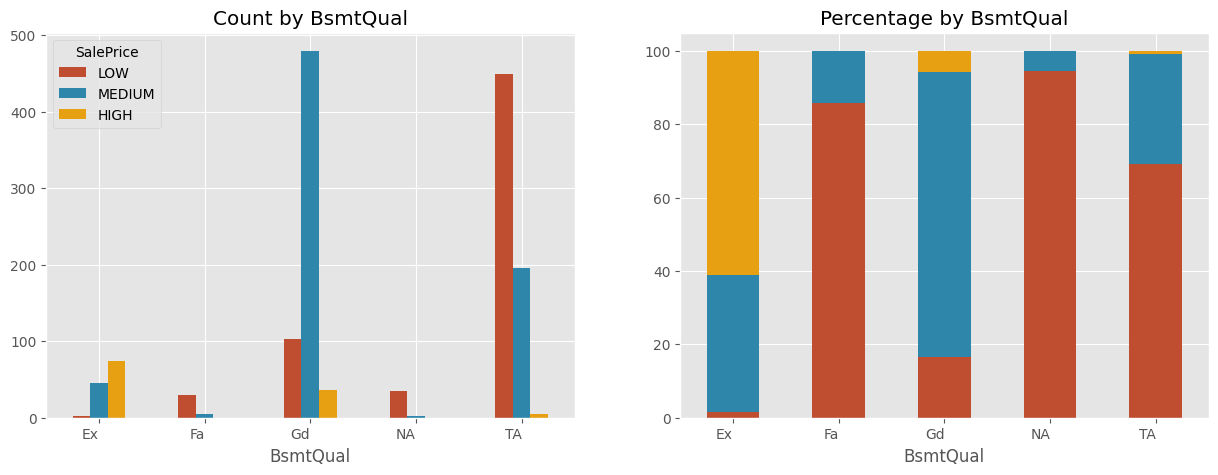

In [58]:
#insert other for wood, slab and stone
category_common_analysis(data=df, x='BsmtQual',target='SalePrice', percentages=True, palette=palette)
df[ (df["SalePrice"]=="HIGH")]["BsmtQual"].value_counts()
understand(dataf=df_copy, feature_name='BsmtQual', showplots=False)

##### BsmtCond

TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64


TA    107
Gd      8
Name: BsmtCond, dtype: int64

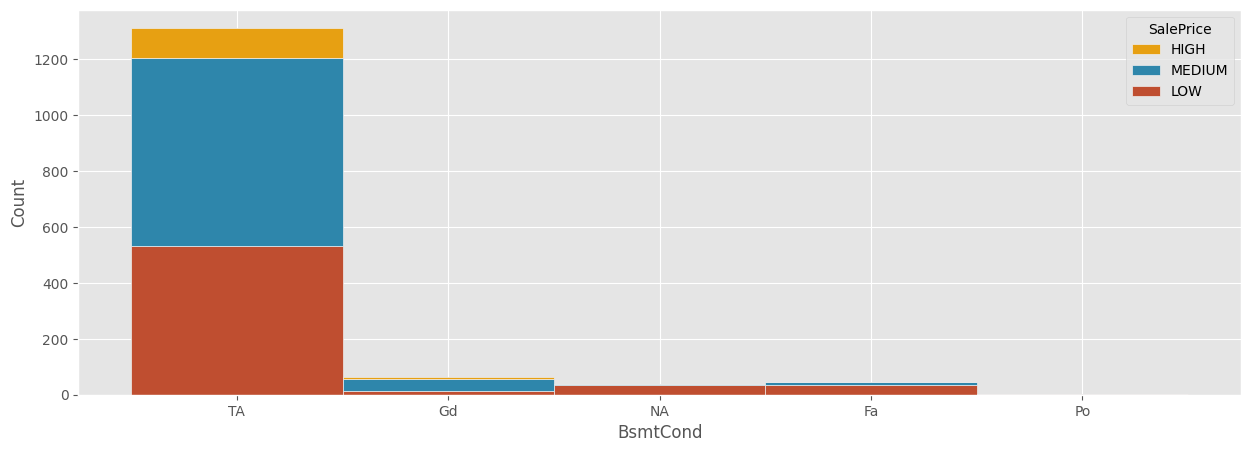

In [59]:
#Not useful, one element gather all the informations, too few elements for the other classes
category_common_analysis(data=df, x='BsmtCond',target='SalePrice', percentages=False, palette=palette)
df[ (df["SalePrice"]=="HIGH")]["BsmtCond"].value_counts()

##### BsmtExposure

SalePrice     LOW  MEDIUM  HIGH
BsmtExposure                   
Av             66     126    29
Gd             23      71    40
Mn             36      67    11
NA             35       3     0
No            459     459    35


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Understanding BsmtExposure:
	Missing values: 38
	Independence Test: 1.10e-37[<0.05]
	Information Gain: 0.09
	When the BsmtExposure is:
		• NA, then the sale price is 90% likely to be LOW (2.60% of the times)
		• Av+Mn, then the sale price is 55% likely to be MEDIUM (22.95% of the times)
		• Gd, then the sale price is 50% likely to be MEDIUM (9.18% of the times)
		• No, then the sale price is 45% likely to be LOW (65.27% of the times)




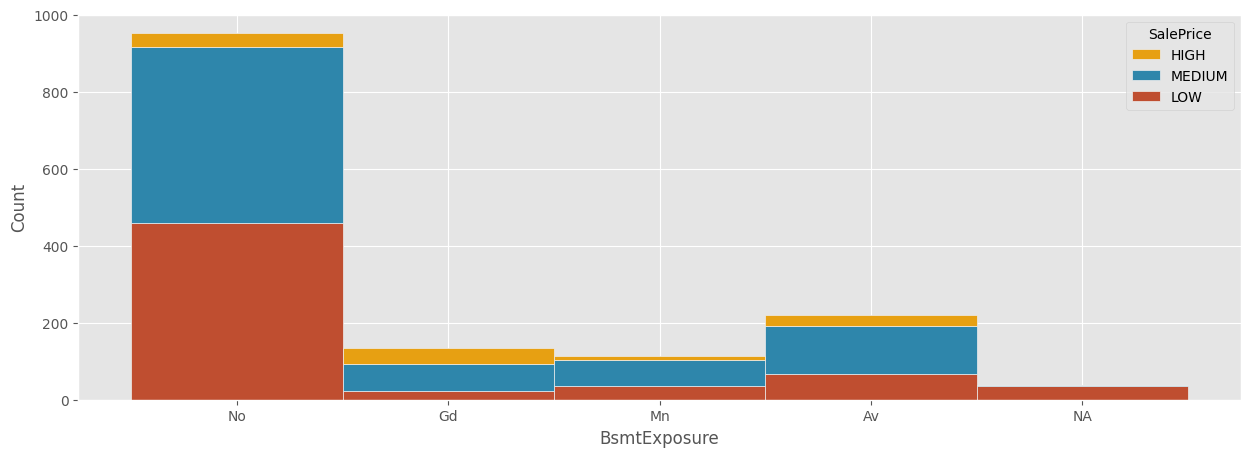

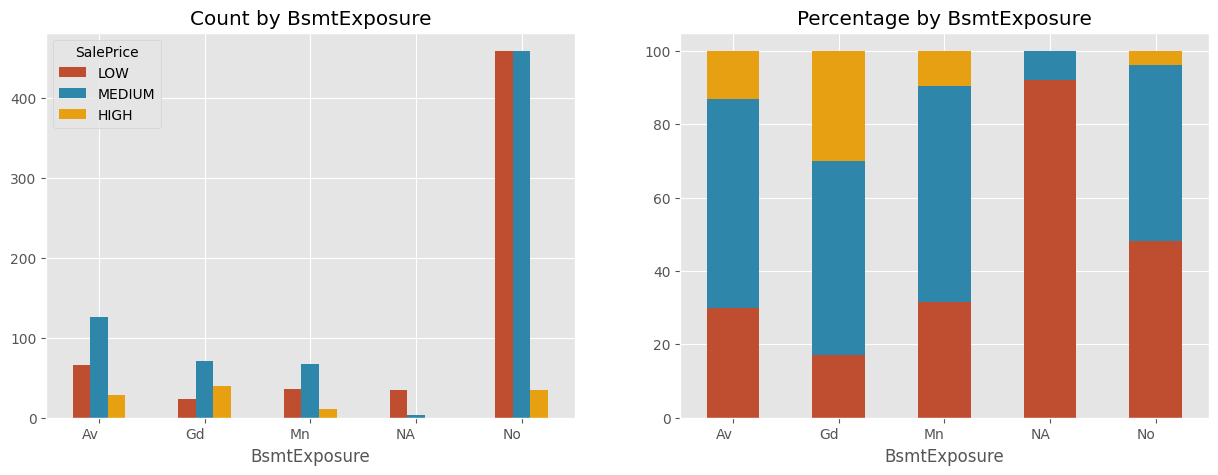

In [60]:

print(df[["BsmtExposure","SalePrice"]].pivot_table(index = "BsmtExposure" , columns=["SalePrice"],  aggfunc=len, fill_value=0))
category_common_analysis(data=df,x='BsmtExposure', display= False, target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='BsmtExposure', showplots=False)

##### BsmtFinType1

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Understanding BsmtFinType1:
	Missing values: 37
	Independence Test: 3.52e-57[<0.05]
	Information Gain: 0.16
	When the BsmtFinType1 is:
		• NA, then the sale price is 90% likely to be LOW (2.53% of the times)
		• GLQ, then the sale price is 60% likely to be MEDIUM (28.63% of the times)
		• BLQ+LwQ, then the sale price is 60% likely to be LOW (15.21% of the times)
		• Rec, then the sale price is 55% likely to be LOW (9.11% of the times)
		• ALQ, then the sale price is 50% likely to be LOW (15.07% of the times)
		• Unf, then the sale price is 50% likely to be MEDIUM (29.45% of the times)




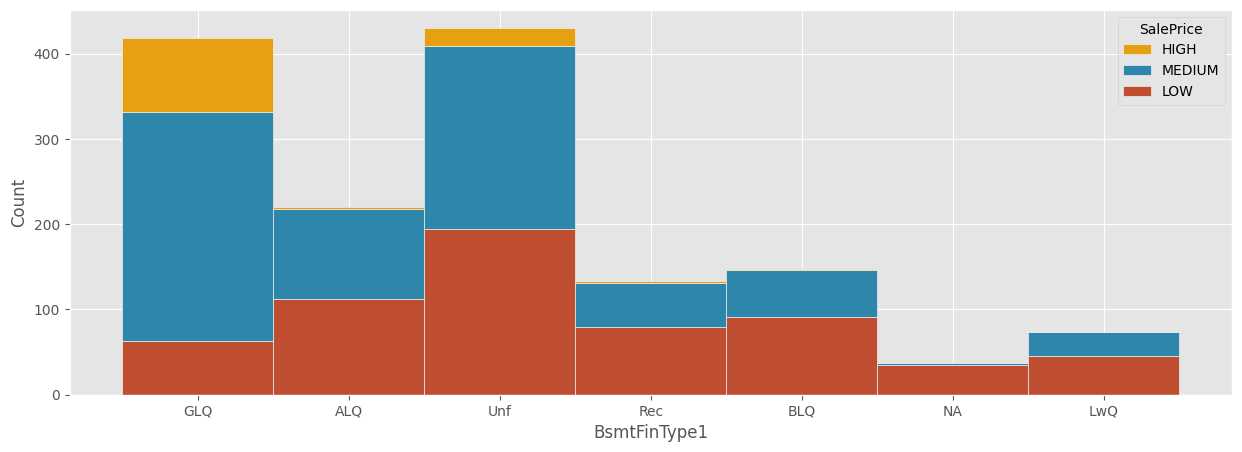

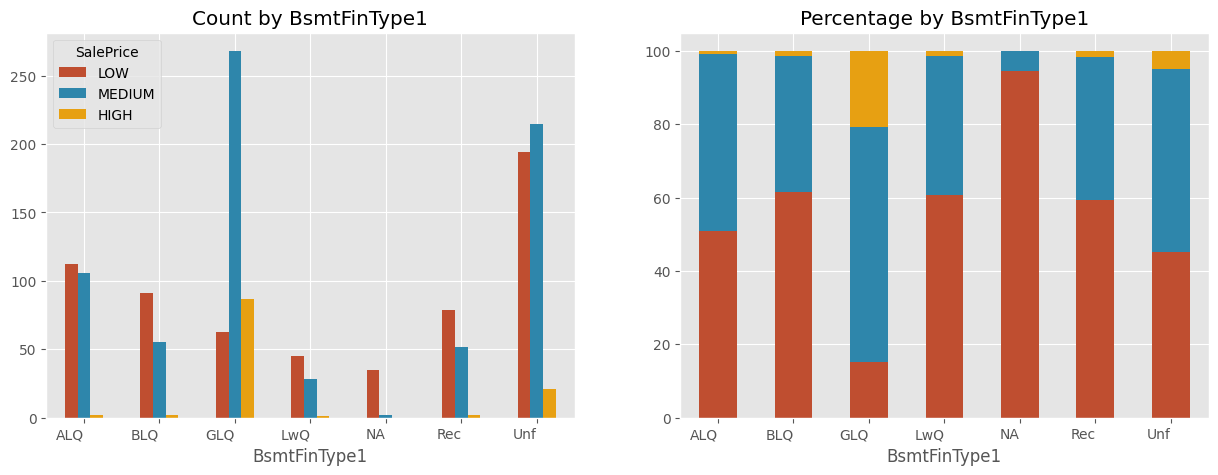

In [61]:

category_common_analysis(data=df,x='BsmtFinType1', display= False, target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='BsmtFinType1', showplots=False)

##### BsmtFinSF1

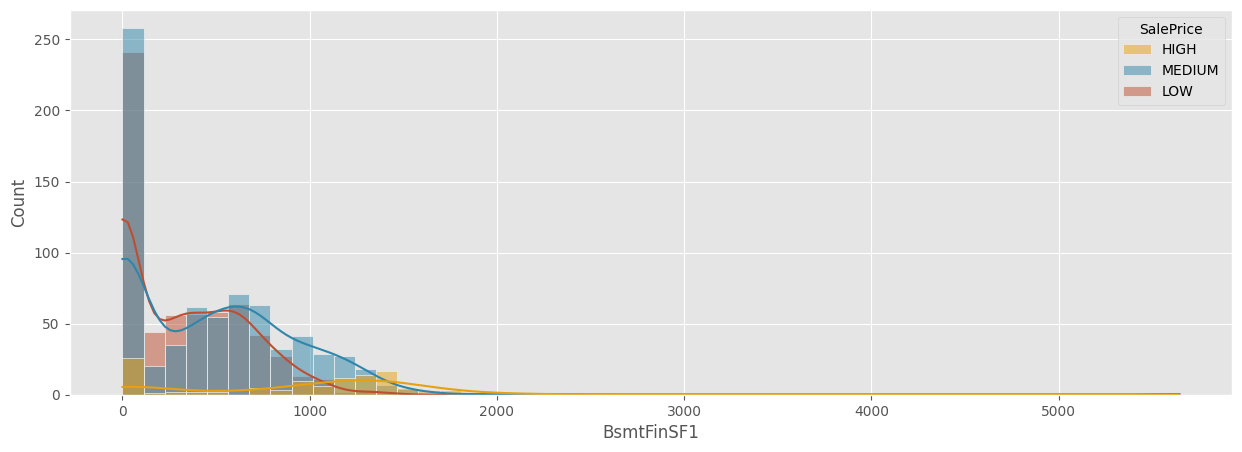

Understanding BsmtFinSF1:
	Missing values: 0
	Independence Test: 1.54e-41[<0.05]
	Correlation Index: 0.39
	Correlation p_value: 3.39e-53



In [62]:
understand(dataf=df_copy, feature_name='BsmtFinSF1', dtype='int', upper_limit=2000)

##### BsmtFinType2

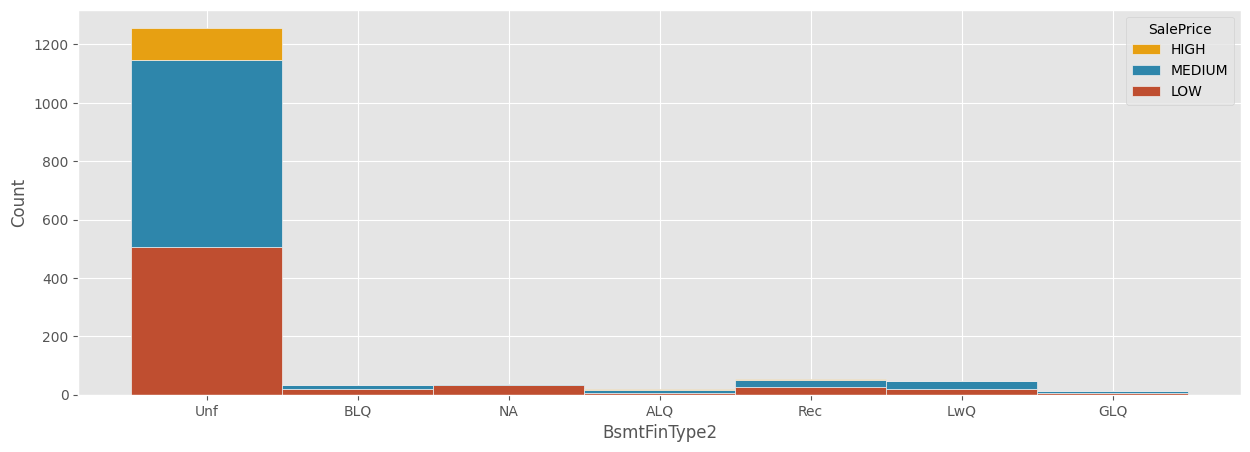

In [63]:
category_common_analysis(data=df,x='BsmtFinType2', display= False, target='SalePrice', percentages=False, palette=palette)

##### BsmtFinSF2

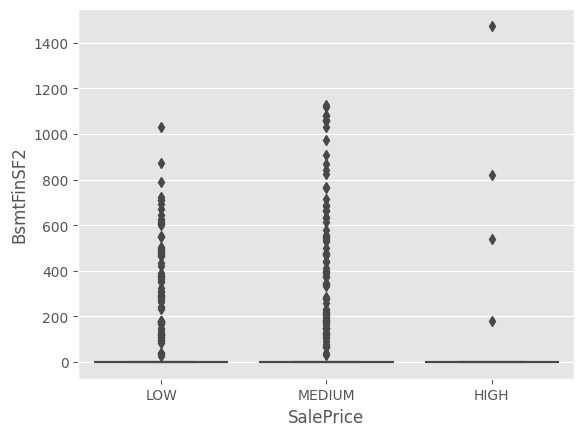

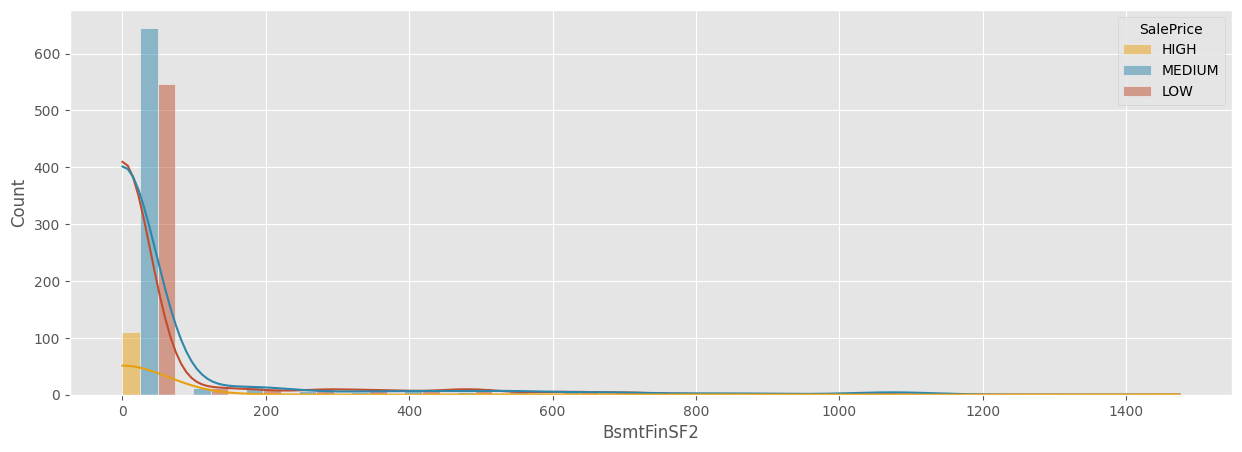

In [64]:
# as we can see from the boxplot all the means are approximately zero and also within the narrow range of plausible values
# no trend emerges
sb.boxplot(data=df, y="BsmtFinSF2", x="SalePrice")
histplot(df,'SalePrice',"BsmtFinSF2",multiple='dodge',alpha=0.5, bins=20)

##### BsmtUnfSF

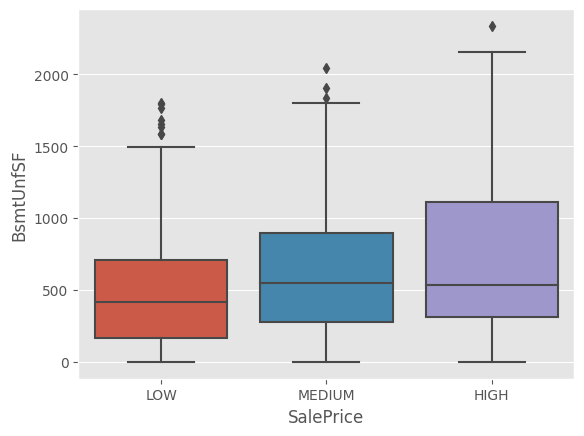

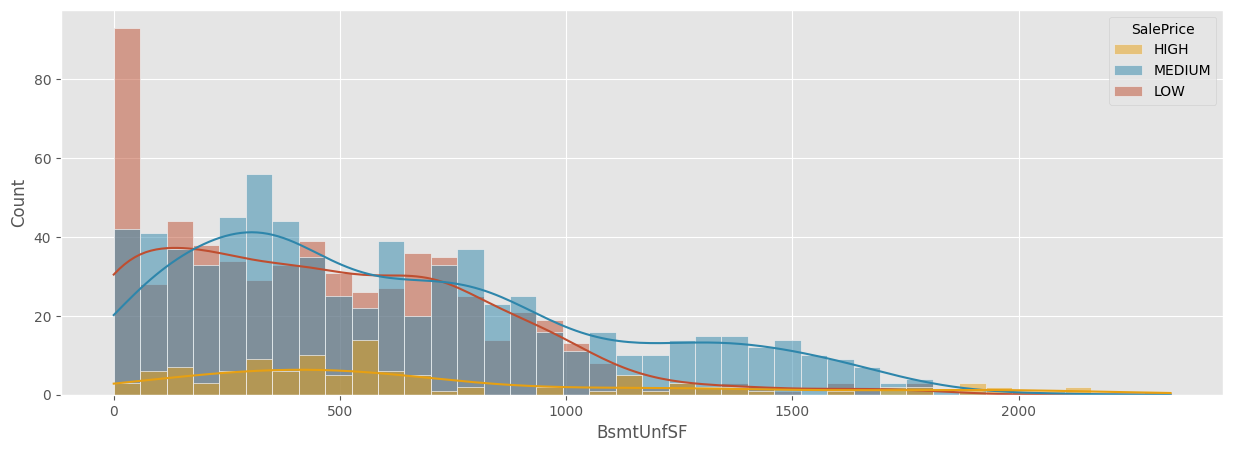

In [65]:
# The mean of the attribute is approximately equal for the MEDIUM and HIGH class, while for LOW it is smaller.
# However, the distributions of the three lables have almost the same peak
sb.boxplot(data=df, y="BsmtUnfSF", x="SalePrice")
histplot(df,'SalePrice',"BsmtUnfSF",multiple='layer',alpha=0.5, bins = 40)
#frequencies_and_percentages_numeric(df, 'SalePrice', 'BsmtUnfSF', rotation=30, bin = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### TotalBsmtSF

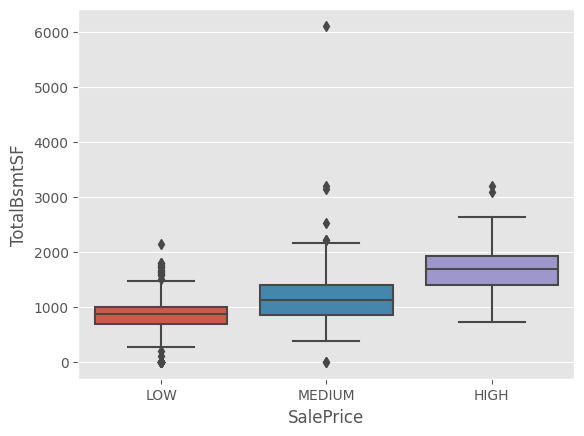

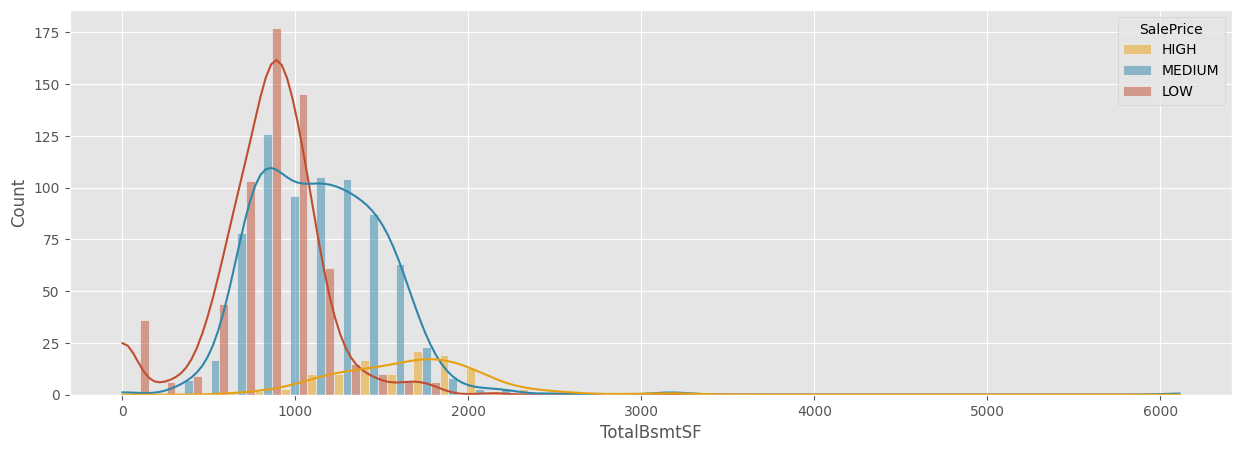

Understanding TotalBsmtSF:
	Missing values: 0
	Independence Test: 1.41e-106[<0.05]
	Correlation Index: 0.61
	Correlation p_value: 9.48e-152



In [66]:
# The mean is different for all the three labels and the distributions of the labels
# look enough distant one from the other, so we keep the attribute
sb.boxplot(data=df, y="TotalBsmtSF", x="SalePrice")
histplot(df,'SalePrice',"TotalBsmtSF",multiple='dodge',alpha=0.5, bins = 40)
understand(dataf=df_copy, feature_name='TotalBsmtSF', dtype='int', showplots=False, low_limit=0, upper_limit= 3000)


##### Heating

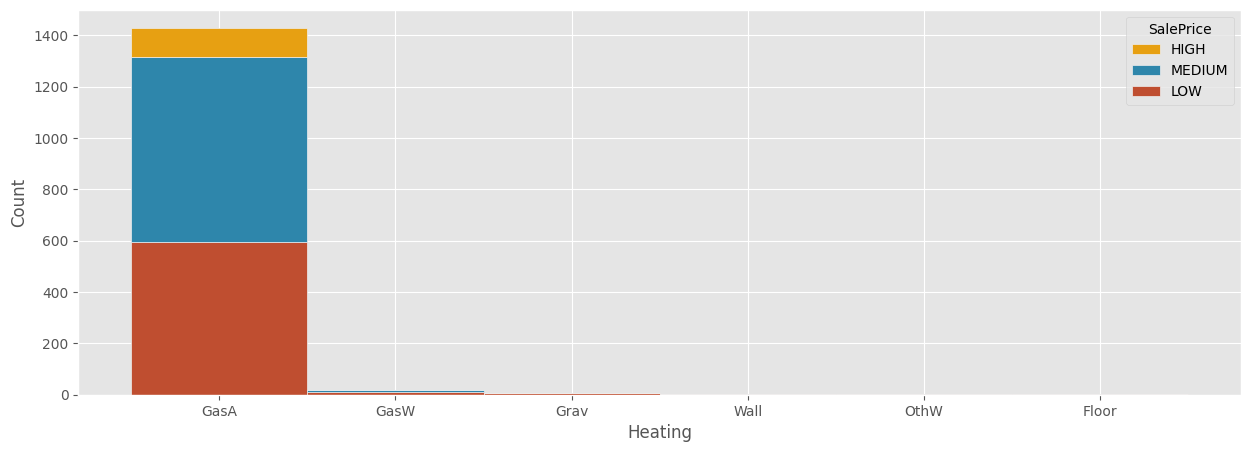

In [67]:
# Almost all the examples have the same attribute value, there is no use in keeping it 
category_common_analysis(data=df,x='Heating', display= False, target='SalePrice', percentages=False, palette=palette)

##### HeatingQC

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Understanding HeatingQC:
	Missing values: 0
	Independence Test: 1.71e-56[<0.05]
	Information Gain: 0.15
	When the HeatingQC is:
		• Po, then the sale price is LOW (0.07% of the times)
		• Fa, then the sale price is 70% likely to be LOW (3.36% of the times)
		• TA, then the sale price is 65% likely to be LOW (29.32% of the times)
		• Ex, then the sale price is 60% likely to be MEDIUM (50.75% of the times)
		• Gd, then the sale price is 45% likely to be LOW (16.51% of the times)




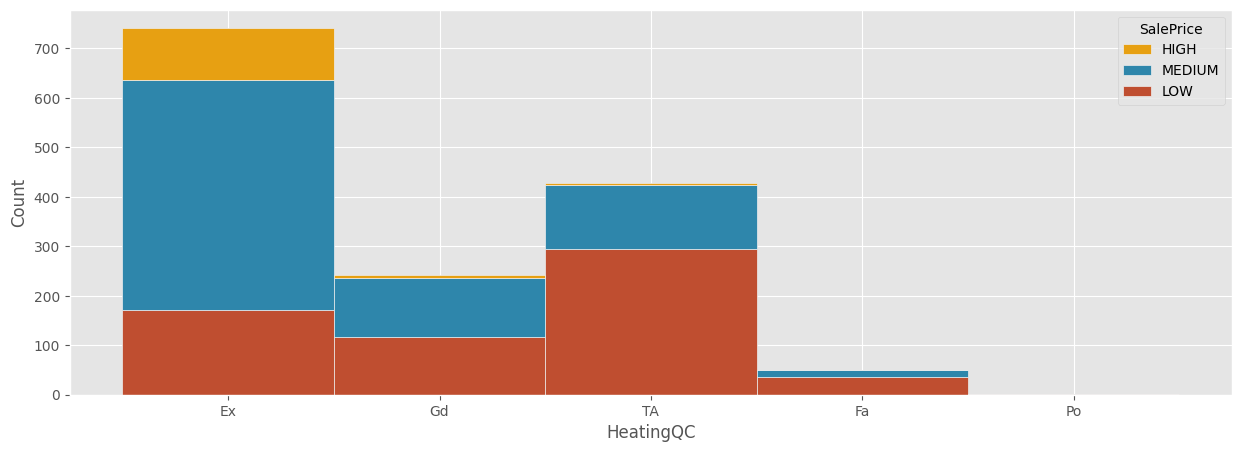

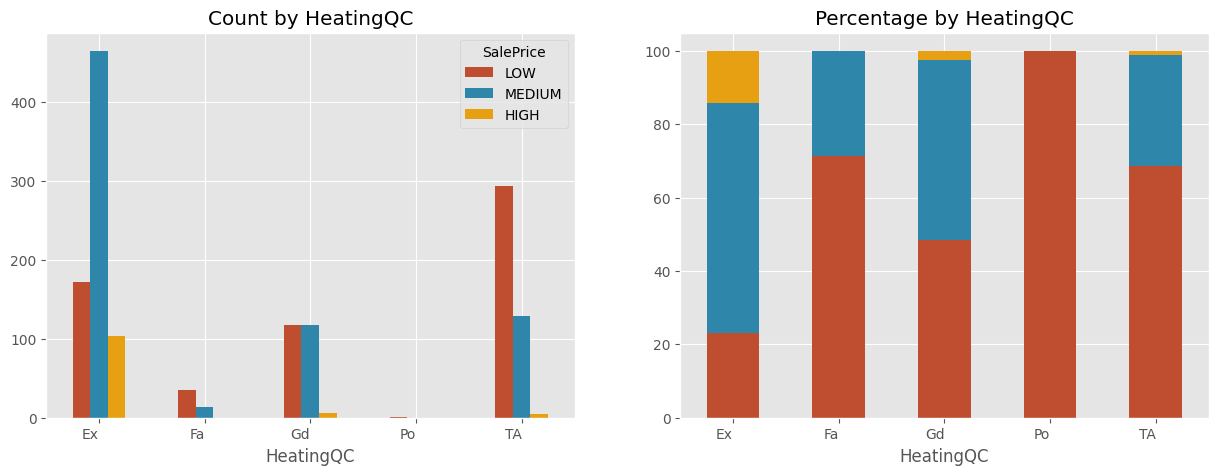

In [68]:

category_common_analysis(data=df,x='HeatingQC', display= False, target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='HeatingQC', showplots=False)

##### CentralAir

In [69]:
IG(df,'SalePrice','CentralAir')

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.05543545701641376

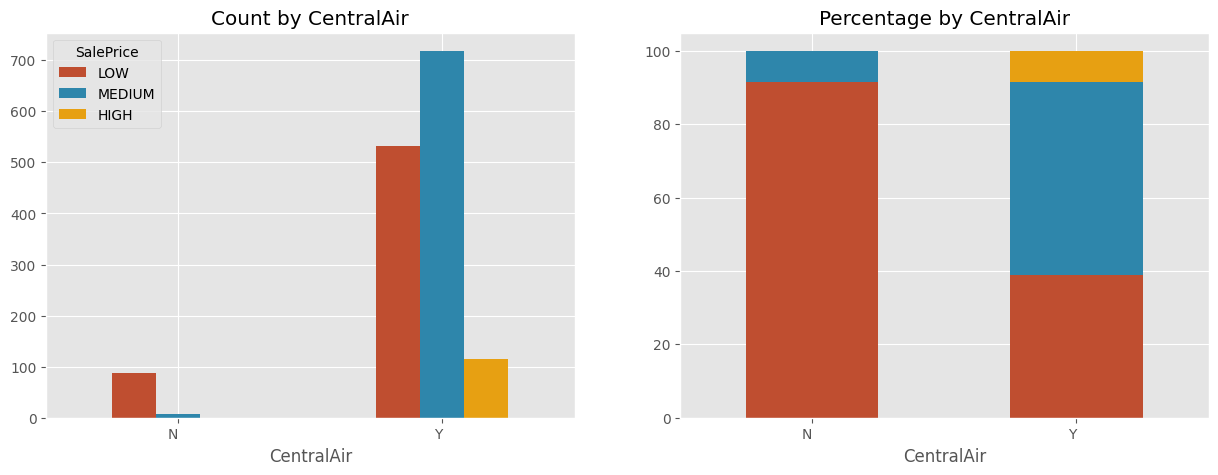

In [70]:
frequencies_and_percentages(df,'SalePrice','CentralAir')

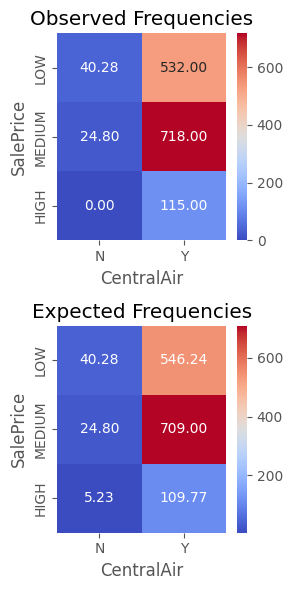

Chi-square Test - Outcome
P-Value: 1.2685848517032062e-22 [<0.05]
Cramer's V - Outcome
Coeff: 0.2628061686289399


(1.2685848517032062e-22, '[<0.05]')

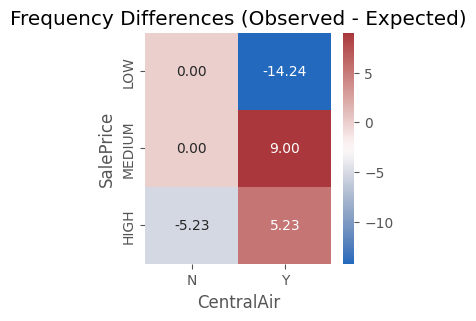

In [71]:
stattest_quali(df,'CentralAir', typeplot='heatmap', fig_width=10)

ANOVA Test - Outcome
P-Value: 7.00278021431306e-52 [<0.05]


(7.00278021431306e-52, '[<0.05]')

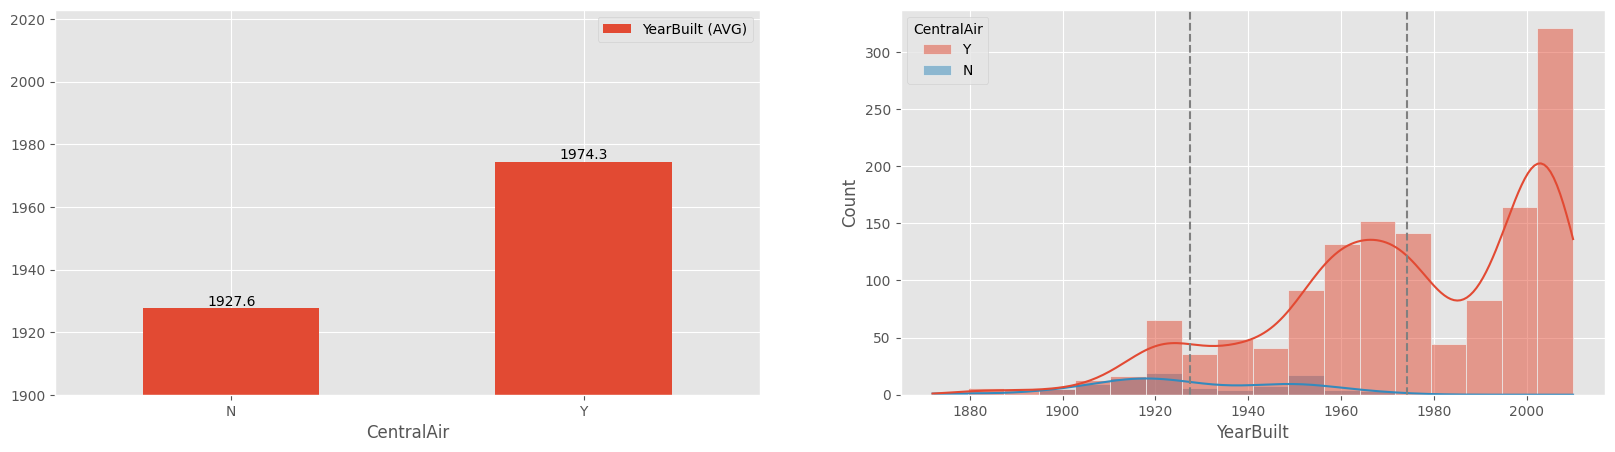

In [72]:
stattest_quanti(df,'YearBuilt', 'CentralAir' , low_limit=1900, upper_limit=2023)

##### Electrical

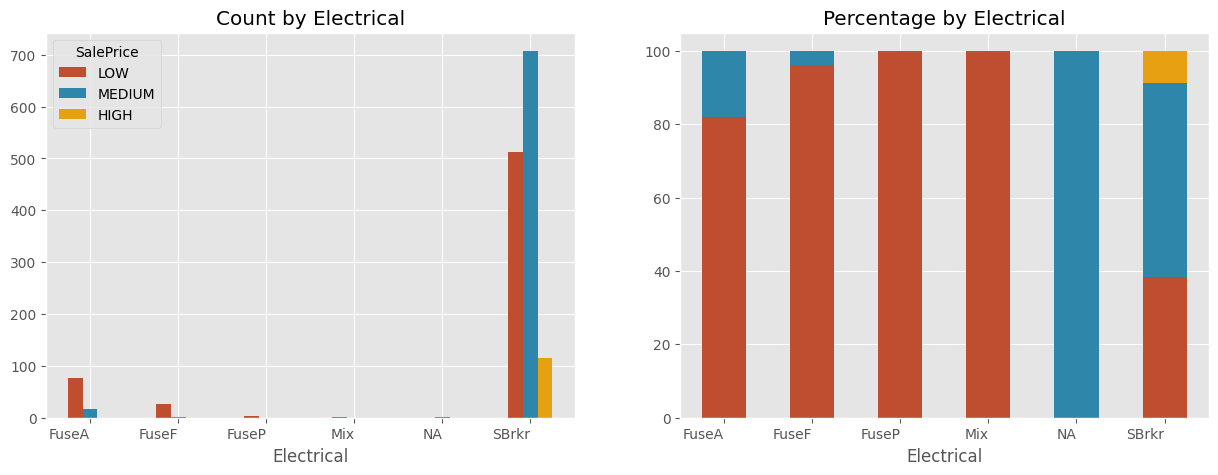

In [73]:
frequencies_and_percentages(df,'SalePrice','Electrical')

In [74]:
IG(df,'SalePrice','Electrical')

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.060141516515176664

In [75]:
len(df[df['Electrical'] == 'NA'])

1

##### 1stFlrSF

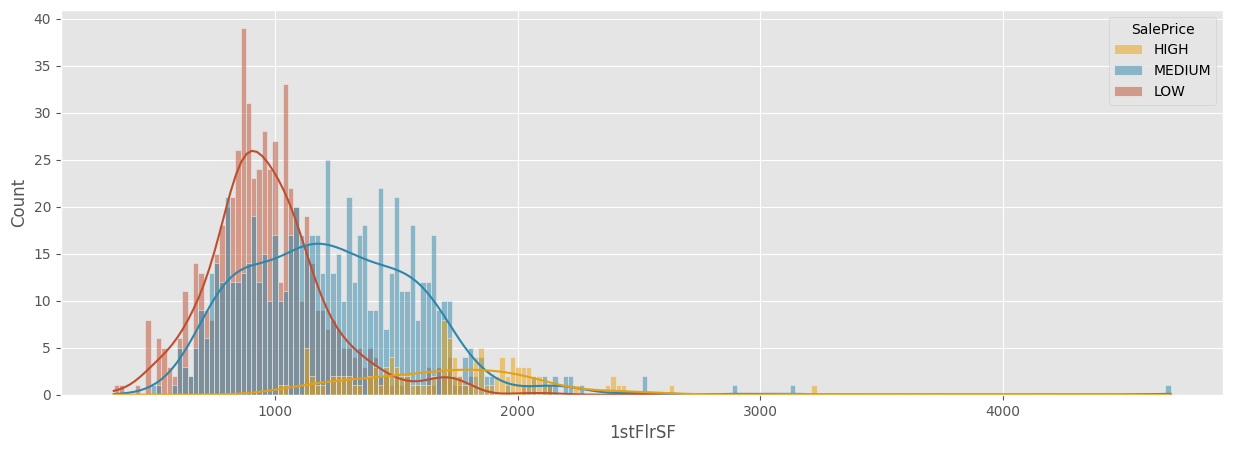

In [76]:
histplot(df,'SalePrice','1stFlrSF',bins=200)

ANOVA Test - Outcome
P-Value: 2.555821024618768e-104 [<0.05]


(2.555821024618768e-104, '[<0.05]')

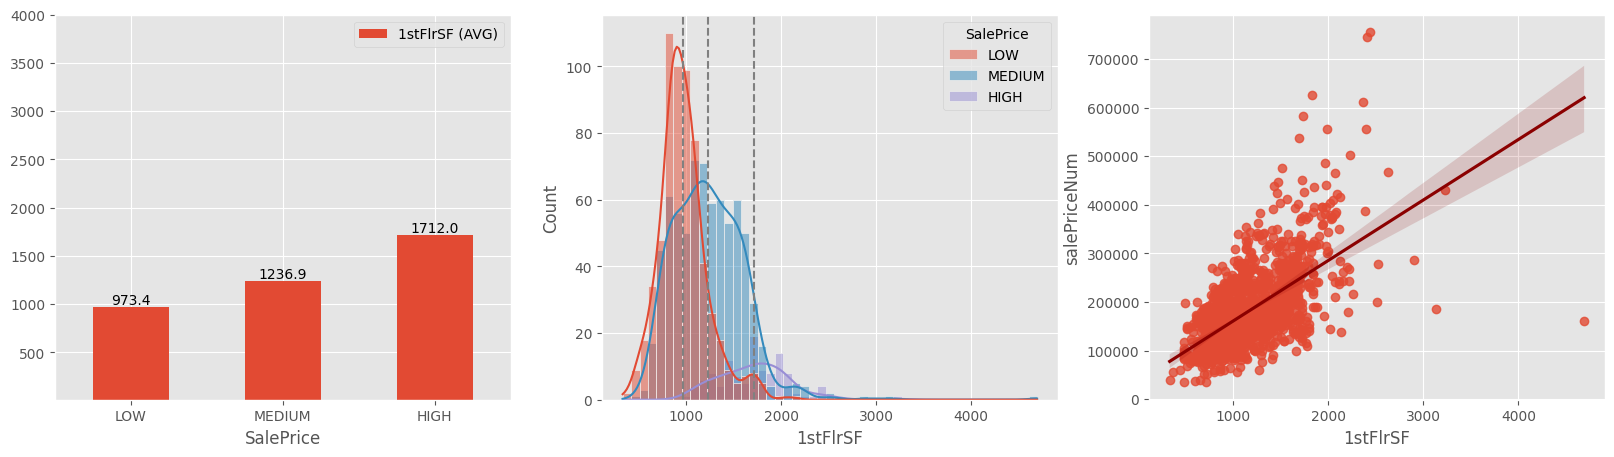

In [77]:
stattest_quanti(df,'1stFlrSF',low_limit=10, upper_limit=4000)

##### 2ndFlrSF


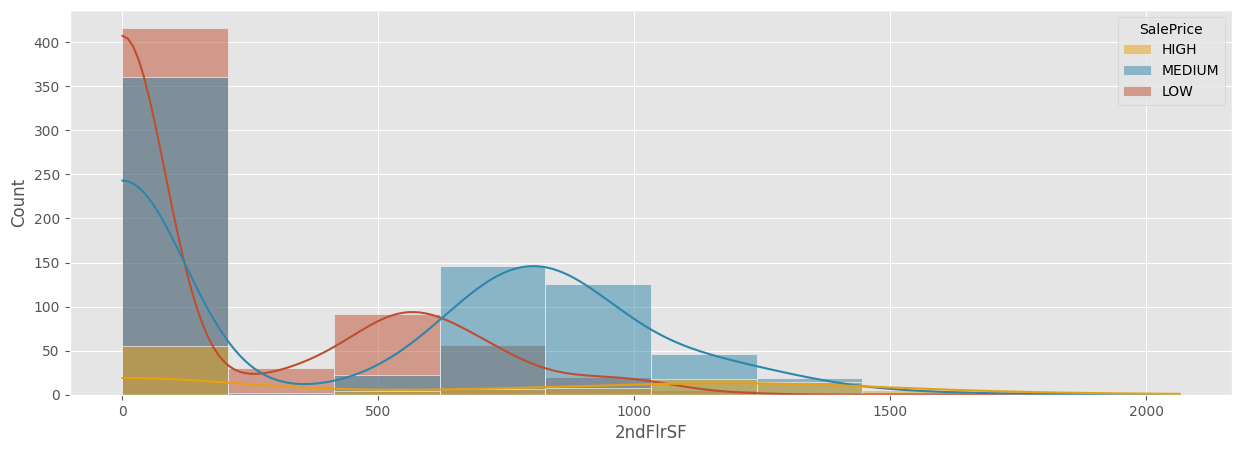

ANOVA Test - Outcome
P-Value: 1.7788644017519046e-32 [<0.05]


(1.7788644017519046e-32, '[<0.05]')

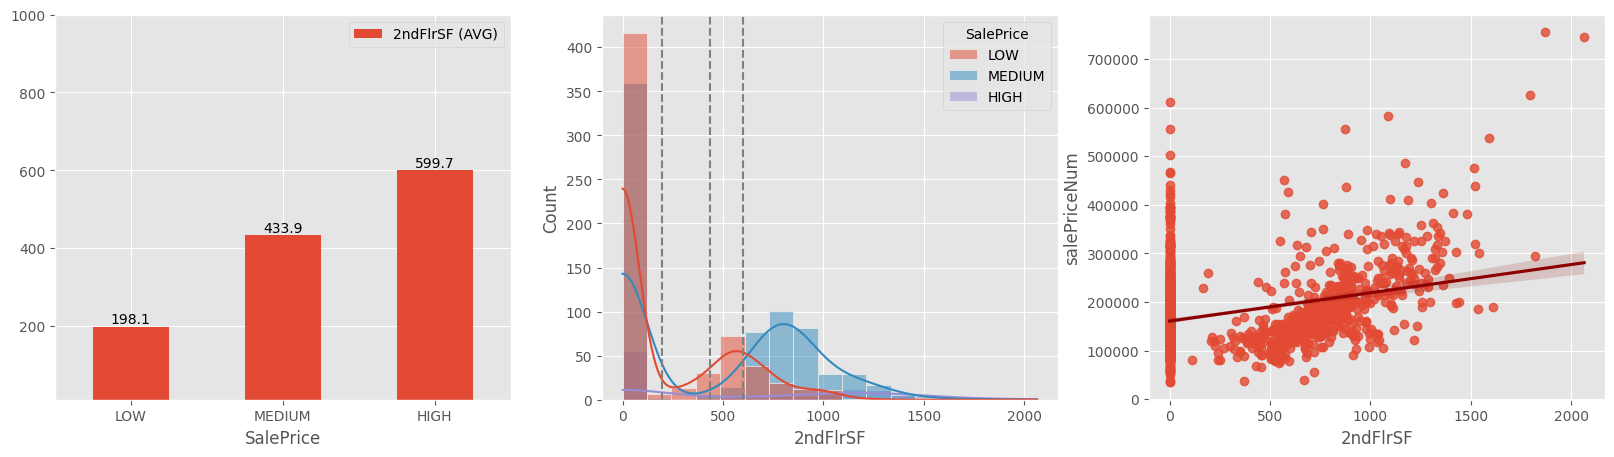

In [78]:
histplot(df,'SalePrice','2ndFlrSF',bins=10)
stattest_quanti(df,'2ndFlrSF',low_limit=10, upper_limit=1000)

##### LowQualFinSF

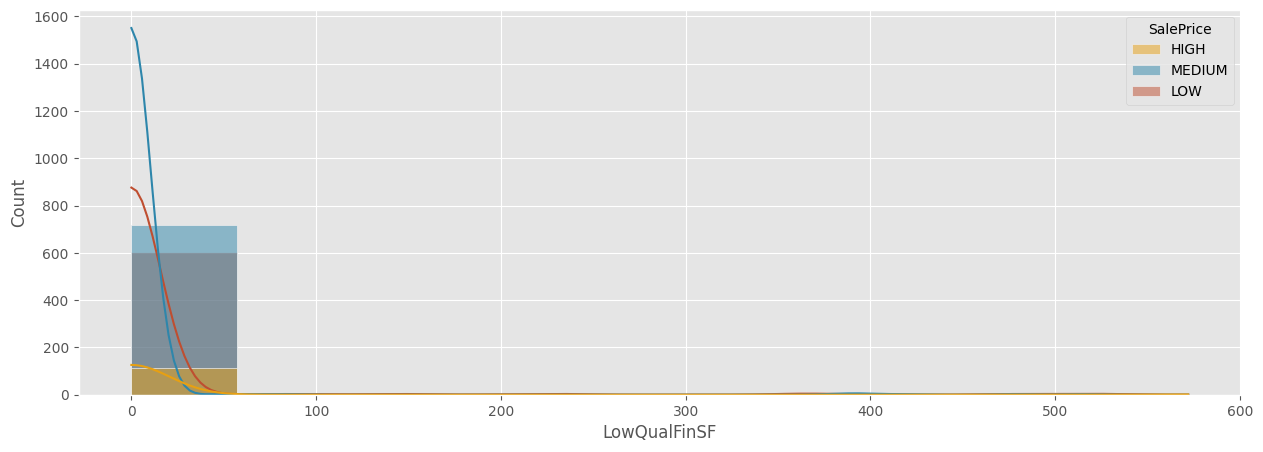

ANOVA Test - Outcome
P-Value: 0.20310425163833182 


(0.20310425163833182, '')

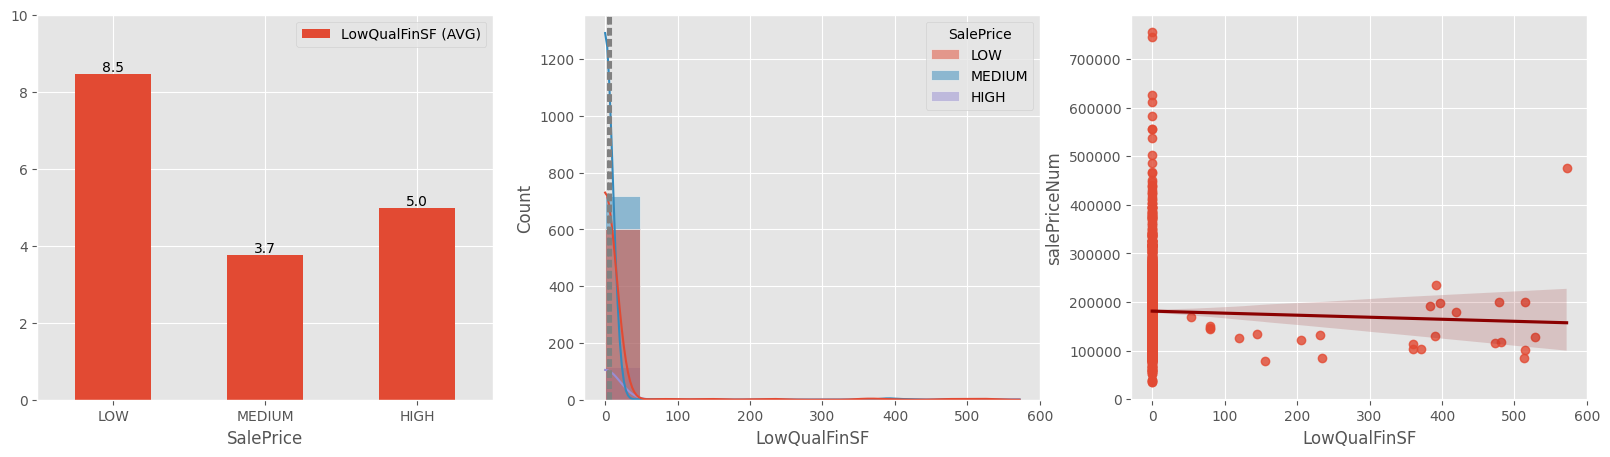

In [79]:
histplot(df,'SalePrice','LowQualFinSF',bins=10)
stattest_quanti(df,'LowQualFinSF',low_limit=0, upper_limit=10)

##### GrLivArea

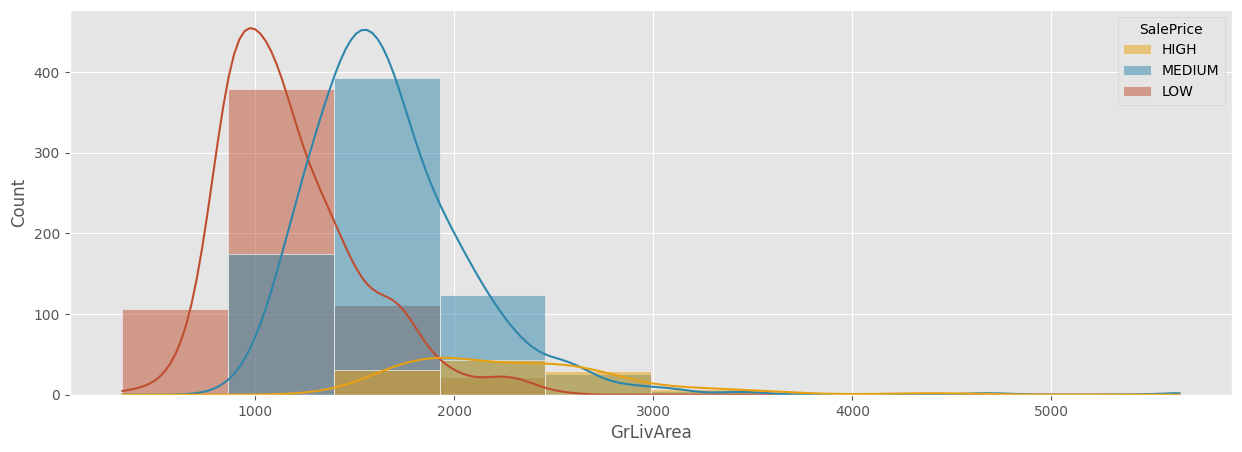

ANOVA Test - Outcome
P-Value: 2.727682408446856e-163 [<0.05]


(2.727682408446856e-163, '[<0.05]')

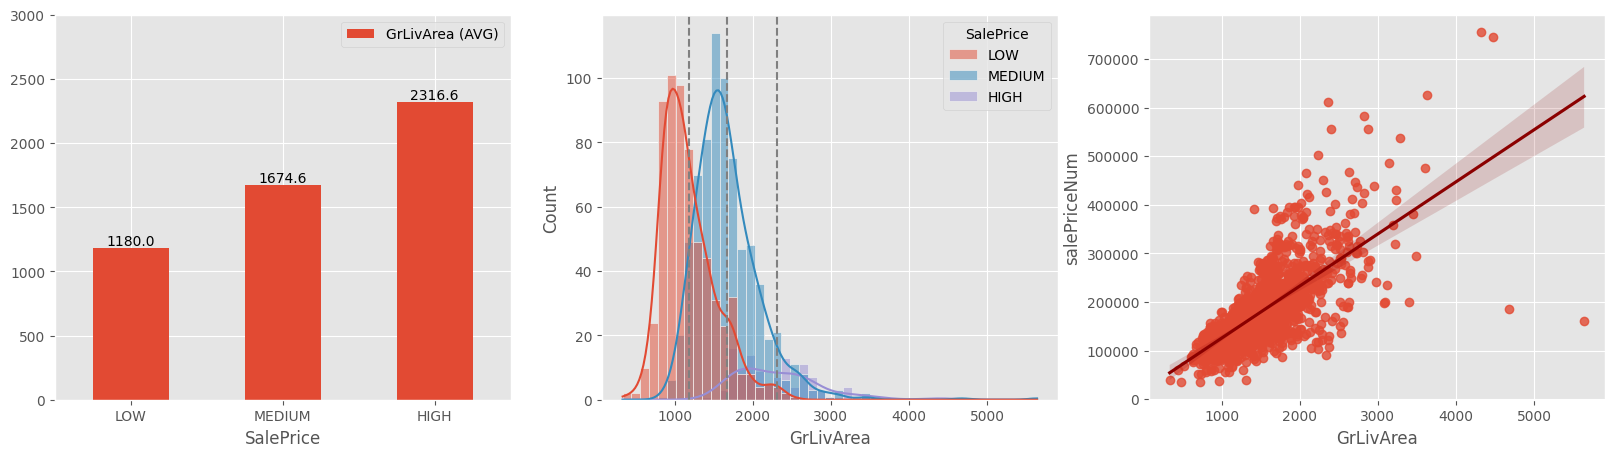

In [80]:
histplot(df,'SalePrice','GrLivArea',bins=10)
stattest_quanti(df,'GrLivArea',low_limit=0, upper_limit=3000)

##### BsmtFullBath

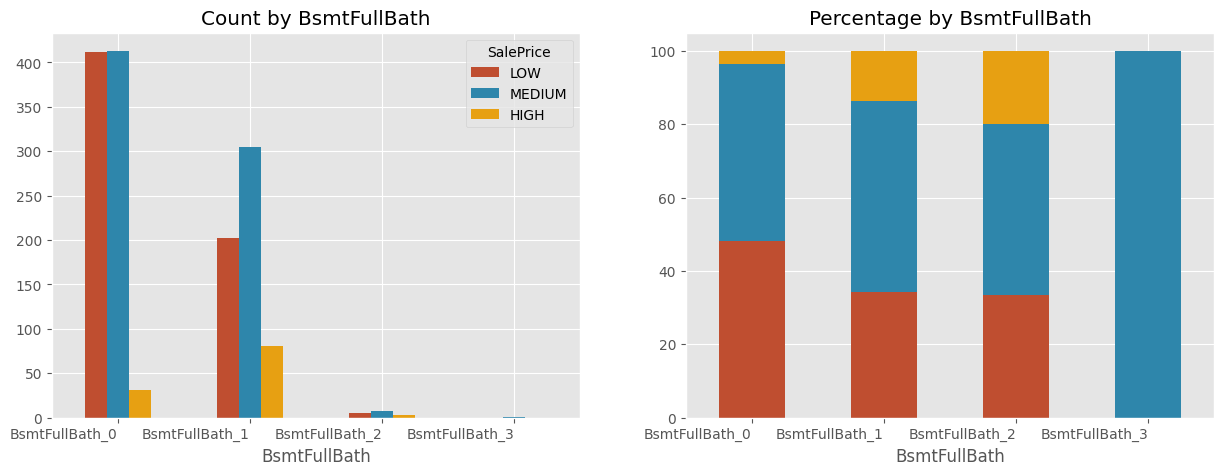

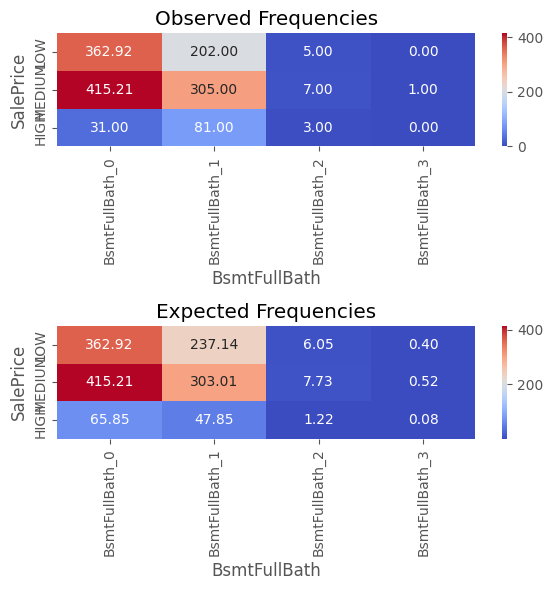

Chi-square Test - Outcome
P-Value: 2.3271572182731895e-12 [<0.05]
Cramer's V - Outcome
Coeff: 0.15069691374777708
0.032819947247596126


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


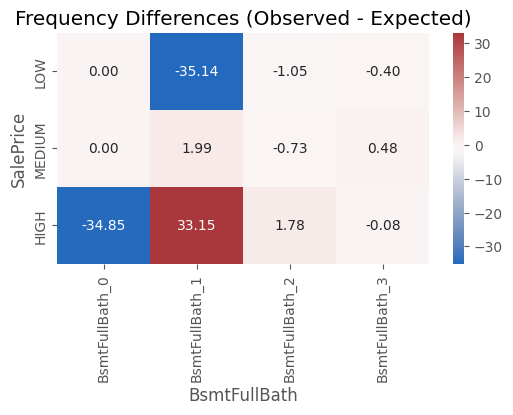

In [81]:
categoric_ordinal_plot(df, 'BsmtFullBath')

##### BsmtHalfBath

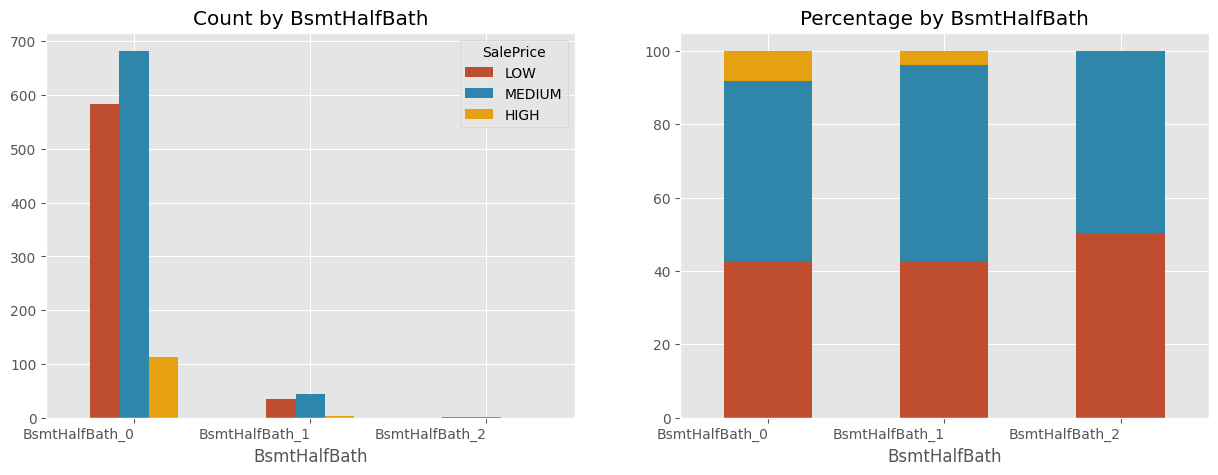

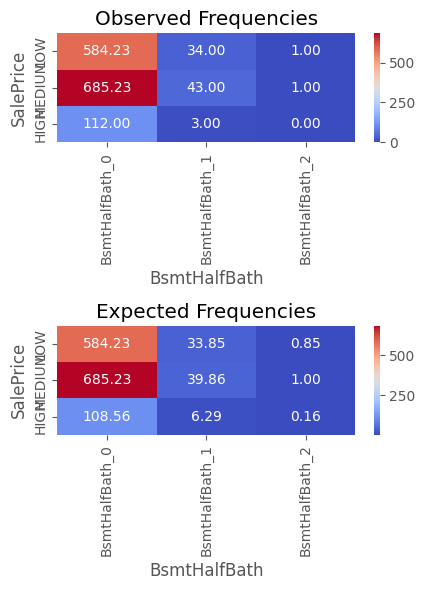

Chi-square Test - Outcome
P-Value: 0.6806487194877051 
Cramer's V - Outcome
Coeff: 0.02806951347725422
0.0014174939544221248


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


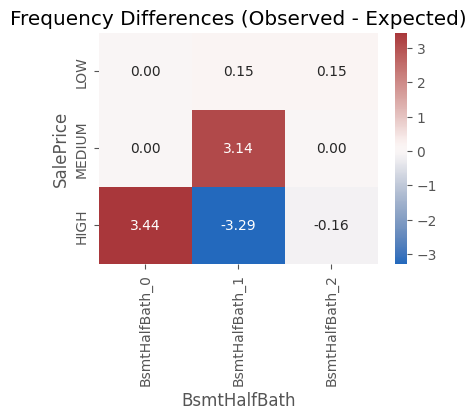

In [82]:
categoric_ordinal_plot(df, 'BsmtHalfBath')

##### FullBath

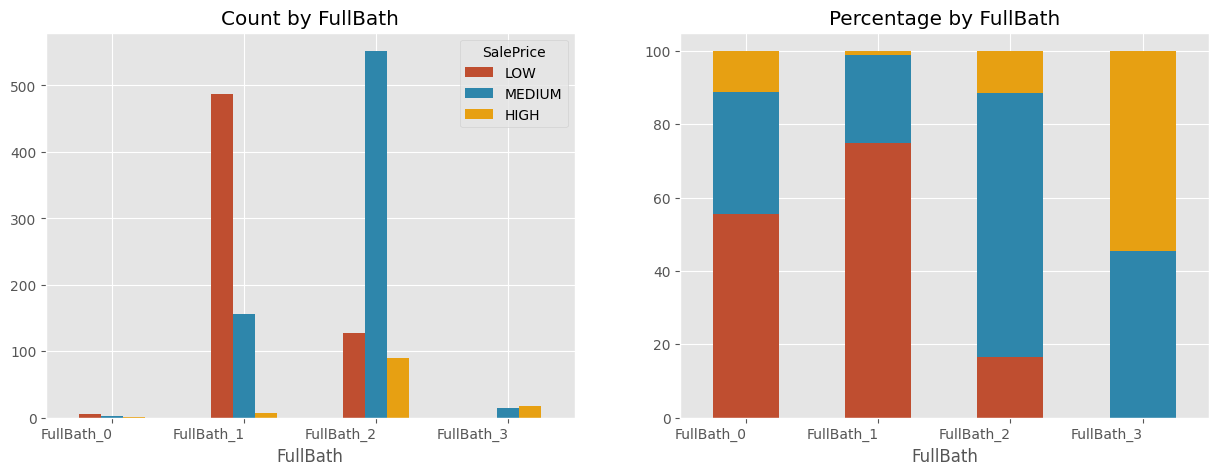

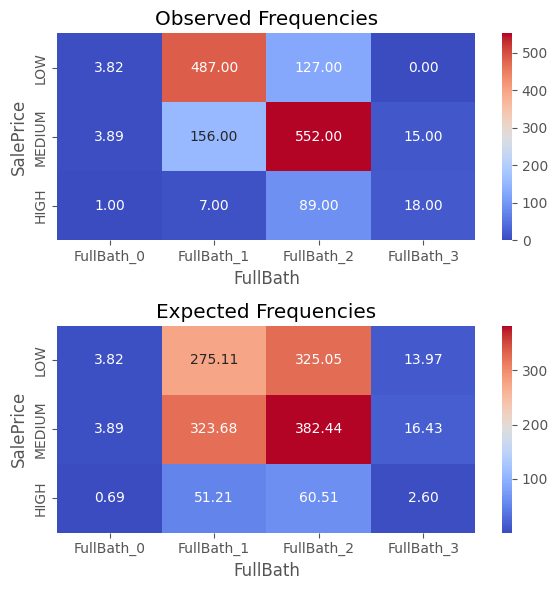

Chi-square Test - Outcome
P-Value: 4.018443251096999e-127 [<0.05]
Cramer's V - Outcome
Coeff: 0.45463384659527495
0.29826715827233946


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.29826715827233946

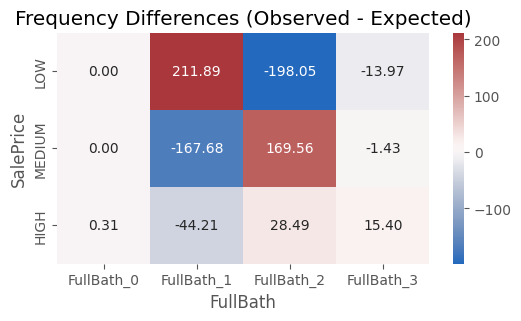

In [83]:
categoric_ordinal_plot(df_copy, 'FullBath')
IG(df, TARGET_FEATURE, 'FullBath')

##### HalfBath

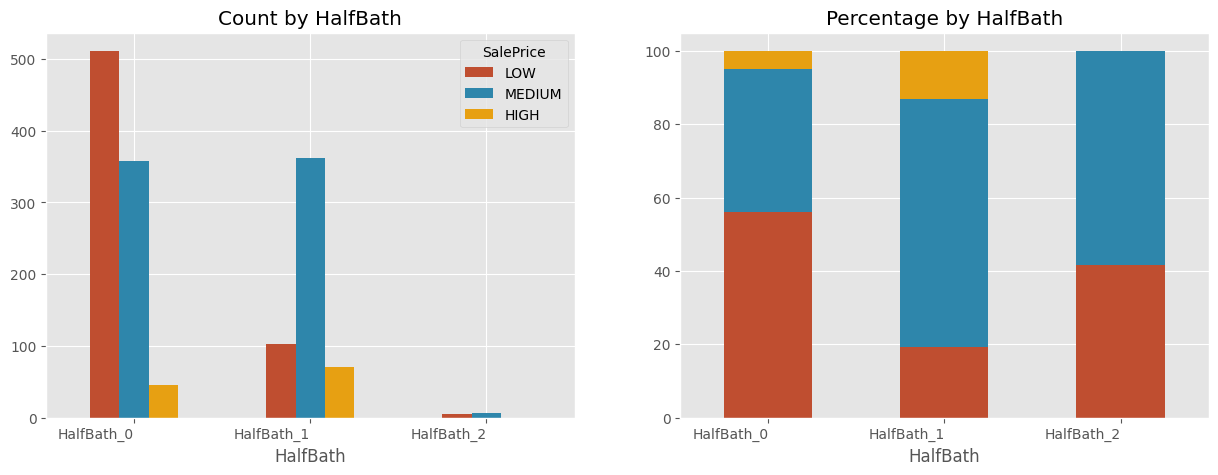

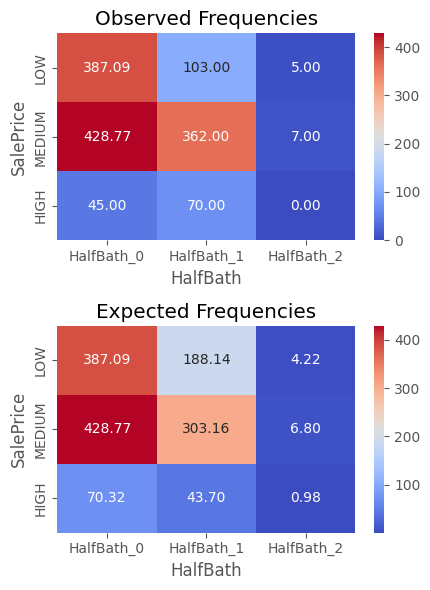

Chi-square Test - Outcome
P-Value: 1.7652372425300367e-40 [<0.05]
Cramer's V - Outcome
Coeff: 0.256572472337345
0.10054858198695393


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


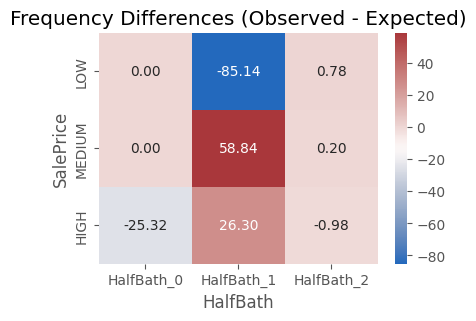

In [84]:
categoric_ordinal_plot(df, 'HalfBath')

##### BedroomAbvGr

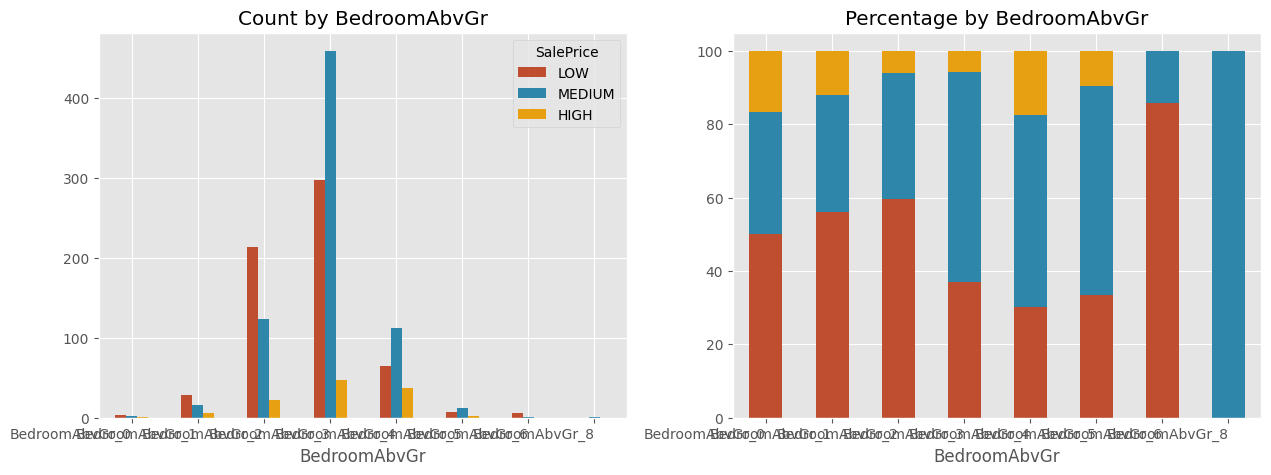

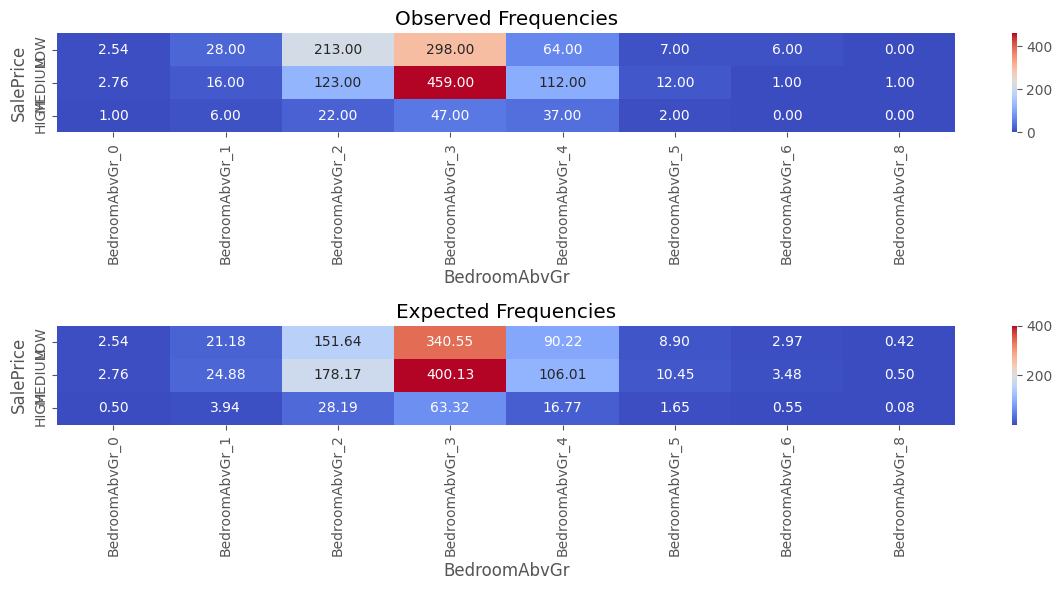

Chi-square Test - Outcome
P-Value: 1.1574262089106492e-16 [<0.05]
Cramer's V - Outcome
Coeff: 0.19264782804260805
0.05116755634206285


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


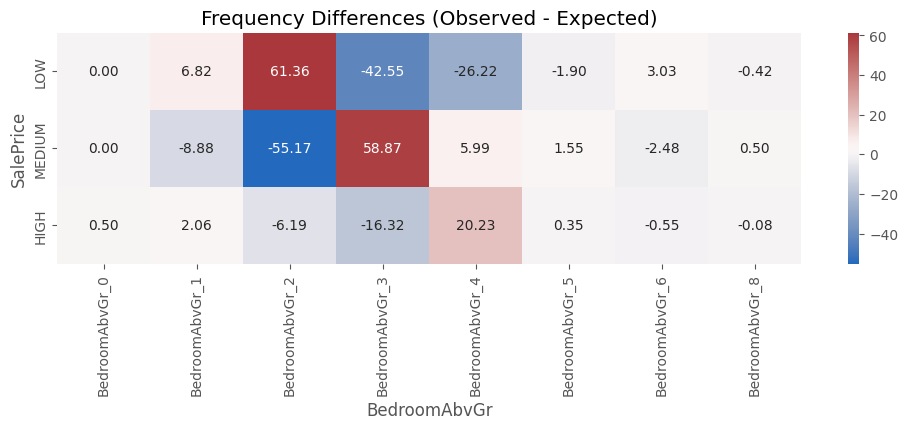

In [85]:
categoric_ordinal_plot(df, 'BedroomAbvGr')

##### KitchenAbvGr

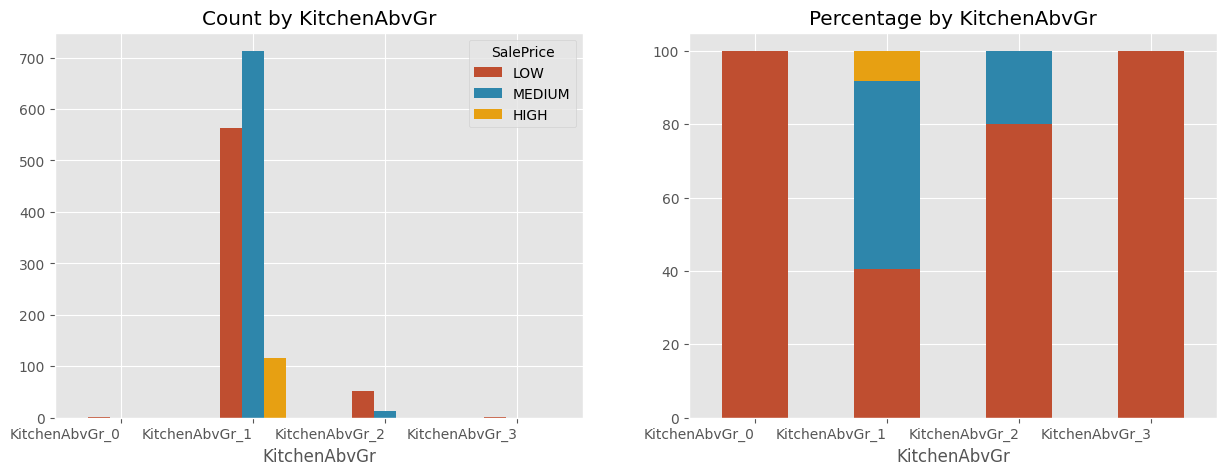

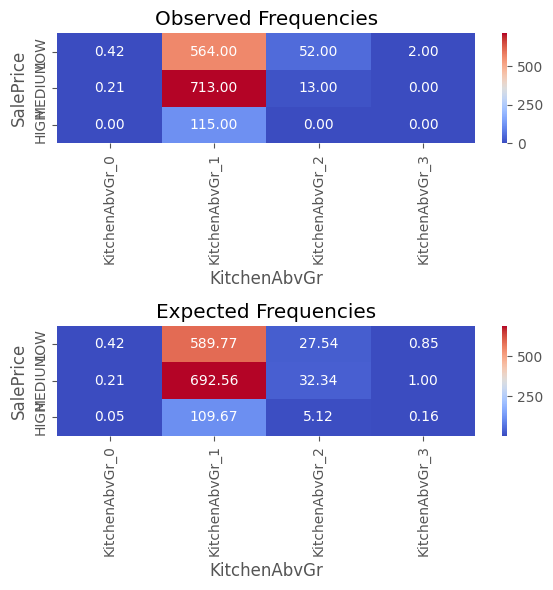

Chi-square Test - Outcome
P-Value: 5.958096086434347e-08 [<0.05]
Cramer's V - Outcome
Coeff: 0.1234105584113776
0.024484826808309997


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


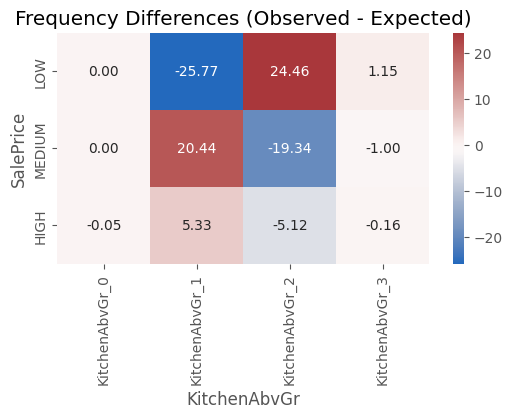

In [86]:
categoric_ordinal_plot(df, 'KitchenAbvGr')

##### KitchenQual

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3341239388726758

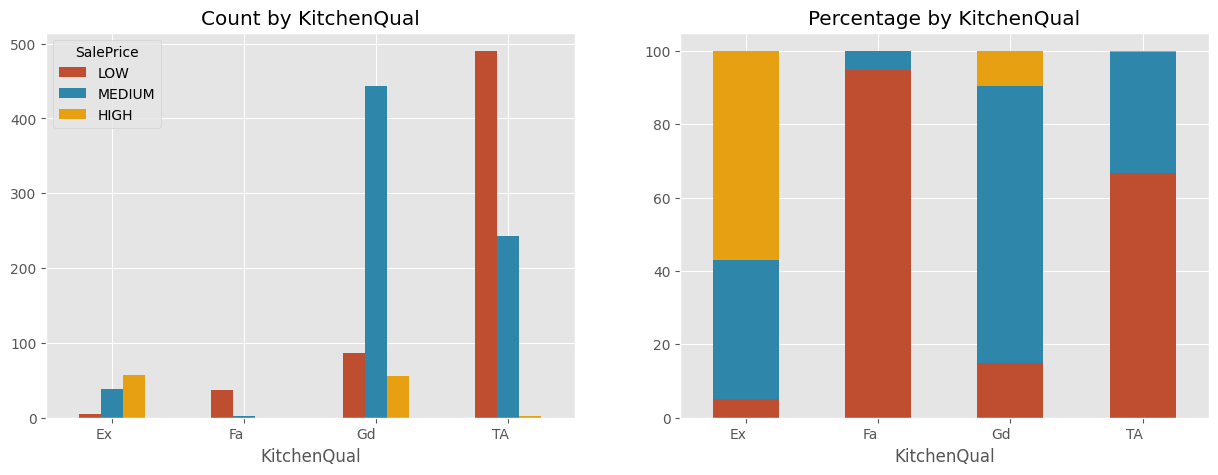

In [87]:
frequencies_and_percentages(df, TARGET_FEATURE, 'KitchenQual')
IG(df, TARGET_FEATURE, 'KitchenQual')

##### TotRmsAbvGrd

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ANOVA Test - Outcome
P-Value: 4.972682537673768e-83 [<0.05]


(4.972682537673768e-83, '[<0.05]')

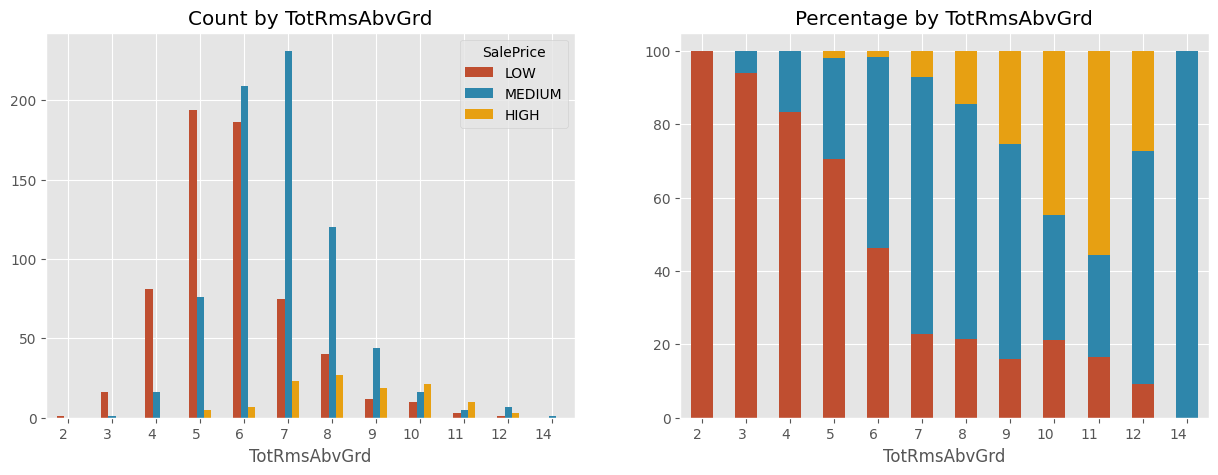

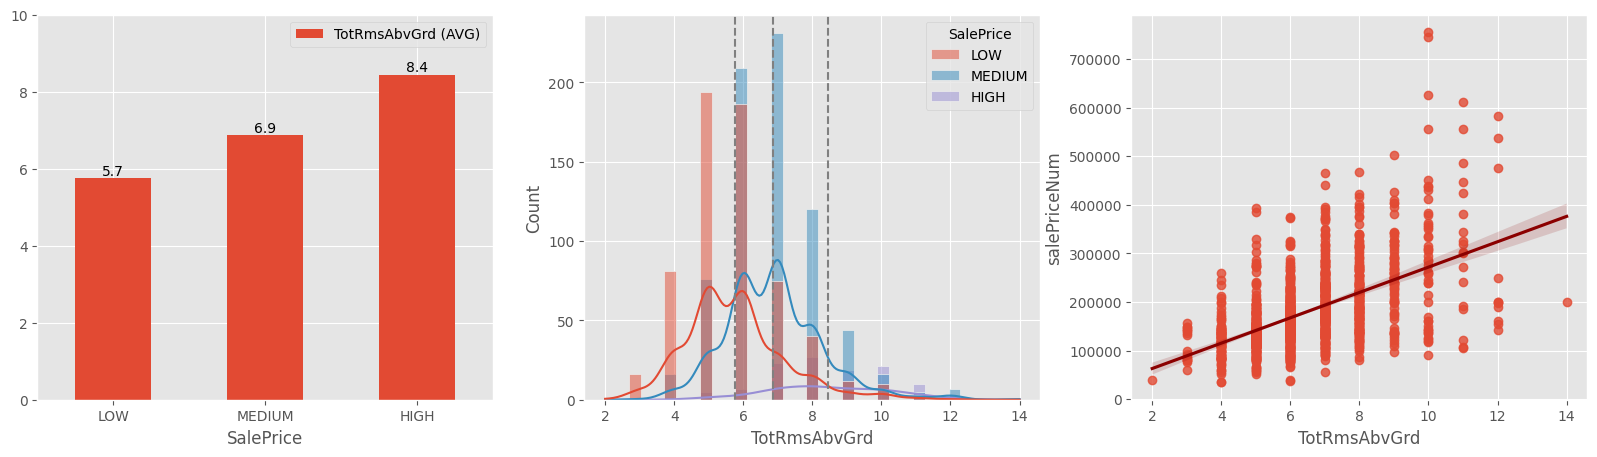

In [88]:
frequencies_and_percentages(df, TARGET_FEATURE, 'TotRmsAbvGrd')
IG(df, TARGET_FEATURE, 'TotRmsAbvGrd')
stattest_quanti(df, 'TotRmsAbvGrd', upper_limit=10)

##### Functional

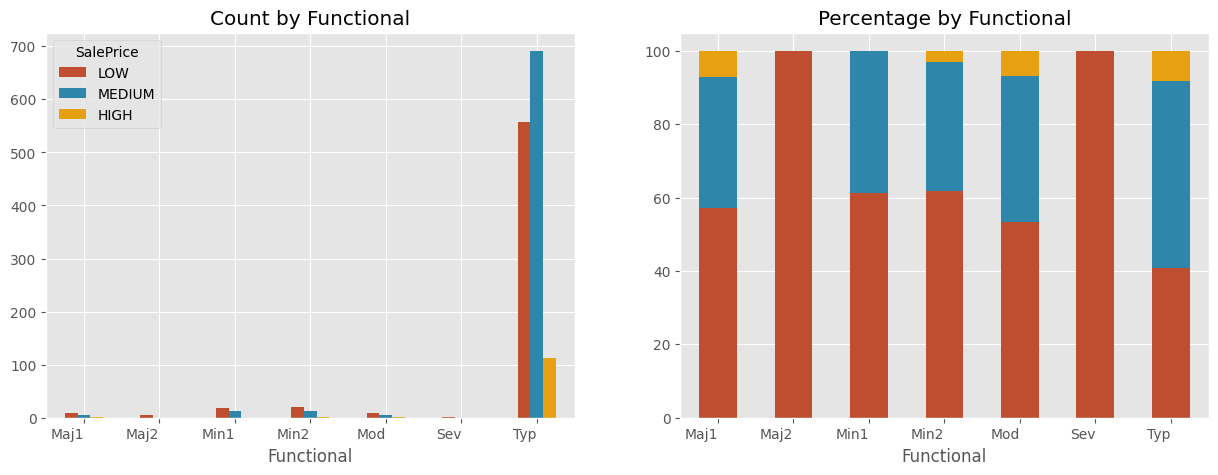

In [89]:
df_copy['Functional'] = df_copy['Functional'].astype('category')
#df_copy['Functional'].unique()
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'Functional')
#stattest_quali(df_copy, 'Functional')

##### Fireplaces

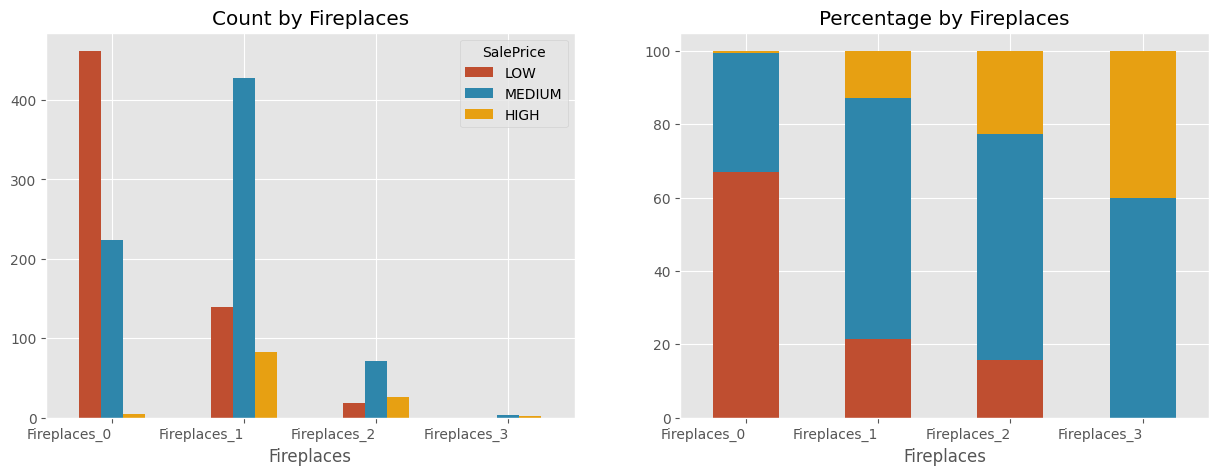

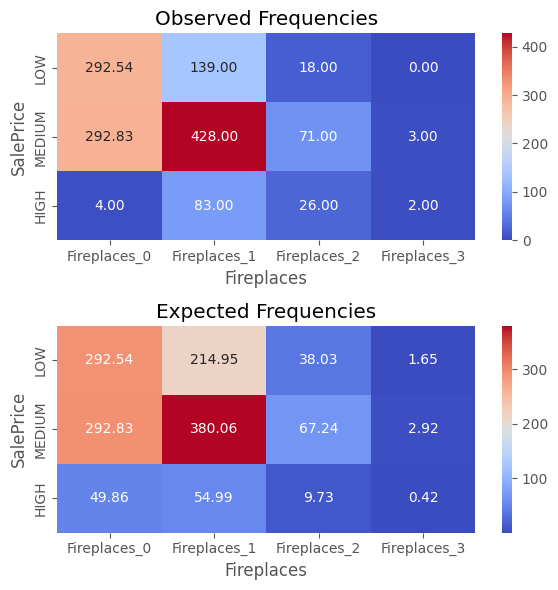

/tmp/ipykernel_11277/1379636686.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()


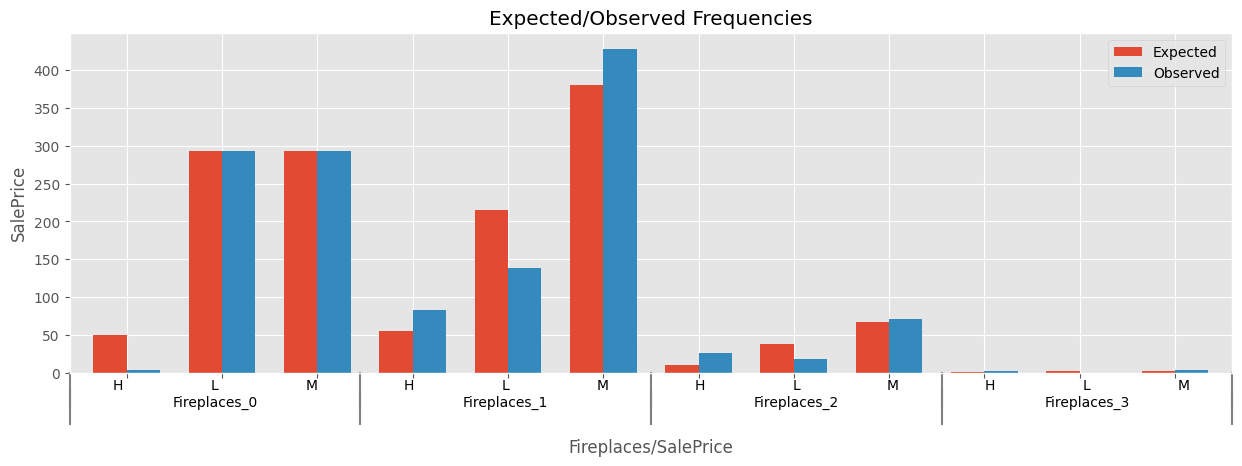

Chi-square Test - Outcome
P-Value: 5.349369497530157e-77 [<0.05]
Cramer's V - Outcome
Coeff: 0.3563365534395304
0.1966071830585545


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [90]:
categoric_ordinal_plot(df, 'Fireplaces', test_typeplot='barplot')

##### FireplaceQu

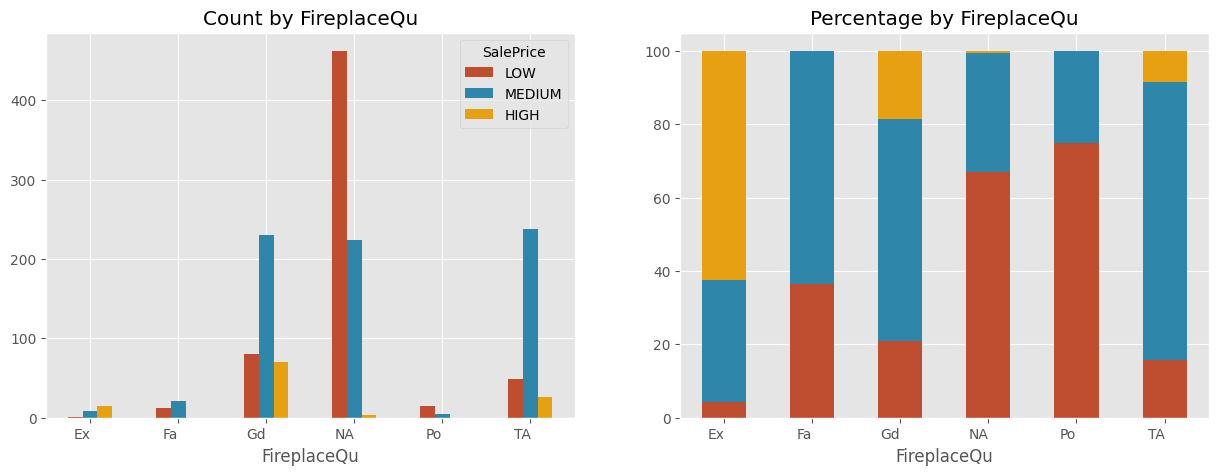

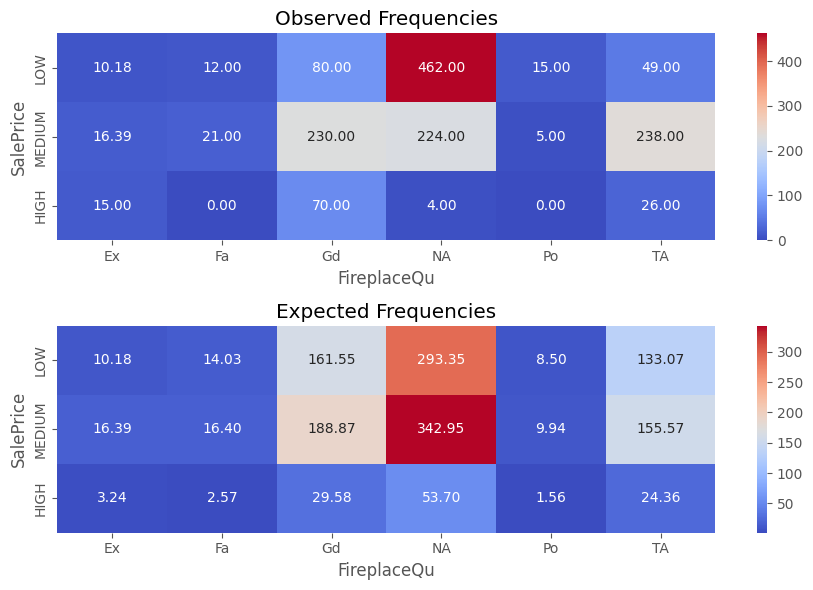

Chi-square Test - Outcome
P-Value: 5.148137174516188e-101 [<0.05]
Cramer's V - Outcome
Coeff: 0.41367367160139384


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2386235241672774

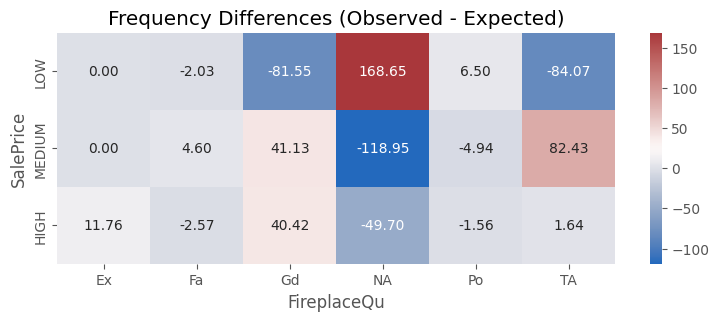

In [91]:
df_copy['FireplaceQu'] = df_copy['FireplaceQu'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'FireplaceQu')
stattest_quali(df_copy, 'FireplaceQu')
IG(df_copy, TARGET_FEATURE, 'FireplaceQu')

##### GarageType

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2403532227920979

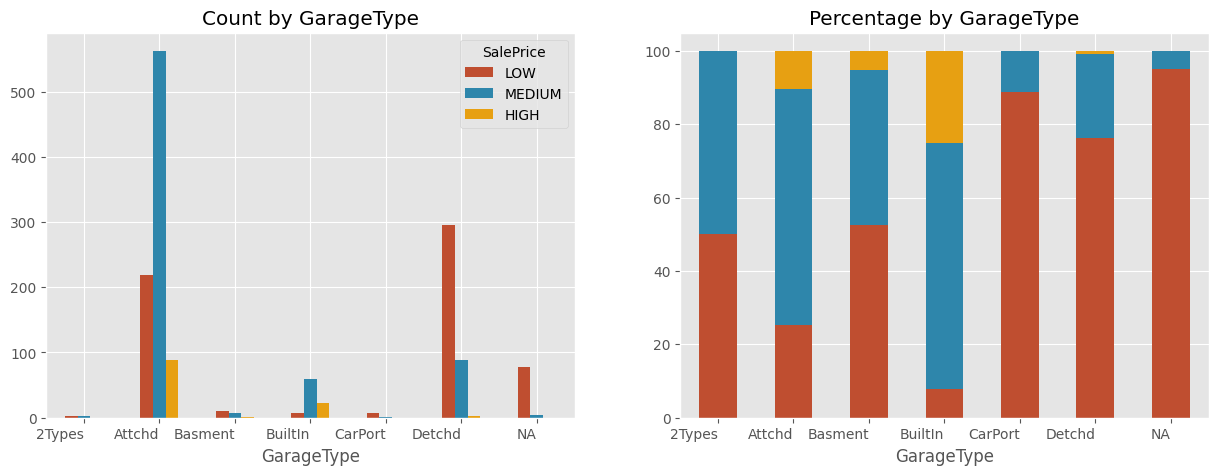

In [92]:
df['GarageType'].unique()
frequencies_and_percentages(df, TARGET_FEATURE, 'GarageType')
IG(df, TARGET_FEATURE, 'GarageType')

##### GarageYrBlt

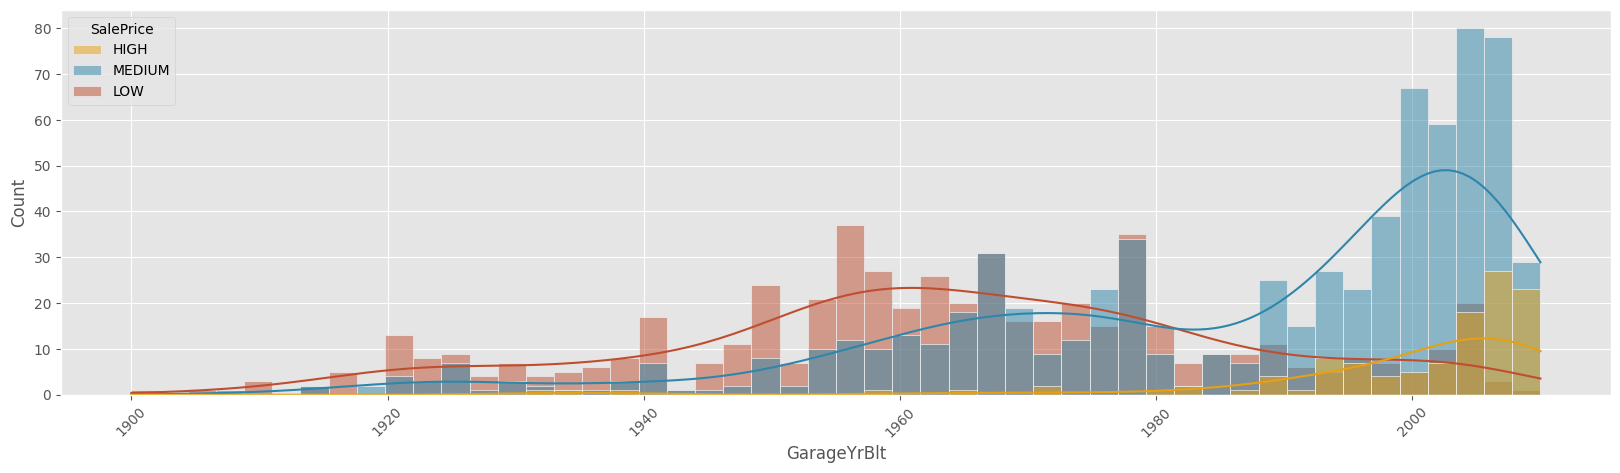

0.8256674841743443 0.0
0.4863616774878614 8.705127942139745e-83


(0.4863616774878614, 8.705127942139745e-83)

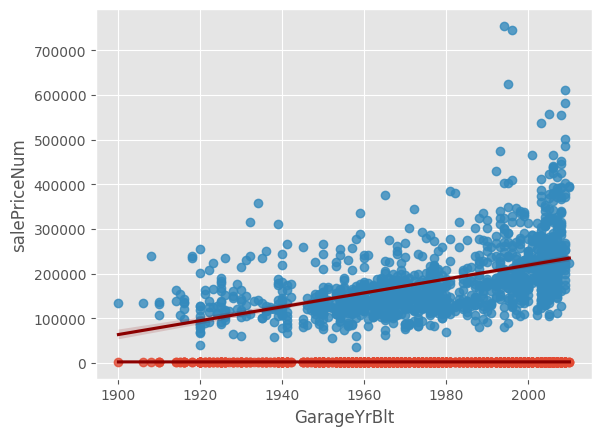

In [93]:
df_copy = df_copy.drop(df_copy[df_copy['GarageYrBlt'] == 'NA'].index)
df_copy['GarageYrBlt'] = df_copy['GarageYrBlt'].astype("int64")

histplot(df_copy, TARGET_FEATURE, 'GarageYrBlt', figsize=(20, 5), xticks_rot=45, bins=50)
correlation(df_copy, 'GarageYrBlt', 'YearBuilt')
correlation(df_copy, 'GarageYrBlt', TARGET_FEATURE_CONTI)

##### GarageFinish

['RFn' 'Unf' 'Fin' 'NA']


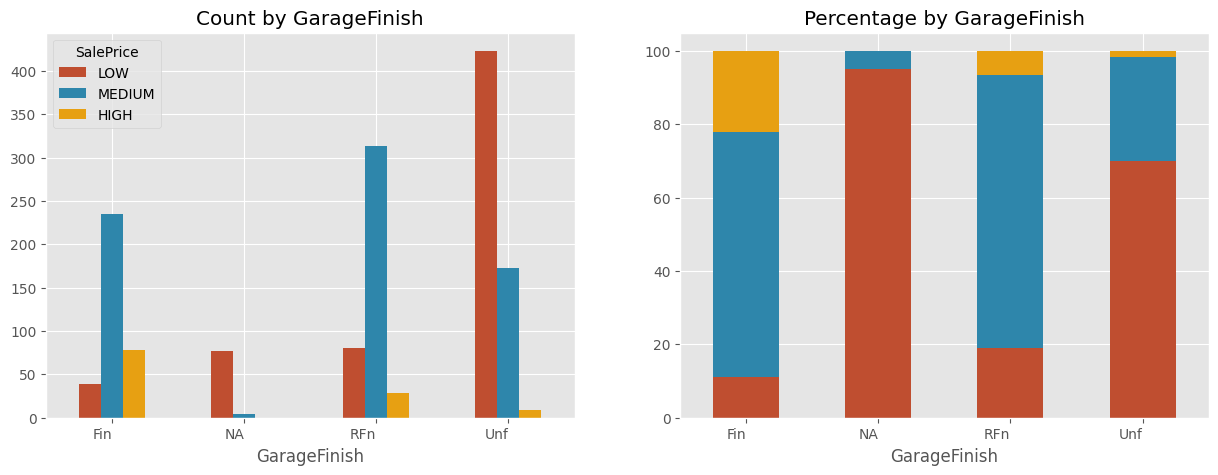

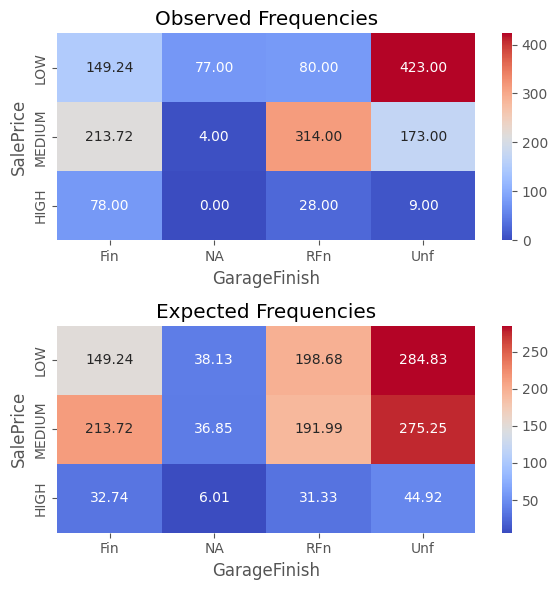

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]
Cramer's V - Outcome
Coeff: 0.4480324119716242


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3050799574413959

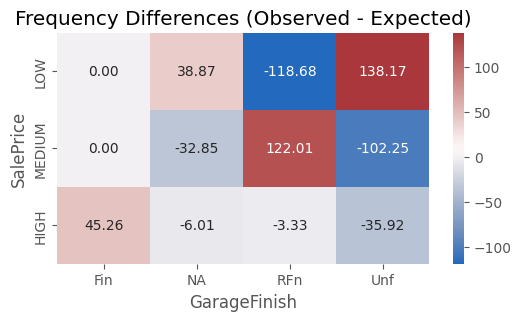

In [94]:
df_copy = df.copy(deep=True)
df_copy['GarageFinish'] = df['GarageFinish']
print(df_copy['GarageFinish'].unique())
df_copy['GarageFinish'] = df_copy['GarageFinish'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'GarageFinish')
stattest_quali(df_copy, 'GarageFinish')
IG(df_copy, TARGET_FEATURE, 'GarageFinish')

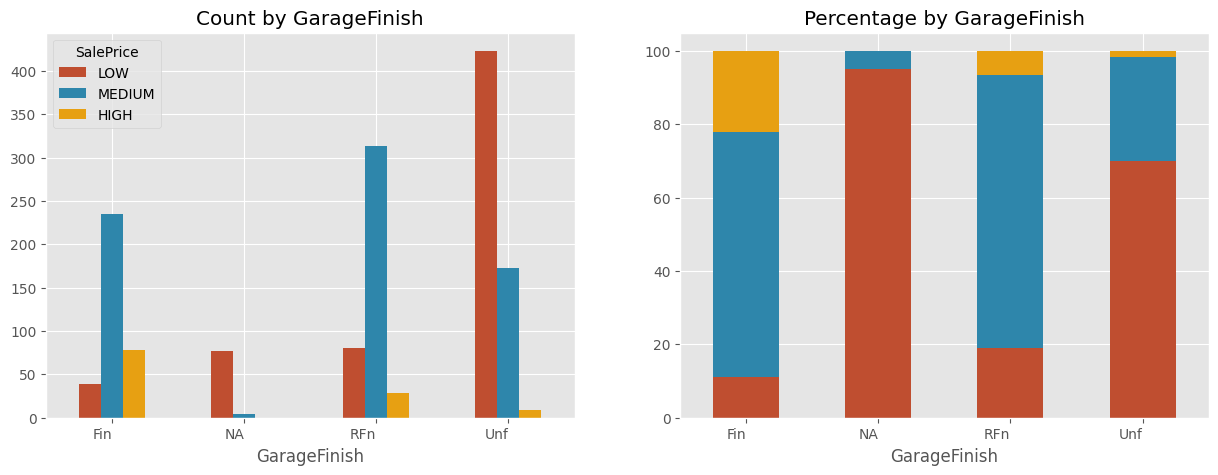

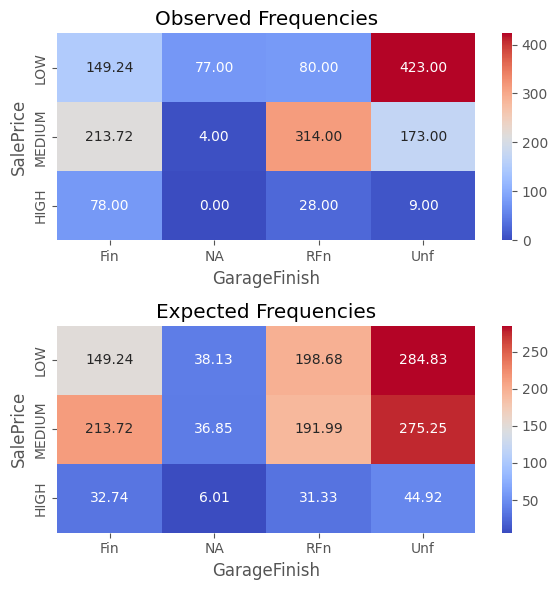

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]
Cramer's V - Outcome
Coeff: 0.4480324119716242
Understanding GarageFinish:
	Missing values: 0
	Independence Test: 2.28e-123[<0.05]
	Information Gain: 0.31
	When the GarageFinish is:
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• RFn, then the sale price is 70% likely to be MEDIUM (28.90% of the times)
		• Fin, then the sale price is 65% likely to be MEDIUM (24.11% of the times)
		• Unf, then the sale price is 65% likely to be LOW (41.44% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


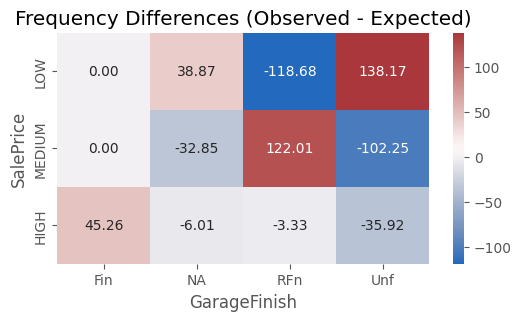

In [95]:
understand(df_copy, 'GarageFinish', 'category', showplots=True, na = 0)

##### GarageCars

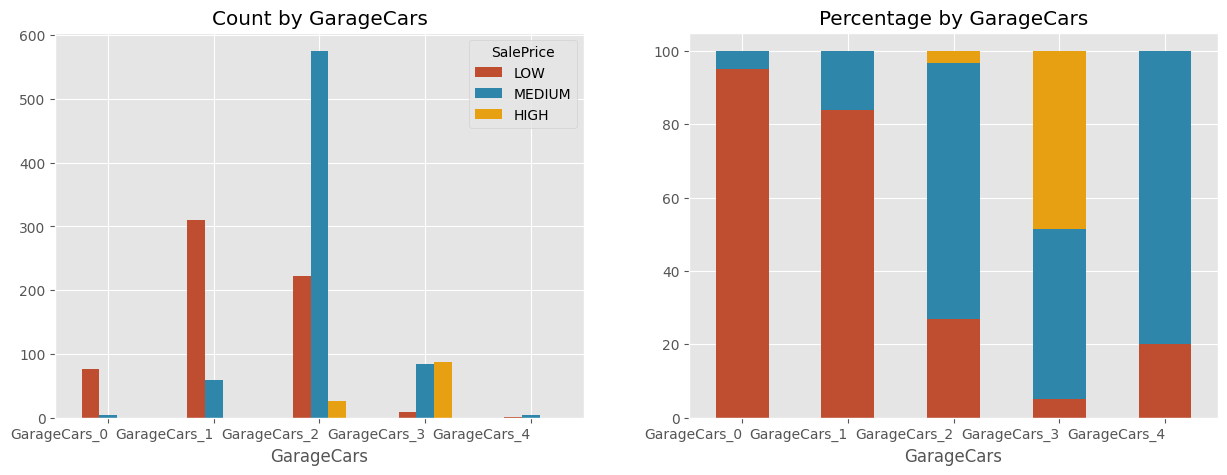

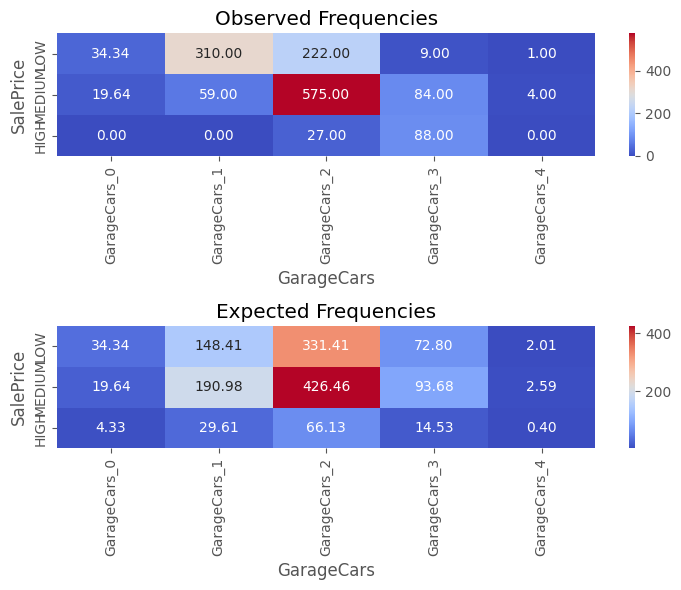

Chi-square Test - Outcome
P-Value: 1.5623976548288065e-196 [<0.05]
Cramer's V - Outcome
Coeff: 0.5658775647887696
0.3999207328264048


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


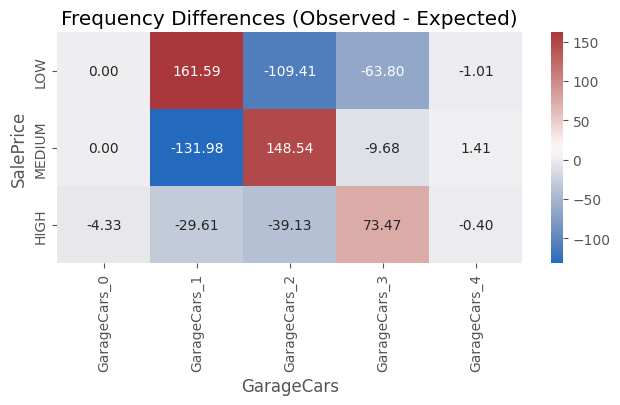

In [96]:
# understand(df_copy, 'GarageCars', 'category', showplots=True)
categoric_ordinal_plot(df_copy, 'GarageCars')

##### GarageArea

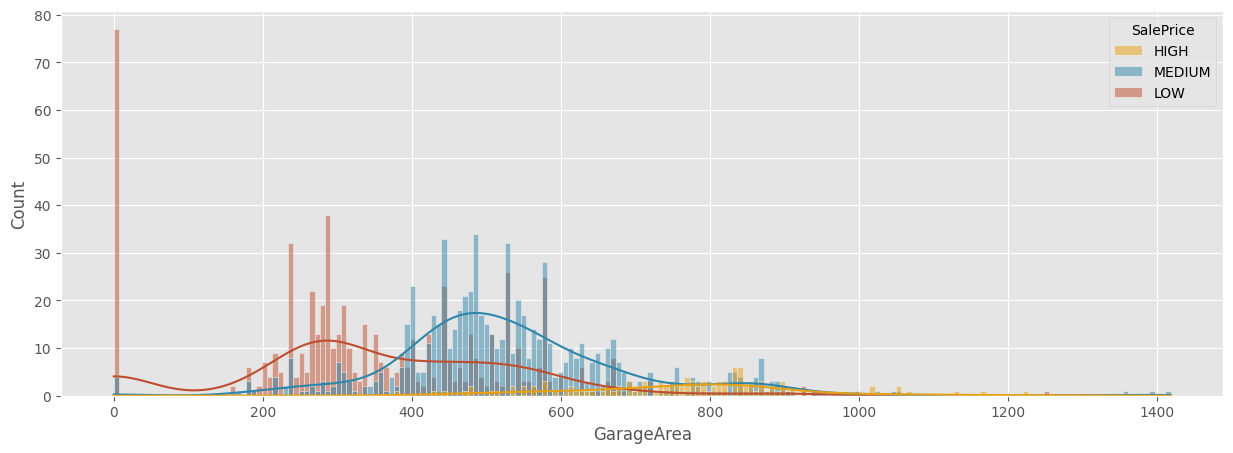

ANOVA Test - Outcome
P-Value: 0.0 [<0.05]


(0.0, '[<0.05]')

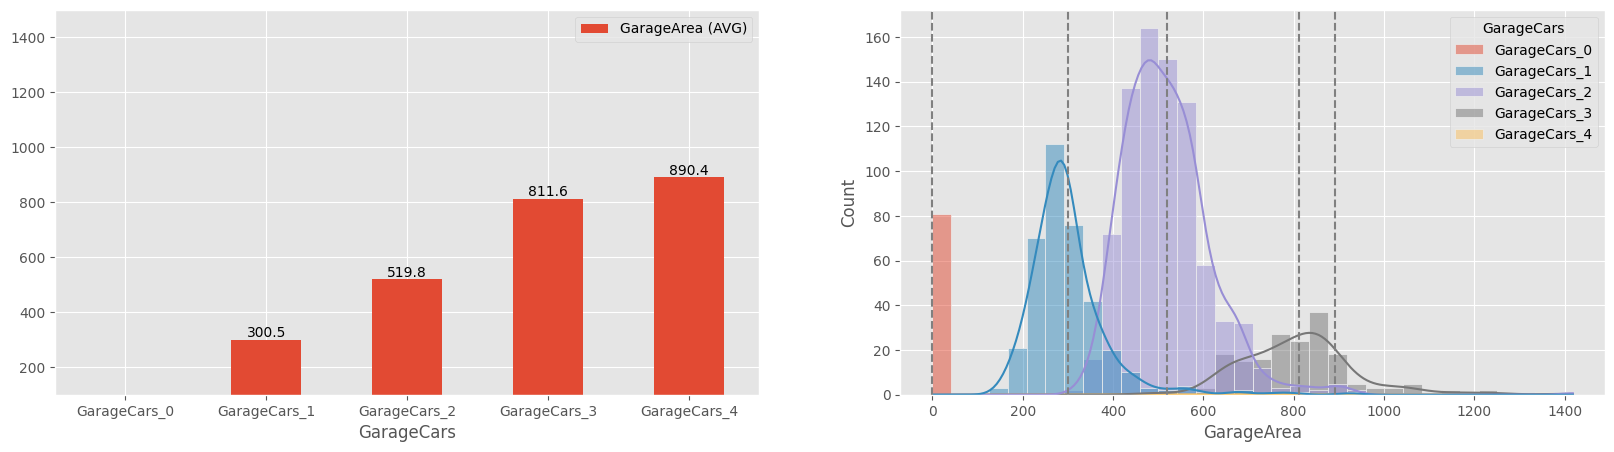

In [97]:
histplot(df_copy,TARGET_FEATURE ,'GarageArea', bins=200)
# correlation(df_copy,'GarageCars','GarageArea')
stattest_quanti(df_copy, 'GarageArea', 'GarageCars', low_limit= 100, upper_limit= 1500)

##### GarageQual

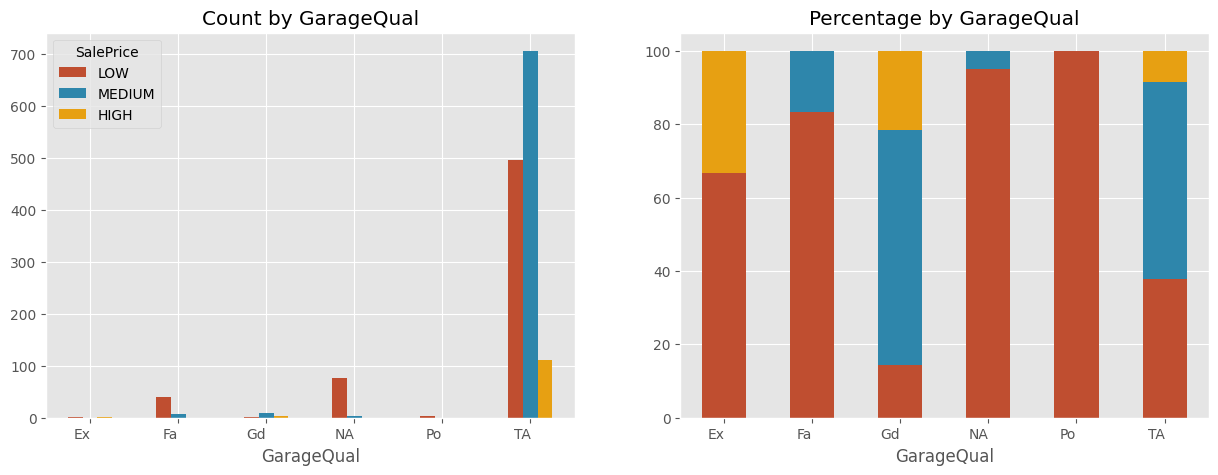

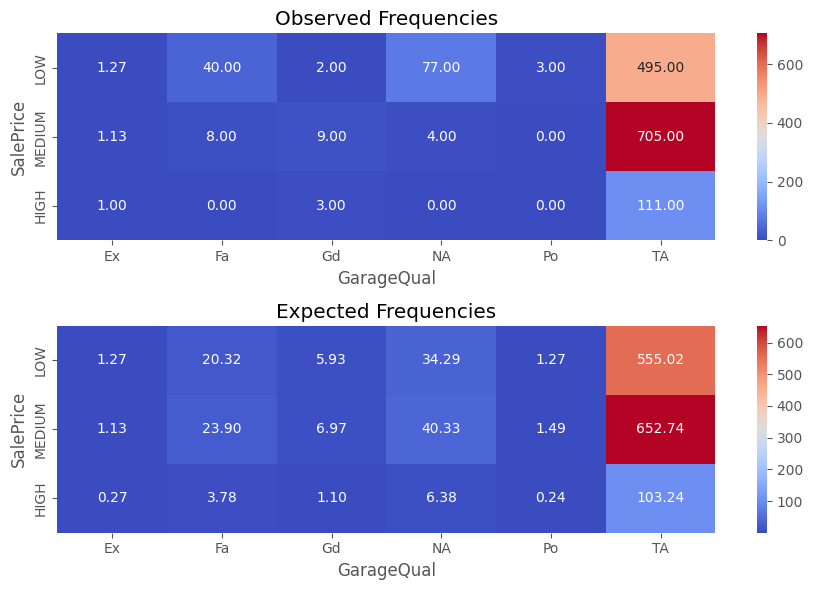

Chi-square Test - Outcome
P-Value: 1.5658170784469491e-27 [<0.05]
Cramer's V - Outcome
Coeff: 0.22802784686572622
Understanding GarageQual:
	Missing values: 0
	Independence Test: 1.57e-27[<0.05]
	Information Gain: 0.08
	When the GarageQual is:
		• Po, then the sale price is LOW (0.21% of the times)
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• Fa, then the sale price is 80% likely to be LOW (3.29% of the times)
		• Ex, then the sale price is 65% likely to be LOW (0.21% of the times)
		• Gd, then the sale price is 60% likely to be MEDIUM (0.96% of the times)
		• TA, then the sale price is 50% likely to be MEDIUM (89.79% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


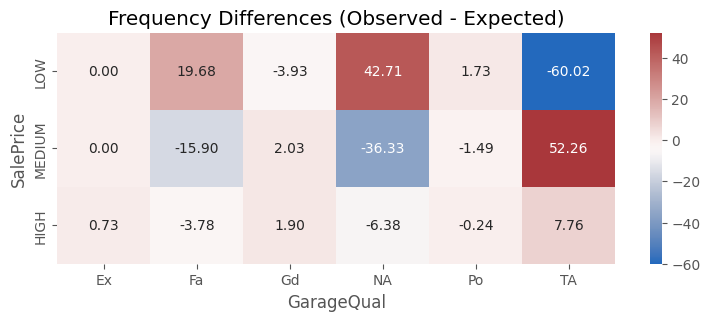

In [98]:
understand(df_copy,'GarageQual',dtype='category',showplots=True,na=0)

##### GarageCond

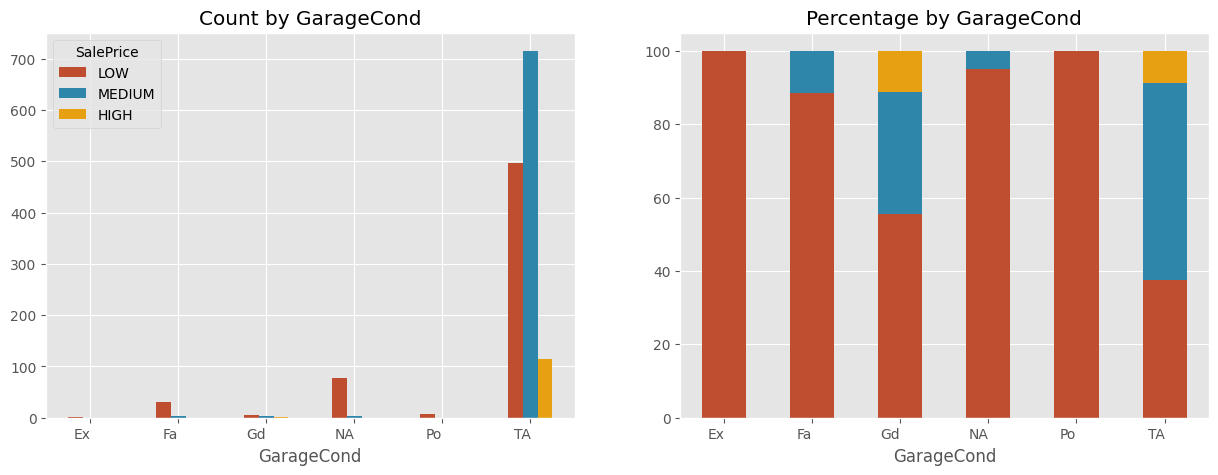

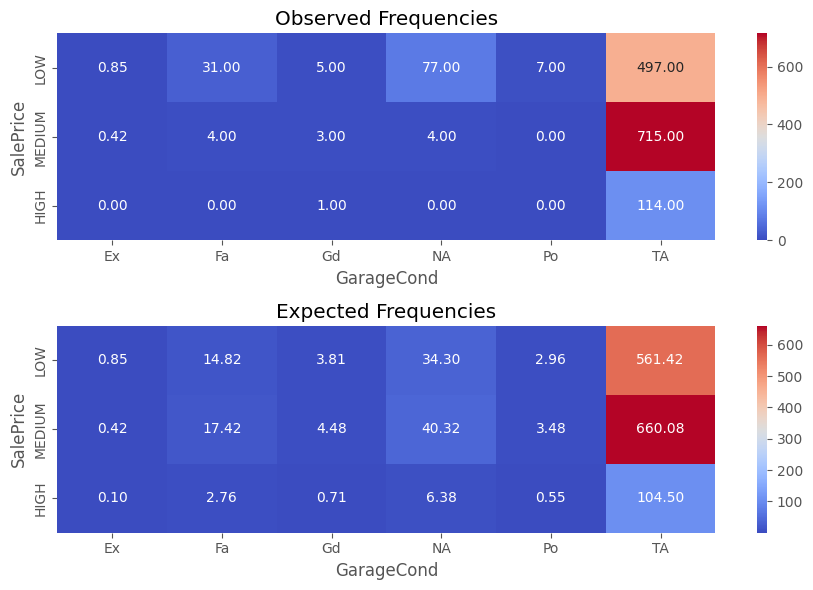

Chi-square Test - Outcome
P-Value: 5.837262851283957e-27 [<0.05]
Cramer's V - Outcome
Coeff: 0.22593259599407634
Understanding GarageCond:
	Missing values: 81
	Independence Test: 5.84e-27[<0.05]
	Information Gain: 0.08
	When the GarageCond is:
		• Ex+Po, then the sale price is LOW (0.62% of the times)
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• Fa, then the sale price is 85% likely to be LOW (2.40% of the times)
		• Gd, then the sale price is 55% likely to be LOW (0.62% of the times)
		• TA, then the sale price is 50% likely to be MEDIUM (90.82% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


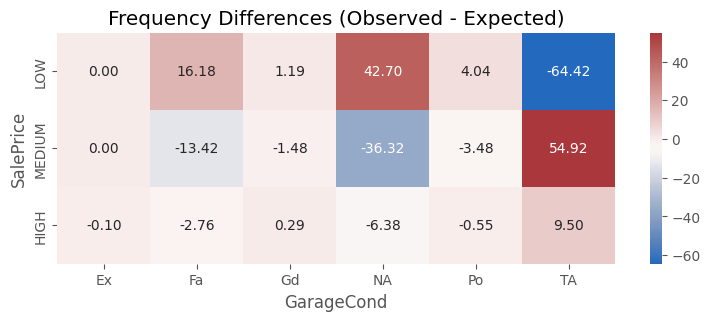

In [99]:
understand(df_copy,'GarageCond')

##### PavedDrive

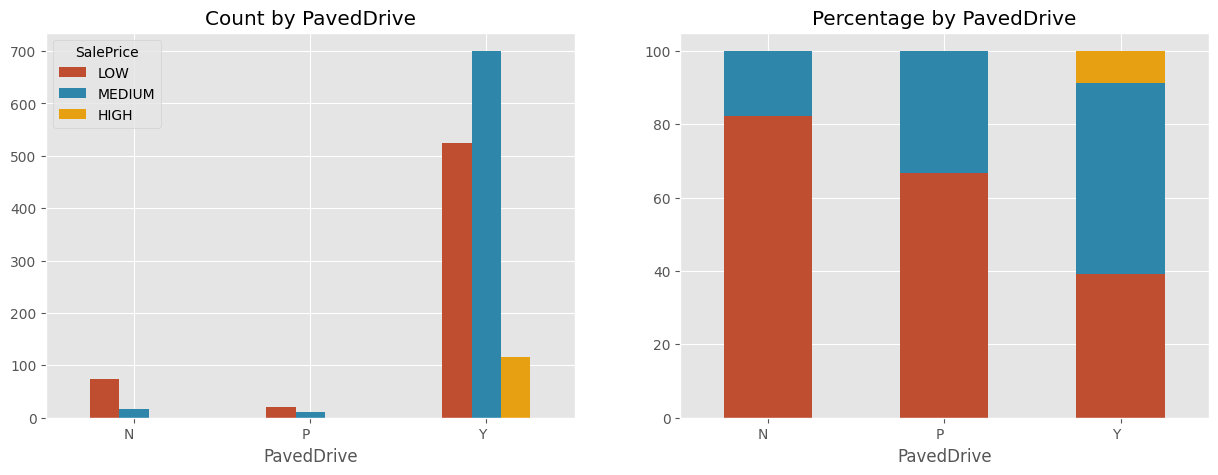

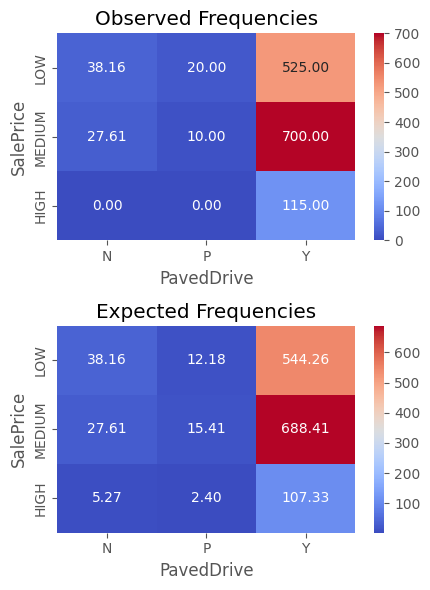

Chi-square Test - Outcome
P-Value: 4.777722451310024e-15 [<0.05]
Cramer's V - Outcome
Coeff: 0.15833436554542402
Understanding PavedDrive:
	Missing values: 0
	Independence Test: 4.78e-15[<0.05]
	Information Gain: 0.04
	When the PavedDrive is:
		• N, then the sale price is 80% likely to be LOW (6.16% of the times)
		• P, then the sale price is 65% likely to be LOW (2.05% of the times)
		• Y, then the sale price is 50% likely to be MEDIUM (91.78% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


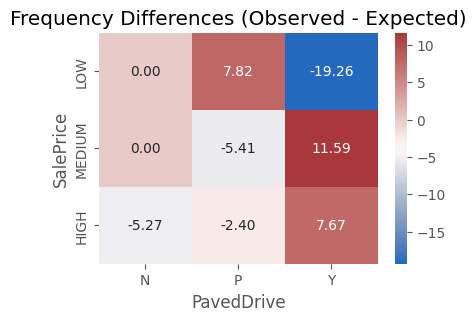

In [100]:
understand(df_copy,'PavedDrive')

##### WoodDeckSF

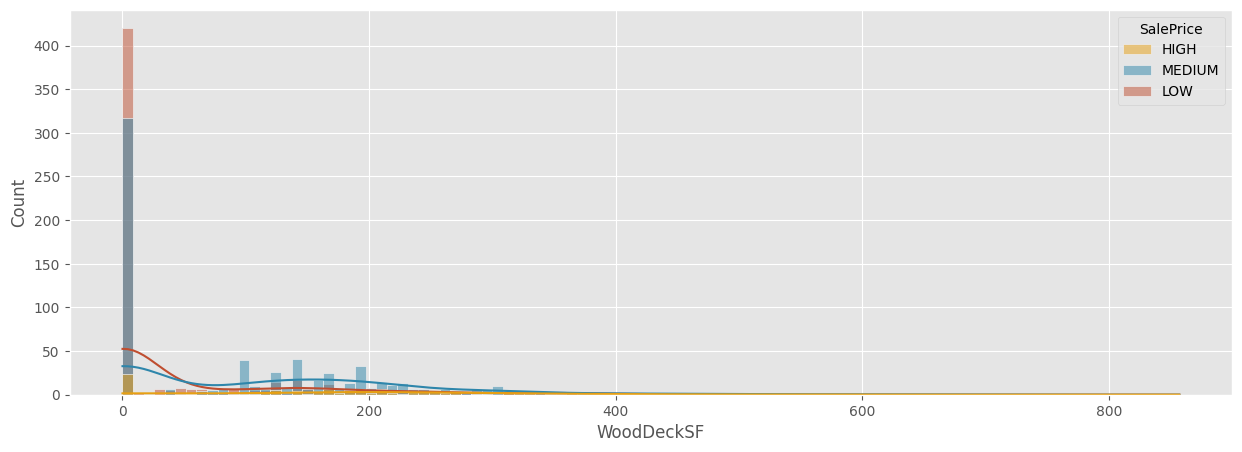

Understanding WoodDeckSF:
	Missing values: 0
	Independence Test: 1.12e-34[<0.05]
	Correlation Index: 0.32
	Correlation p_value: 3.97e-37



In [101]:
understand(df_copy, 'WoodDeckSF', dtype='int', bins=100, upper_limit=400)

##### OpenPorchSF

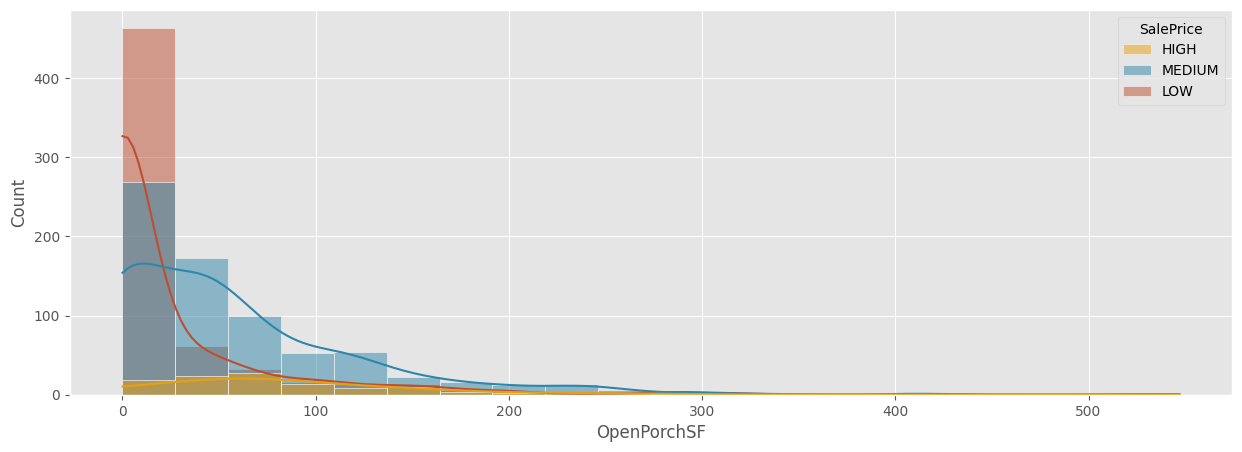

Understanding OpenPorchSF:
	Missing values: 0
	Independence Test: 3.15e-33[<0.05]
	Correlation Index: 0.32
	Correlation p_value: 3.49e-35



In [102]:
understand(df_copy, 'OpenPorchSF', dtype='int', bins=20)

##### EnclosedPorch

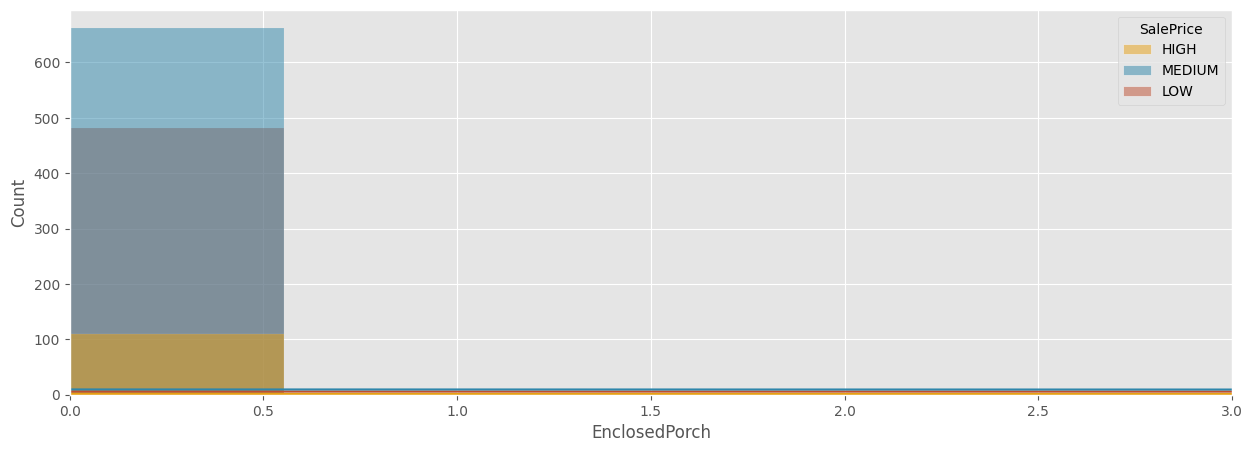

Understanding EnclosedPorch:
	Missing values: 0
	Independence Test: 5.12e-07[<0.05]
	Correlation Index: -0.13
	Correlation p_value: 8.26e-07



In [103]:
understand(df_copy, 'EnclosedPorch', dtype='int', bins=1000, xlim=(0,3))

##### 3SsnPorch

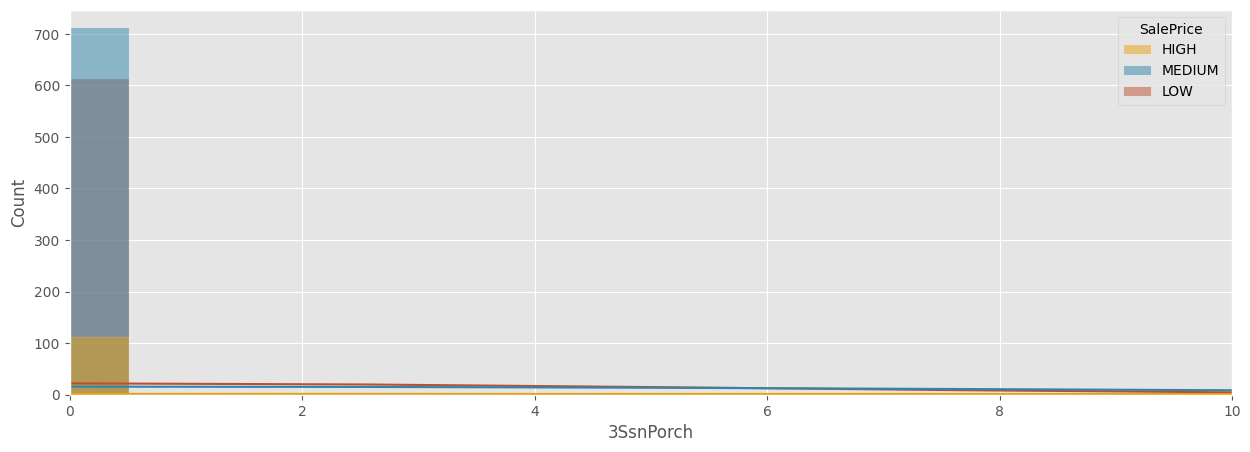

Understanding 3SsnPorch:
	Missing values: 0
	Independence Test: 2.40e-01
	Correlation Index: 0.04
	Correlation p_value: 8.86e-02



In [104]:
understand(df_copy, '3SsnPorch', dtype='int', bins=1000, xlim=(0,10))

##### ScreenPorch

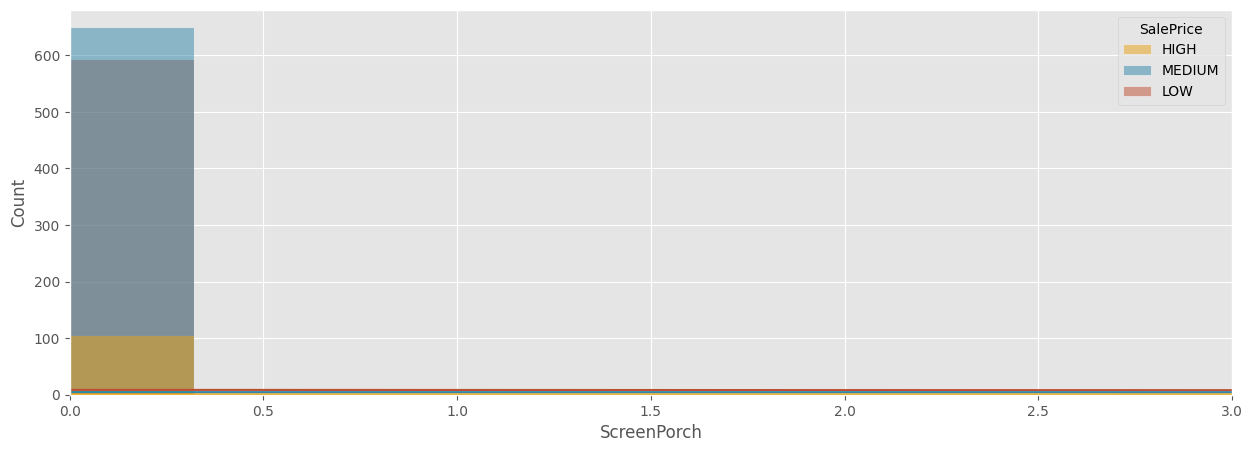

Understanding ScreenPorch:
	Missing values: 0
	Independence Test: 1.59e-06[<0.05]
	Correlation Index: 0.11
	Correlation p_value: 1.97e-05



In [105]:
understand(df_copy, 'ScreenPorch', dtype='int', bins=1500, xlim=(0,3))


##### PoolArea

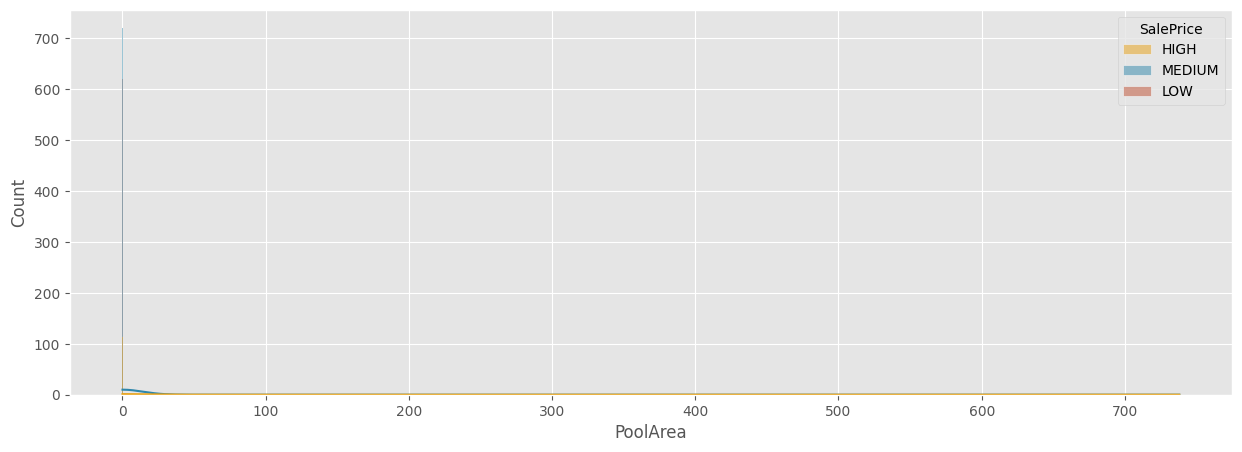

Understanding PoolArea:
	Missing values: 0
	Independence Test: 7.93e-02
	Correlation Index: 0.09
	Correlation p_value: 4.07e-04



In [106]:
understand(df_copy, 'PoolArea', dtype='int', bins=1500)

##### PoolQC

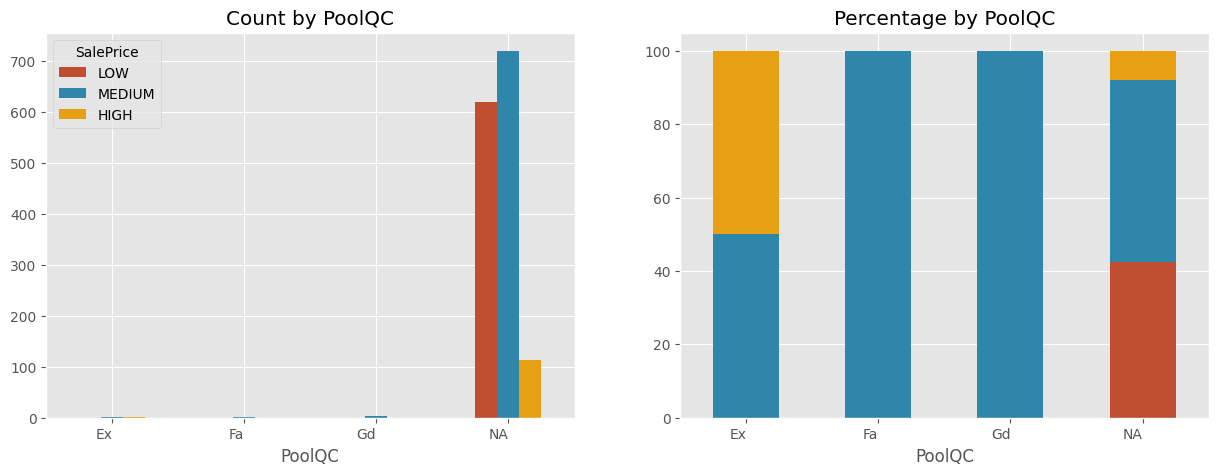

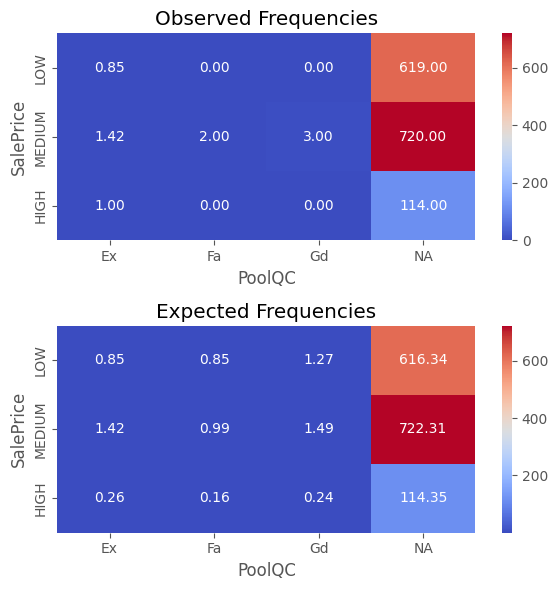

Chi-square Test - Outcome
P-Value: 0.10755220456771697 
Cramer's V - Outcome
Coeff: 0.05977489745520364
Understanding PoolQC:
	Missing values: 0
	Independence Test: 1.08e-01
	Information Gain: 0.01
	When the PoolQC is:
		• Fa+Gd, then the sale price is MEDIUM (0.34% of the times)
		• Ex, then the sale price is 50% likely to be MEDIUM (0.14% of the times)
		• NA, then the sale price is 45% likely to be MEDIUM (99.52% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


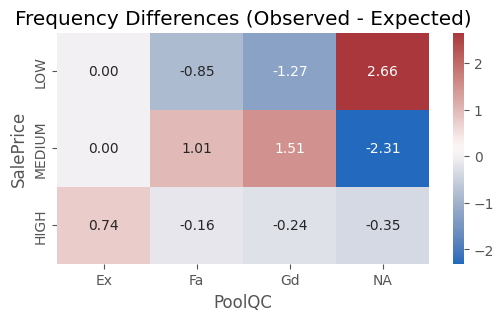

In [107]:
understand(dataf=df_copy, feature_name= 'PoolQC', na = 0)

##### Fence

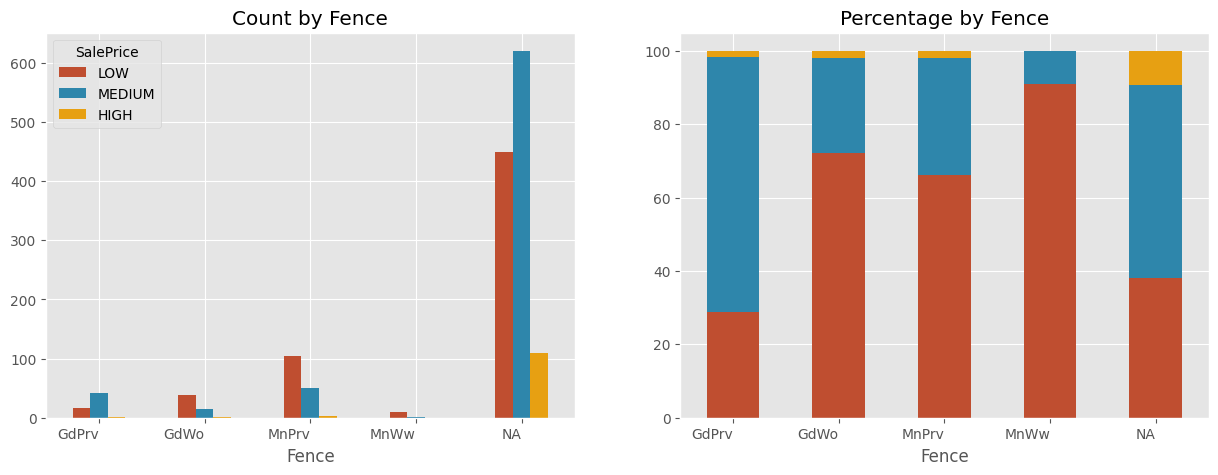

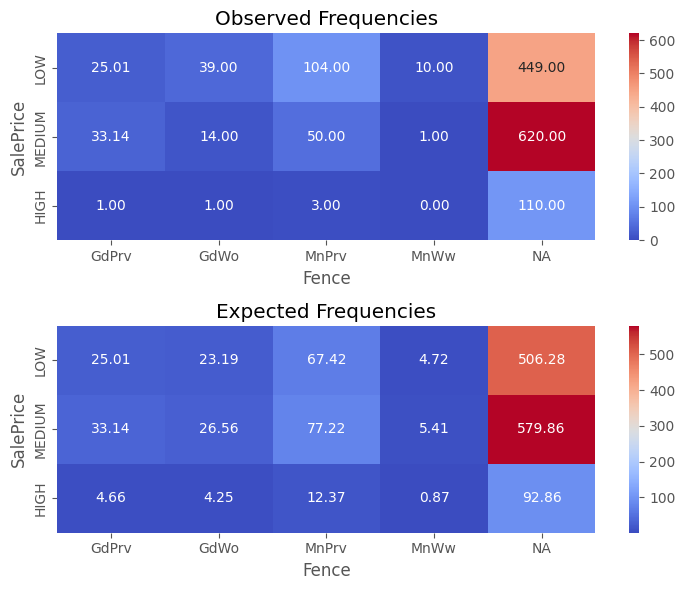

Chi-square Test - Outcome
P-Value: 6.825903732579082e-16 [<0.05]
Cramer's V - Outcome
Coeff: 0.174758863353414
Understanding Fence:
	Missing values: 0
	Independence Test: 6.83e-16[<0.05]
	Information Gain: 0.05
	When the Fence is:
		• MnWw, then the sale price is 90% likely to be LOW (0.75% of the times)
		• GdWo, then the sale price is 70% likely to be LOW (3.70% of the times)
		• GdPrv, then the sale price is 65% likely to be MEDIUM (4.04% of the times)
		• MnPrv, then the sale price is 65% likely to be LOW (10.75% of the times)
		• NA, then the sale price is 50% likely to be MEDIUM (80.75% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


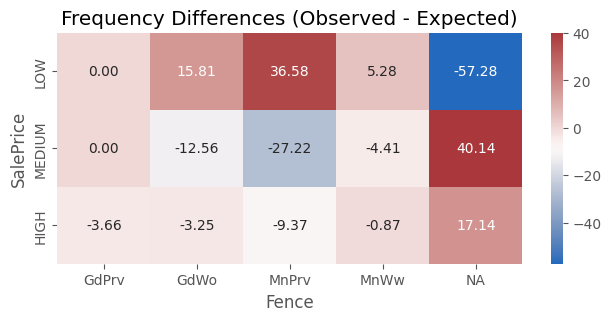

In [108]:
understand(dataf=df_copy, feature_name= 'Fence', na = 0)


##### MiscFeature

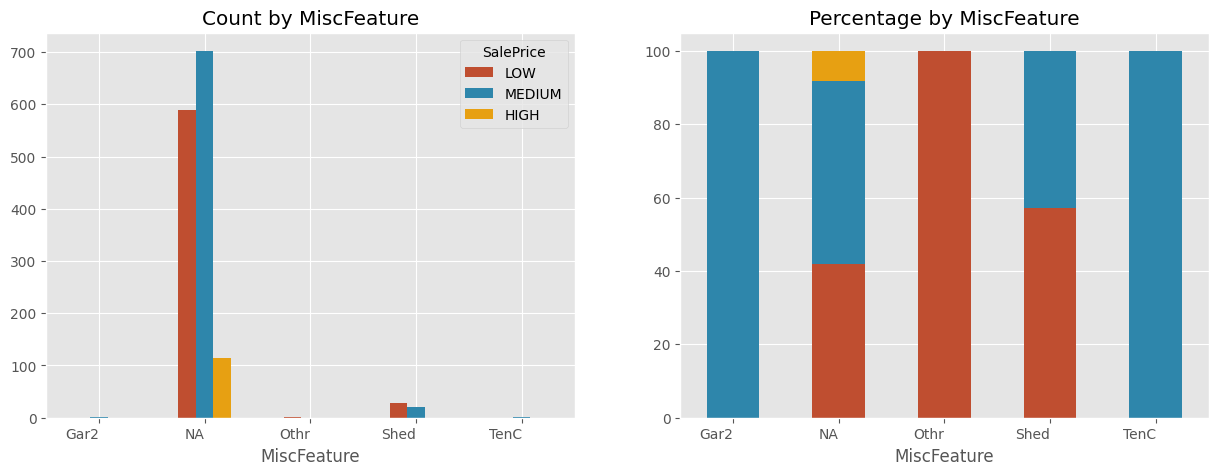

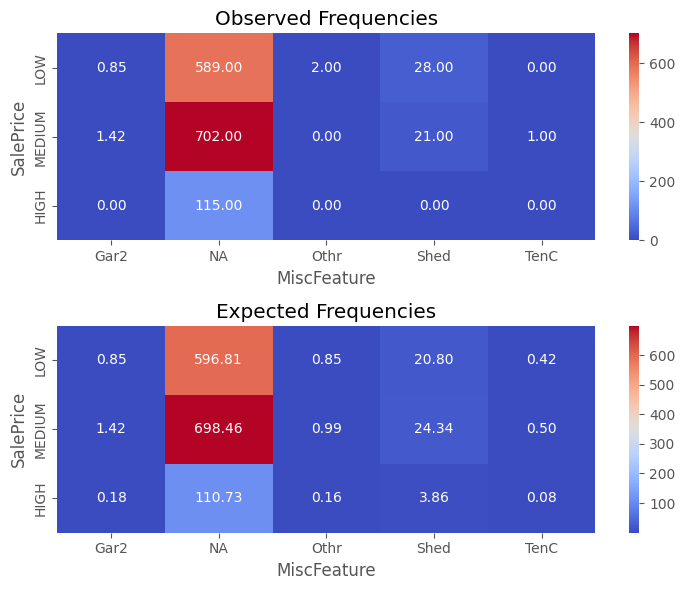

Chi-square Test - Outcome
P-Value: 0.11720562475052677 
Cramer's V - Outcome
Coeff: 0.06633119495612459
Understanding MiscFeature:
	Missing values: 0
	Independence Test: 1.17e-01
	Information Gain: 0.01
	When the MiscFeature is:
		• Othr, then the sale price is LOW (0.14% of the times)
		• Gar2+TenC, then the sale price is MEDIUM (0.21% of the times)
		• Shed, then the sale price is 55% likely to be LOW (3.36% of the times)
		• NA, then the sale price is 45% likely to be MEDIUM (96.30% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


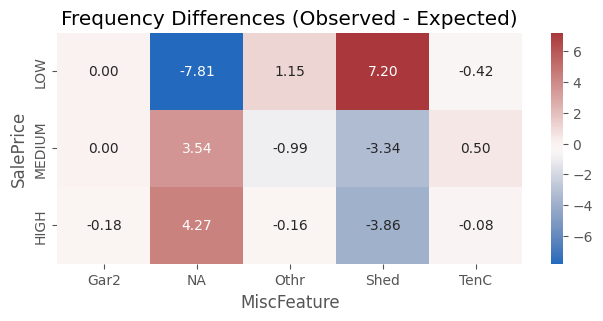

In [109]:
understand(dataf=df_copy, feature_name= 'MiscFeature', na = 0)


##### MiscVal

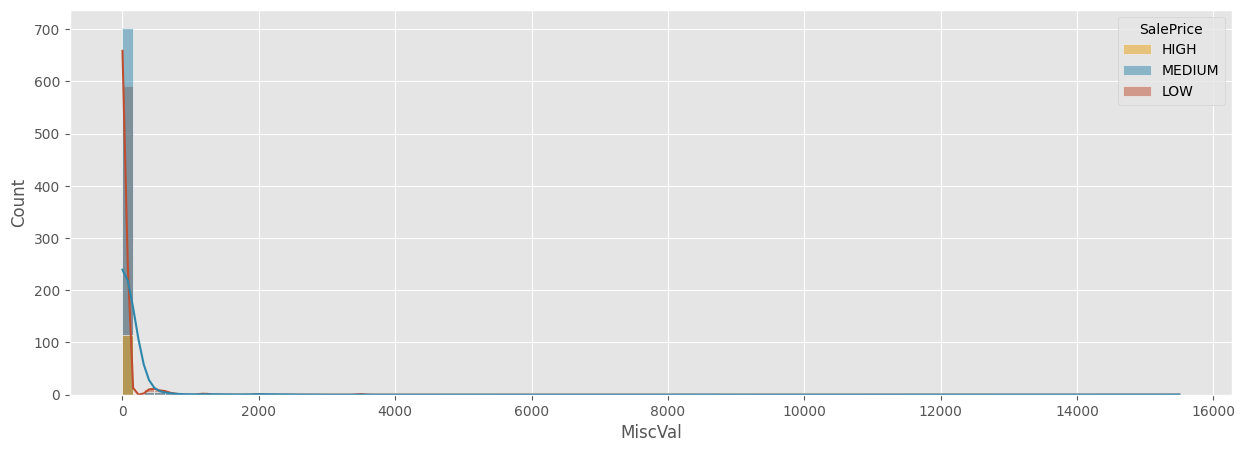

Understanding MiscVal:
	Missing values: 0
	Independence Test: 3.64e-01
	Correlation Index: -0.02
	Correlation p_value: 4.18e-01



In [110]:
understand(df_copy, 'MiscVal', dtype='int', bins=100)

##### MoSold

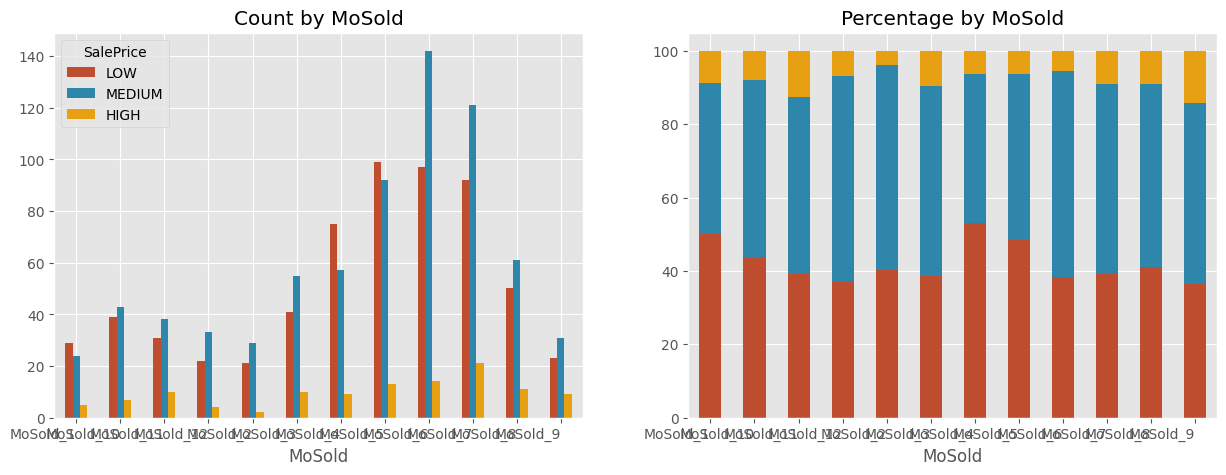

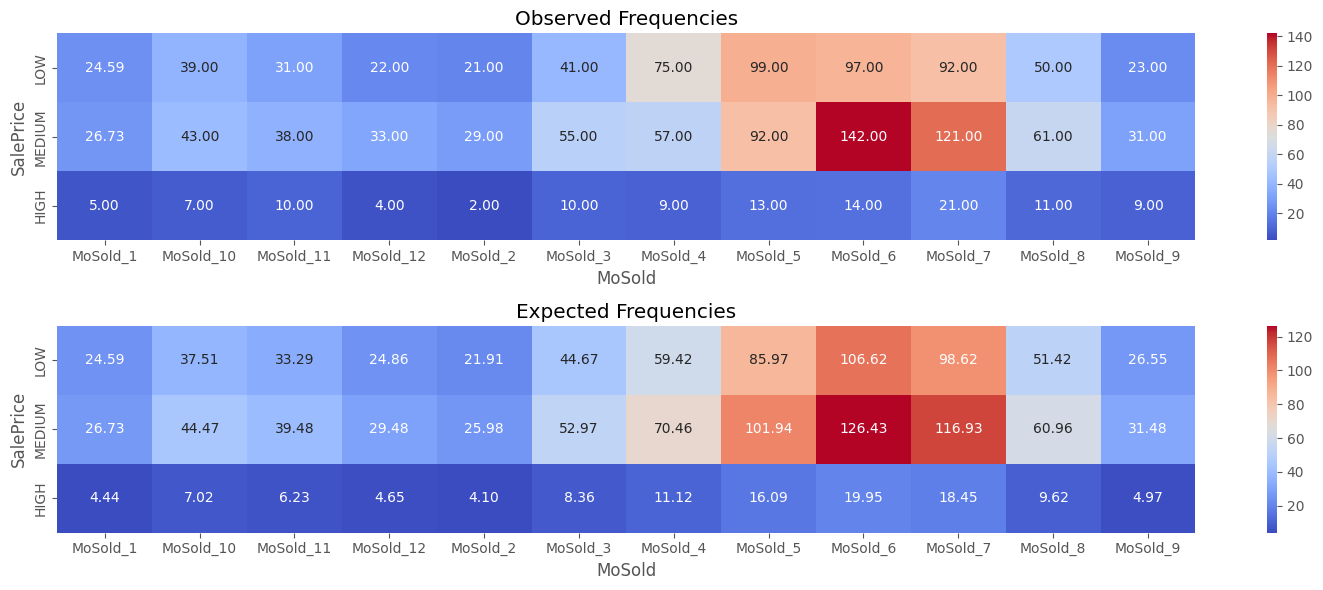

Chi-square Test - Outcome
P-Value: 0.19672812545573456 
Cramer's V - Outcome
Coeff: 0.09685398914194049
Understanding MoSold:
	Missing values: 0
	Independence Test: 1.97e-01
	Information Gain: 0.01
	When the MoSold is:
		• MoSold_12+MoSold_2+MoSold_6, then the sale price is 55% likely to be MEDIUM (24.93% of the times)
		• MoSold_1+MoSold_4, then the sale price is 50% likely to be LOW (13.63% of the times)
		• MoSold_3+MoSold_7+MoSold_8, then the sale price is 50% likely to be MEDIUM (31.64% of the times)
		• MoSold_5, then the sale price is 45% likely to be LOW (13.97% of the times)
		• MoSold_10+MoSold_11+MoSold_9, then the sale price is 45% likely to be MEDIUM (15.82% of the times)




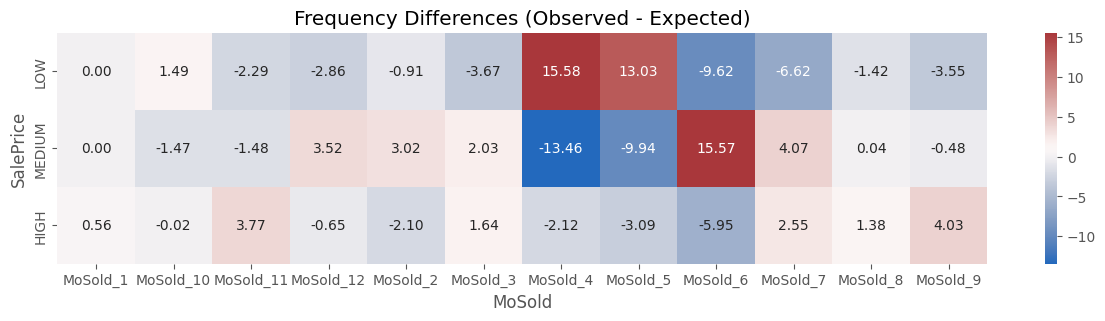

In [111]:
understand(dataf=df_copy, feature_name='MoSold', dtype='object')

##### YrSold

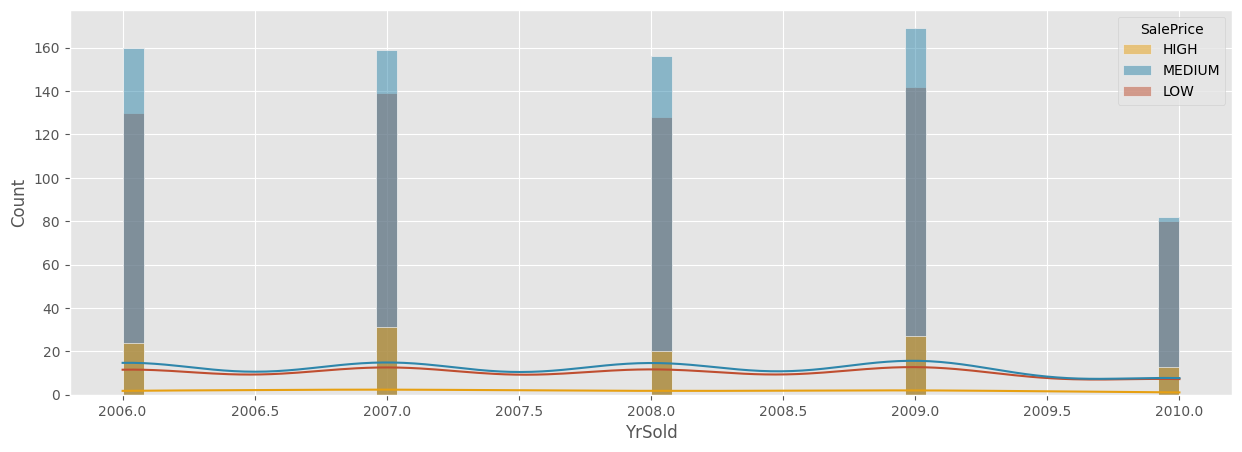

Understanding YrSold:
	Missing values: 0
	Independence Test: 7.80e-01
	Correlation Index: -0.03
	Correlation p_value: 2.69e-01



In [112]:
understand(df_copy, 'YrSold', dtype='int', upper_limit=2023, low_limit= 2000)

##### SaleType

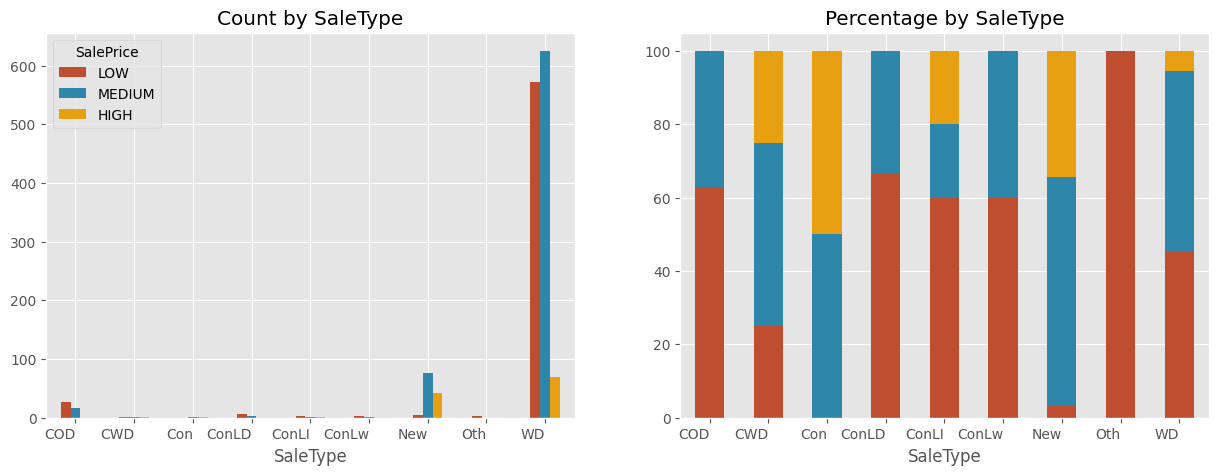

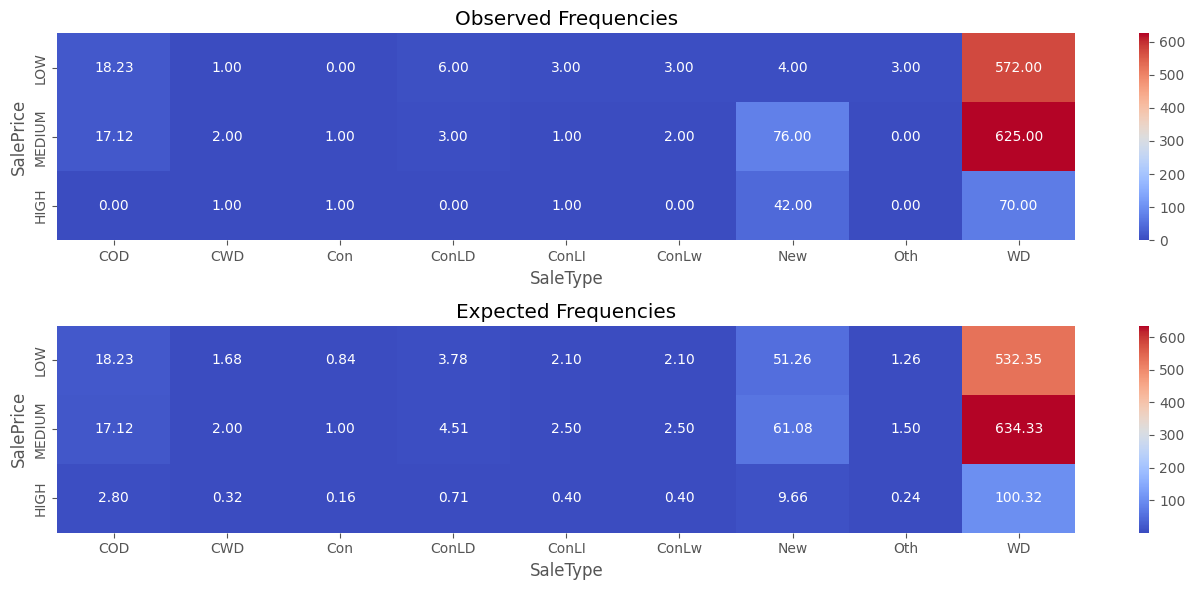

Chi-square Test - Outcome
P-Value: 1.331354726540166e-32 [<0.05]
Cramer's V - Outcome
Coeff: 0.2577111706039038
Understanding SaleType:
	Missing values: 0
	Independence Test: 1.33e-32[<0.05]
	Information Gain: 0.09
	When the SaleType is:
		• Oth, then the sale price is LOW (0.21% of the times)
		• ConLD, then the sale price is 65% likely to be LOW (0.62% of the times)
		• COD+ConLI+ConLw, then the sale price is 60% likely to be LOW (3.63% of the times)
		• New, then the sale price is 60% likely to be MEDIUM (8.36% of the times)
		• CWD+Con, then the sale price is 50% likely to be MEDIUM (0.41% of the times)
		• WD, then the sale price is 45% likely to be LOW (86.78% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


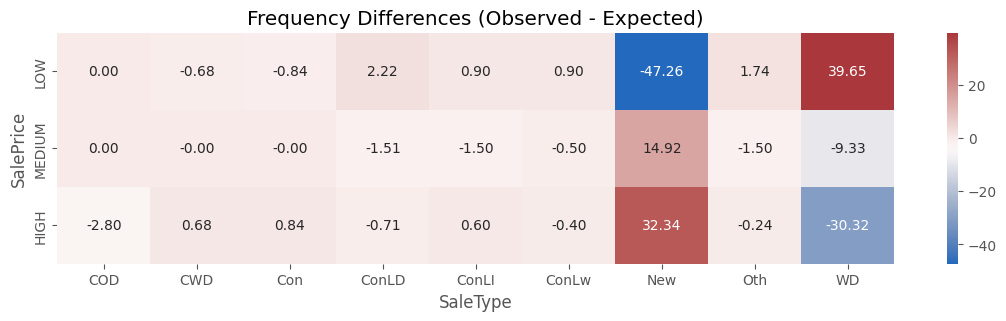

In [113]:
understand(dataf=df_copy, feature_name='SaleType')

##### SaleCondition

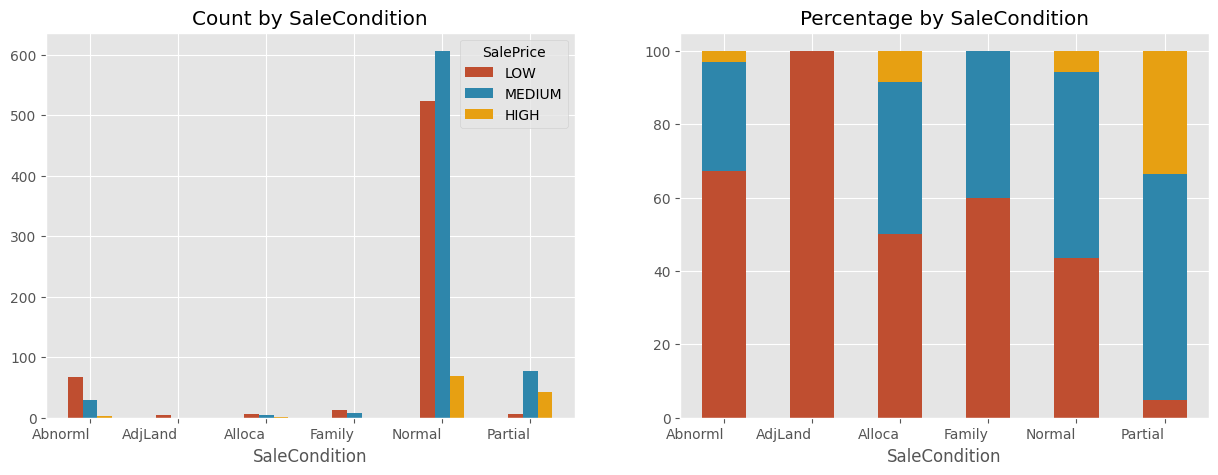

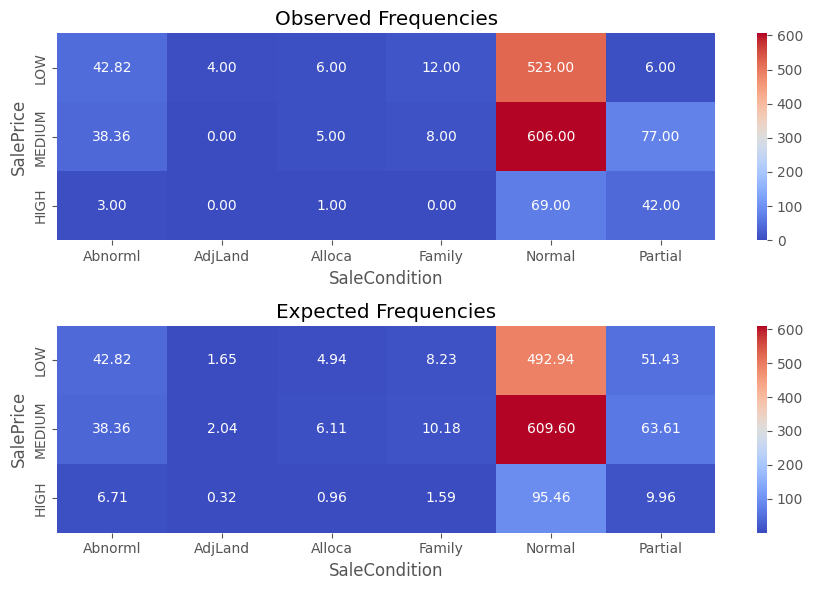

Chi-square Test - Outcome
P-Value: 4.916466420372617e-36 [<0.05]
Cramer's V - Outcome
Coeff: 0.25701128307578847
Understanding SaleCondition:
	Missing values: 0
	Independence Test: 4.92e-36[<0.05]
	Information Gain: 0.09
	When the SaleCondition is:
		• AdjLand, then the sale price is LOW (0.27% of the times)
		• Abnorml, then the sale price is 65% likely to be LOW (6.92% of the times)
		• Family, then the sale price is 60% likely to be LOW (1.37% of the times)
		• Partial, then the sale price is 60% likely to be MEDIUM (8.56% of the times)
		• Alloca, then the sale price is 50% likely to be LOW (0.82% of the times)
		• Normal, then the sale price is 50% likely to be MEDIUM (82.05% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


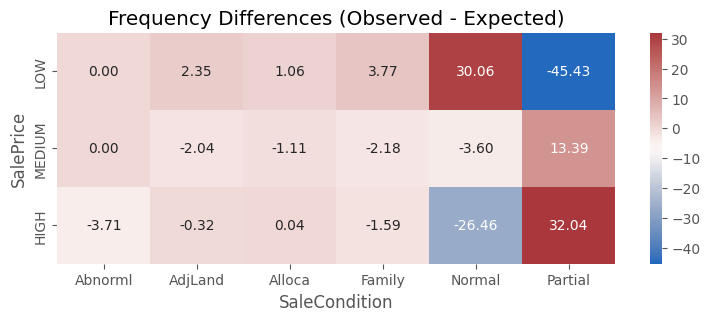

In [114]:
understand(dataf=df_copy, feature_name='SaleCondition')

##### TotalSF

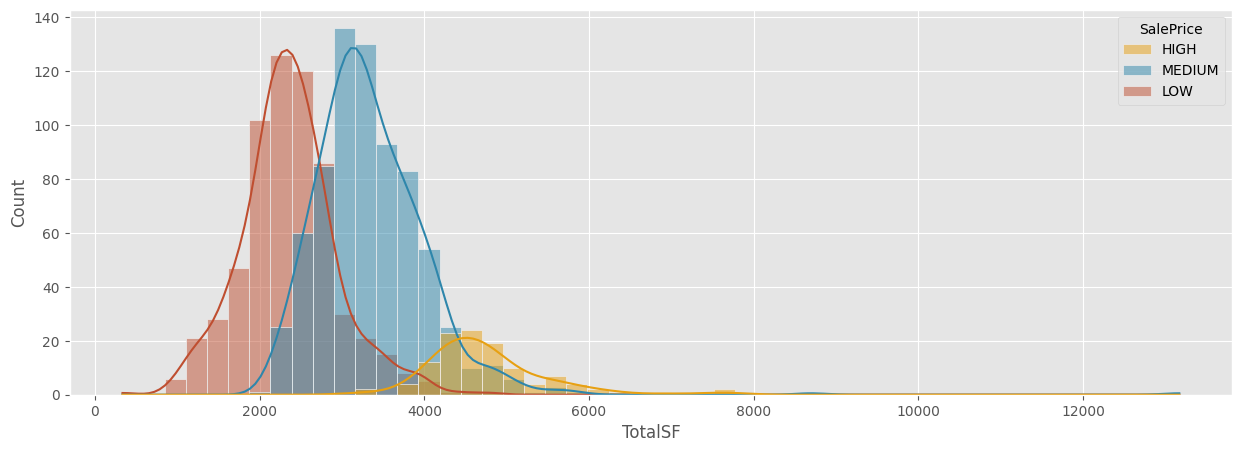

Understanding TotalSF:
	Missing values: 0
	Independence Test: 1.45e-229[<0.05]
	Correlation Index: 0.81
	Correlation p_value: 0.00e+00



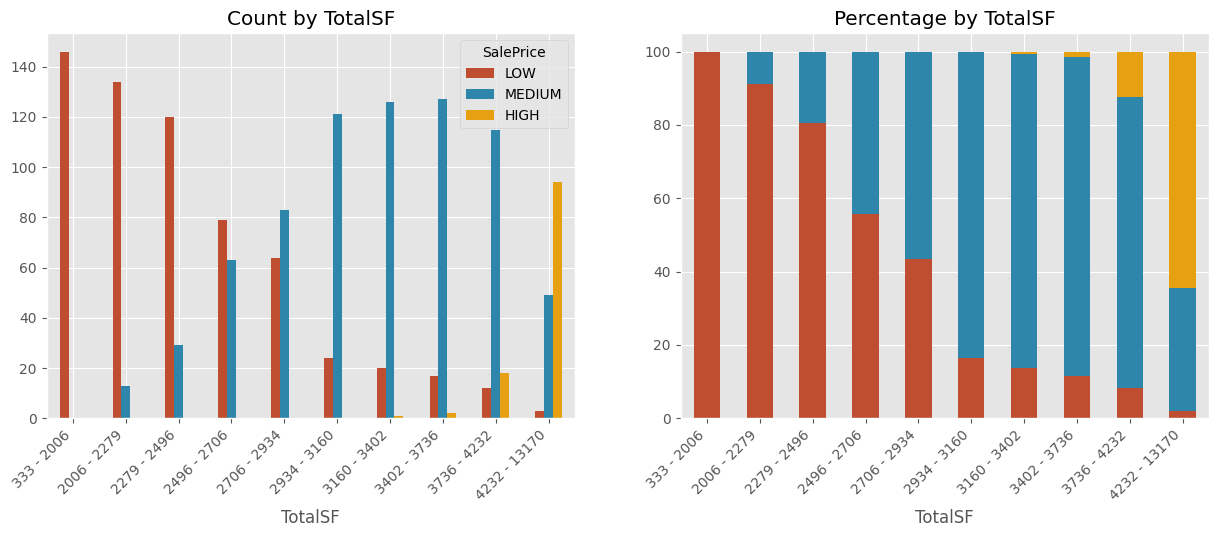

In [115]:
df_copy["TotalSF"] = total_square_feet(df_copy)

understand(dataf=df_copy, feature_name='TotalSF', dtype='int', upper_limit=8000)
frequencies_and_percentages_numeric(df=df_copy, target=TARGET_FEATURE, attribute='TotalSF', bin=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], rotation=45)

#### Correlation

In [116]:

# SELECTED = [ 'MSSubClass', 'LotArea', 'Neighborhood', 'HouseStyle', 
#             'OverallQual', 'YearBuilt', 'YearRemodAdd',
#              'Exterior1st', 'MasVnrType',  'MasVnrArea' ,
#              "ExterQual", "Foundation", "BsmtQual", "BsmtFinType1", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "KitchenQual", "GrLivArea", "FullBath", "TotRmsAbvGrd",
#             "Fireplaces", "GarageType", "GarageFinish", "GarageArea"
#             ]

# understand_correlation_all(df_copy, selected=SELECTED)



Pair 0 : MasVnrType<->MasVnrArea -> 0.8918939304620889
Pair 1 : GrLivArea<->TotRmsAbvGrd -> 0.8254893743088356
Pair 2 : TotalBsmtSF<->1stFlrSF -> 0.8195299750050345
Pair 3 : 2ndFlrSF<->GrLivArea -> 0.6875010641666
Pair 4 : GarageType<->GarageFinish -> 0.6872189796273703
Pair 5 : MSSubClass<->HouseStyle -> 0.6815815663184105
Pair 6 : GrLivArea<->FullBath -> 0.6300116462511144
Pair 7 : 2ndFlrSF<->TotRmsAbvGrd -> 0.6164226354915345
Pair 8 : OverallQual<->MasVnrArea -> 0.6115855912304079
Pair 9 : OverallQual<->GrLivArea -> 0.5930074300286508
Pair 10 : MasVnrArea<->FullBath -> 0.5928764259205855
Pair 11 : YearBuilt<->YearRemodAdd -> 0.5928549763436506
Pair 12 : BsmtQual<->BsmtFinType1 -> 0.5793810965697551
Pair 13 : MasVnrArea<->ExterQual -> 0.5762207399656584
Pair 14 : OverallQual<->YearBuilt -> 0.572322768962362
Pair 15 : 1stFlrSF<->GrLivArea -> 0.5660239689357488
Pair 16 : OverallQual<->GarageArea -> 0.5620217566126073
Pair 17 : OverallQual<->ExterQual -> 0.5607593519180496
Pair 18 : Ful